# Machine Learning Basics
In this tutorial we learn how to split data, transform data and apply regularization using logistic regression example.

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from tqdm.notebook import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [2]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

**Download the data if needed (and unpack it into the Data folder), we use the same dataset as in the python intro:** <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/data_devsample.zip" target="_blank">credit risk data</a> 

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

Original [Kaggle competition](https://www.kaggle.com/competitions/home-credit-default-risk/data)

In [3]:
# Load data - set index column, decimal point, separator
data_file = Path("../Data/data_devsample.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'SK_ID_CURR')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2023-03-07 17:37:39


In [4]:
data

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
215138         0.0         Cash loans           M            N   
325963         0.0         Cash loans           M            Y   
206923         0.0         Cash loans           F            N   
265855         0.0         Cash loans           F            N   
359795         0.0    Revolving loans           F            N   
...            ...                ...         ...          ...   
203263         0.0         Cash loans           F            N   
304373         0.0         Cash loans           M            N   
348873         0.0         Cash loans           F            Y   
296666         1.0         Cash loans           M            Y   
259380         0.0         Cash loans           F            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
215138                   Y           0.0          135000.0    646920.0   
325963                   Y           0.0          135000.0    740218.5   
206923                   Y           0.0          180000.0    339241.5   
265855                   Y           0.0          180000.0   1264428.0   
359795                   Y           NaN           76500.0    202500.0   
...                    ...           ...               ...         ...   
203263                   N           0.0          135000.0    888840.0   
304373                   Y           0.0          306000.0   1288350.0   
348873                   N           0.0          225000.0    781920.0   
296666                   Y           2.0          202500.0    634887.0   
259380                   Y           3.0           67500.0    163008.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
SK_ID_CURR                                                 
215138          25195.5         540000.0          Family   
325963          40284.0         639000.0   Unaccompanied   
206923          12919.5         238500.0   Unaccompanied   
265855          37098.0         990000.0   Unaccompanied   
359795          10125.0         202500.0   Unaccompanied   
...                 ...              ...             ...   
203263          29506.5         675000.0   Unaccompanied   
304373          41692.5        1125000.0   Unaccompanied   
348873          41400.0         675000.0         Other_A   
296666          25987.5         513000.0   Unaccompanied   
259380          11020.5         144000.0   Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
215138                   Working  Secondary / secondary special   
325963                 Pensioner  Secondary / secondary special   
206923                   Working  Secondary / secondary special   
265855      Commercial associate  Secondary / secondary special   
359795                   Working               Higher education   
...                          ...                            ...   
203263                 Pensioner  Secondary / secondary special   
304373                   Working  Secondary / secondary special   
348873      Commercial associate               Higher education   
296666      Commercial associate  Secondary / secondary special   
259380                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
215138                   Married  House / apartment   
325963                   Married       With parents   
206923                   Married  House / apartment   
265855                   Married  House / apartment   
359795                   Married  House / apartment   
...                          ...                ...   
203263                 Separated   Office apartment   
304373                   Married  House / 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 215138 to 259380
Columns: 196 entries, TARGET to MONTH
dtypes: float64(139), int64(40), object(17)
memory usage: 120.2+ MB


In [6]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   80 000
Number of unique indexes:   80 000
Number of columns:   196


## Metadata Definitions

In [7]:
# check values in column TARGET
data.TARGET.value_counts(dropna=False)

0.0    73584
1.0     6416
Name: TARGET, dtype: int64

In [8]:
#name of the target column
col_target = "TARGET"
#name of the time column
col_time = "TIME"

#name of the month column
col_month = "MONTH"
# #name of the day column
col_day = "DAY"

# Data Exploration

## Basic Exploration

In [9]:
description = data.describe(include='all').transpose()
pd.options.display.max_rows = 1000
display(description)
pd.options.display.max_rows = 200

count unique  \
TARGET                                              80000.0    NaN   
NAME_CONTRACT_TYPE                                    80000      2   
CODE_GENDER                                           80000      3   
FLAG_OWN_CAR                                          80000      2   
FLAG_OWN_REALTY                                       80000      2   
CNT_CHILDREN                                        55035.0    NaN   
AMT_INCOME_TOTAL                                    80000.0    NaN   
AMT_CREDIT                                          80000.0    NaN   
AMT_ANNUITY                                         79994.0    NaN   
AMT_GOODS_PRICE                                     79937.0    NaN   
NAME_TYPE_SUITE                                       79647      7   
NAME_INCOME_TYPE                                      80000      7   
NAME_EDUCATION_TYPE                                   80000      5   
NAME_FAMILY_STATUS                                    80000      5   
NAME_HOUSING_TYPE                                     80000      6   
REGION_POPULATION_RELATIVE                          80000.0    NaN   
DAYS_BIRTH                                          59780.0    NaN   
DAYS_EMPLOYED                                       80000.0    NaN   
DAYS_REGISTRATION                                   80000.0    NaN   
DAYS_ID_PUBLISH                                     80000.0    NaN   
OWN_CAR_AGE                                         27316.0    NaN   
FLAG_MOBIL                                          80000.0    NaN   
FLAG_EMP_PHONE                                      80000.0    NaN   
FLAG_WORK_PHONE                                     80000.0    NaN   
FLAG_CONT_MOBILE                                    80000.0    NaN   
FLAG_PHONE                                          80000.0    NaN   
FLAG_EMAIL                                          80000.0    NaN   
OCCUPATION_TYPE                                       54933     18   
CNT_FAM_MEMBERS                                     80000.0    NaN   
REGION_RATING_CLIENT                                80000.0    NaN   
REGION_RATING_CLIENT_W_CITY                         80000.0    NaN   
WEEKDAY_APPR_PROCESS_START                            80000      7   
HOUR_APPR_PROCESS_START                             80000.0    NaN   
REG_REGION_NOT_LIVE_REGION                          80000.0    NaN   
REG_REGION_NOT_WORK_REGION                          80000.0    NaN   
LIVE_REGION_NOT_WORK_REGION                         80000.0    NaN   
REG_CITY_NOT_LIVE_CITY                              80000.0    NaN   
REG_CITY_NOT_WORK_CITY                              80000.0    NaN   
LIVE_CITY_NOT_WORK_CITY                             80000.0    NaN   
ORGANIZATION_TYPE                                     80000     58   
EXT_SOURCE_1                                        34846.0    NaN   
EXT_SOURCE_2                                        79830.0    NaN   
EXT_SOURCE_3                                        64067.0    NaN   
APARTMENTS_AVG                                      39464.0    NaN   
BASEMENTAREA_AVG                                    33183.0    NaN   
YEARS_BEGINEXPLUATATION_AVG                         40971.0    NaN   
YEARS_BUILD_AVG                                     26643.0    NaN   
COMMONAREA_AVG                                      23938.0    NaN   
ELEVATORS_AVG                                       37415.0    NaN   
ENTRANCES_AVG                                       39744.0    NaN   
FLOORSMAX_AVG                                       40221.0    NaN   
FLOORSMIN_AVG                                       25594.0    NaN   
LANDAREA_AVG                                        32469.0    NaN   
LIVINGAPARTMENTS_AVG                                25225.0    NaN   
LIVINGAREA_AVG                                      39861.0    NaN   
NONLIVINGAPARTMENTS_AVG                             24335.0    NaN   
NONLIVINGAREA_AVG                                   35892.0    N

In [10]:
data.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
215138         0.0         Cash loans           M            N   
325963         0.0         Cash loans           M            Y   
206923         0.0         Cash loans           F            N   
265855         0.0         Cash loans           F            N   
359795         0.0    Revolving loans           F            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
215138                   Y           0.0          135000.0    646920.0   
325963                   Y           0.0          135000.0    740218.5   
206923                   Y           0.0          180000.0    339241.5   
265855                   Y           0.0          180000.0   1264428.0   
359795                   Y           NaN           76500.0    202500.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
SK_ID_CURR                                                 
215138          25195.5         540000.0          Family   
325963          40284.0         639000.0   Unaccompanied   
206923          12919.5         238500.0   Unaccompanied   
265855          37098.0         990000.0   Unaccompanied   
359795          10125.0         202500.0   Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
215138                   Working  Secondary / secondary special   
325963                 Pensioner  Secondary / secondary special   
206923                   Working  Secondary / secondary special   
265855      Commercial associate  Secondary / secondary special   
359795                   Working               Higher education   

           NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR                                                                     
215138                Married  House / apartment                    0.031329   
325963                Married       With parents                    0.018850   
206923                Married  House / apartment                    0.010032   
265855                Married  House / apartment                    0.035792   
359795                Married  House / apartment                    0.018209   

            DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
SK_ID_CURR                                                                  
215138        -15665.0          -1503            -3818.0            -4071   
325963        -16874.0         365243             -594.0             -406   
206923        -20011.0         -10792            -8359.0            -3310   
265855        -10954.0          -2513            -4431.0            -2617   
359795             NaN          -2855            -3110.0            -4059   

            OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
SK_ID_CURR                                                             
215138              NaN           1               1                0   
325963              8.0           1               0                0   
206923              NaN           1               1                0   
265855              NaN           1               1                0   
359795              NaN           1               1                0   

            FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
SK_ID_CURR                                                             
215138                     1           0           0        Laborers   
325963                     1           0           0             NaN   
206923                     1           0           0        Laborers   
265855                     1           0           0        Laborers   
359795                     1           1           0             NaN   

            CNT_FAM_MEMBERS 

In [11]:
# define list of predictors
cols = list(data.columns)

# define list of numerical predictors
cols_num = [col for col in cols if data[col].dtype != 'O']
# define list of categorical predictors
cols_cat = [col for col in cols if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_cat].dtypes)

Numerical predictors:
---------------------
TARGET                                                                             float64
CNT_CHILDREN                                                                       float64
AMT_INCOME_TOTAL                                                                   float64
AMT_CREDIT                                                                         float64
AMT_ANNUITY                                                                        float64
AMT_GOODS_PRICE                                                                    float64
REGION_POPULATION_RELATIVE                                                         float64
DAYS_BIRTH                                                                         float64
DAYS_EMPLOYED                                                                        int64
DAYS_REGISTRATION                                                                  float64
DAYS_ID_PUBLISH                               

## Data Split
- splitting data into training sample, validation sample, test sample, out of time sample and historical out of time sample

### Without Stratification

In [12]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
data.loc[data[col_month] <= 201801, 'sample'] = 'hoot'
data.loc[data[col_month] >= 201811, 'sample'] = 'oot'

# define intime mask
intime_mask = (data[col_month] > 201801) & (data[col_month] < 201811)
# use train_test_split to split the intime into train and rest (don't forget seed)
data_train, data_rest = train_test_split(data[intime_mask], test_size=0.4, random_state = 12)
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed)
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12)
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

In [13]:
data['sample'].value_counts(dropna = False)

train    35829
oot      13475
test     11944
valid    11943
hoot      6809
Name: sample, dtype: int64

In [14]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, np.mean)
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.1])
    plt.ylabel('default rate', loc='top')
    plt.xlabel('month', loc='right')
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray') 
    
    plt.show()

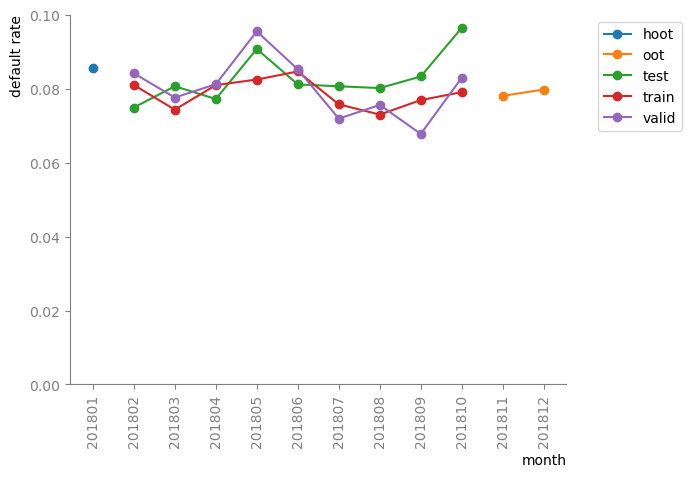

In [15]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

### With Stratification
- Stratification allows us to ensure that in each sample is approximately the same distribution in specified variables

In [16]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
data.loc[data[col_month] <= 201801, 'sample'] = 'hoot'
data.loc[data[col_month] >= 201811, 'sample'] = 'oot'

# define intime mask
intime_mask = (data[col_month] > 201801) & (data[col_month] < 201811)
# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_rest = train_test_split(data[intime_mask], test_size=0.4, random_state = 12, stratify = (data[intime_mask][[col_month, col_target]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[[col_month, col_target]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

In [17]:
data['sample'].value_counts(dropna = False)

train    35829
oot      13475
test     11944
valid    11943
hoot      6809
Name: sample, dtype: int64

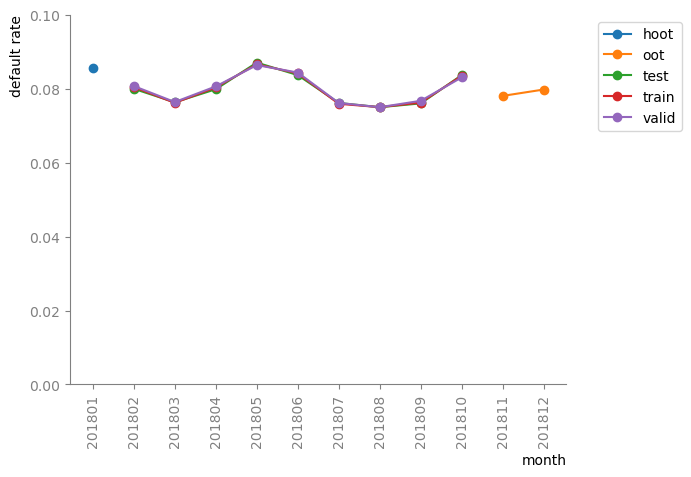

In [18]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

### Define sample masks

In [19]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid')
test_mask = (data['sample'] == 'test')
oot_mask = (data['sample'] == 'oot')
hoot_mask = (data['sample'] == 'hoot')

### Cross-Validation

We never want to evaluate performance on the training sample. We can use use all of the observations for both training and validation - using so-called k-fold cross-validation. We are not using it in this notebook, but it is a useful concept, very often used.

<img src="https://miro.medium.com/max/700/1*AAwIlHM8TpAVe4l2FihNUQ.png" width=500px style="float: center"/>

In [20]:
kf = KFold(n_splits=5)
kf.get_n_splits(data)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [21]:
KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [16000 16001 16002 ... 79997 79998 79999] TEST: [    0     1     2 ... 15997 15998 15999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [16000 16001 16002 ... 31997 31998 31999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [32000 32001 32002 ... 47997 47998 47999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [48000 48001 48002 ... 63997 63998 63999]
TRAIN: [    0     1     2 ... 63997 63998 63999] TEST: [64000 64001 64002 ... 79997 79998 79999]


## Data Cleaning

- We need to get rid of infinities, otherwise many numerical procedures fail

In [22]:
# find columns with infinity values
cols_with_inf = []
for col in cols_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

Column MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_DIV_MEAN_AMTCR_0M_INFM includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_DIV_MEAN_AMTCR_0M_12M includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_ACTIVE includes infinity values.


In [23]:
# replace infinity values
for col in cols_with_inf:
    data[col].replace(np.inf, 9999999, inplace = True)

## Univariate plots

In [24]:
def plot_columns(columns, df):
    for col in columns:
        print('-' * 50)
        print('{}'.format(col.upper()))
        print('-' * 50)
        print('')
        k = int(df[col].nunique())
        
        
        if k < 2:
            print(f'{col} - only constant with value {df[col].unique()}')
        elif (k < 15) or (df[col].dtype == 'O'):
            info = '{:.2f}% is missing'.format(np.mean(df[col].isna()) * 100)
            print(info)
            
            ax = (df[col].value_counts(dropna=False).iloc[0:15] / df[col].shape[0]).plot.bar()
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            for p in ax.patches:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy() 
                _ = ax.annotate('{:.2f}%'.format(height * 100), (x + width/2, y + height + 0.02), ha='center')
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)


            plt.show()
            
        else:
            info = '{:.2f}% above 0'.format(np.mean(np.where(df[col] > 0, 1, 0)) * 100)
            print(info)

            info = '{:.2f}% is missing'.format(np.mean(df[col].isna()) * 100)
            print(info)
            
            ax = df[col].hist(log=True)
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            plt.show()

            ax = df[col].hist(log=False)
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            plt.show()

                

    print('\n')

--------------------------------------------------
TARGET
--------------------------------------------------

0.00% is missing


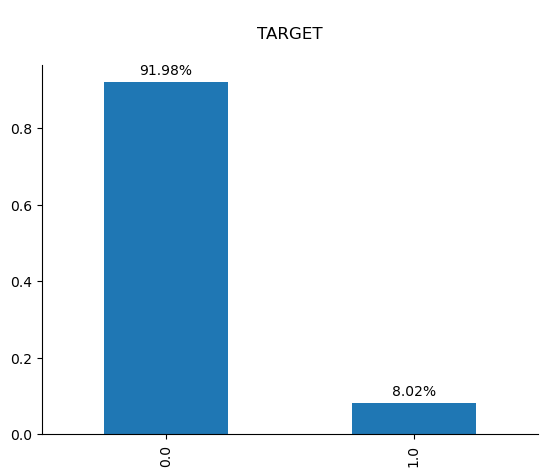

--------------------------------------------------
NAME_CONTRACT_TYPE
--------------------------------------------------

0.00% is missing


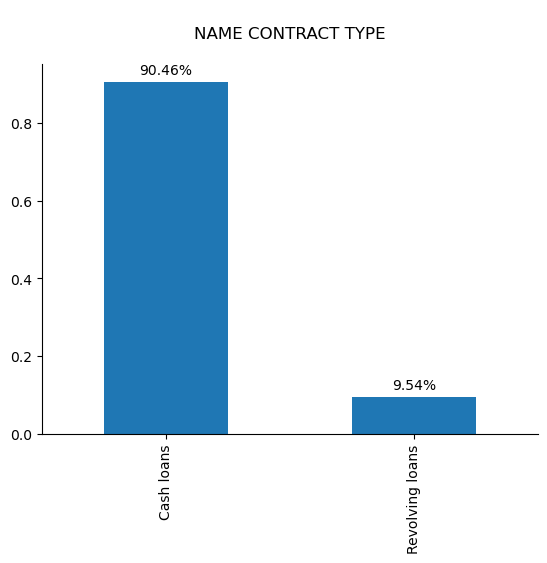

--------------------------------------------------
CODE_GENDER
--------------------------------------------------

0.00% is missing


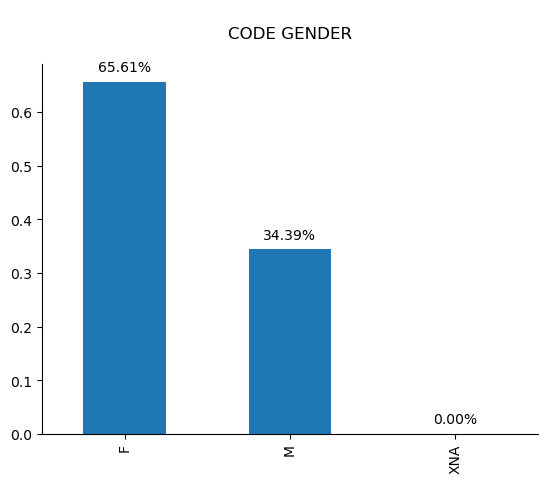

--------------------------------------------------
FLAG_OWN_CAR
--------------------------------------------------

0.00% is missing


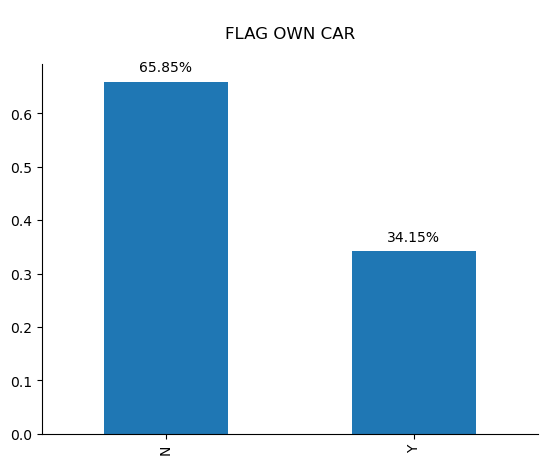

--------------------------------------------------
FLAG_OWN_REALTY
--------------------------------------------------

0.00% is missing


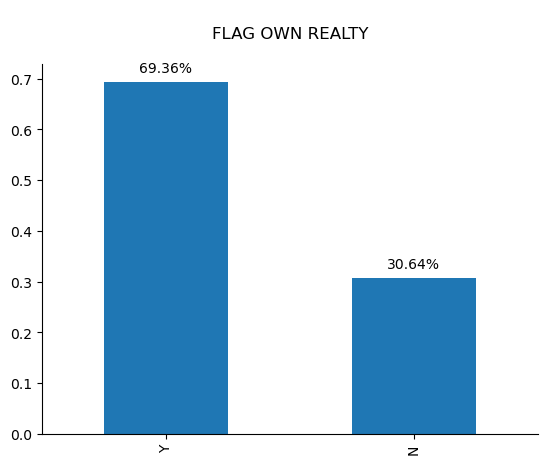

--------------------------------------------------
CNT_CHILDREN
--------------------------------------------------

31.21% is missing


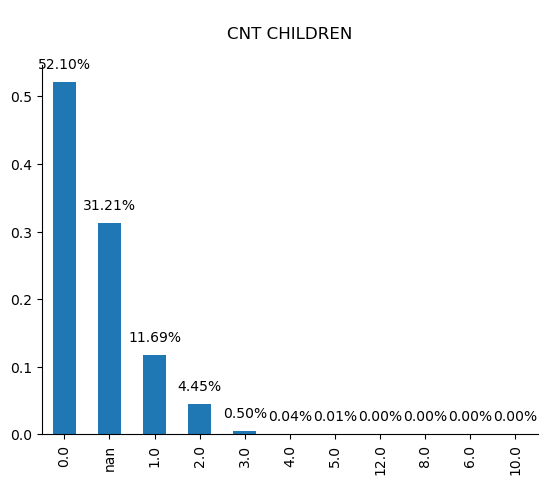

--------------------------------------------------
AMT_INCOME_TOTAL
--------------------------------------------------

100.00% above 0
0.00% is missing


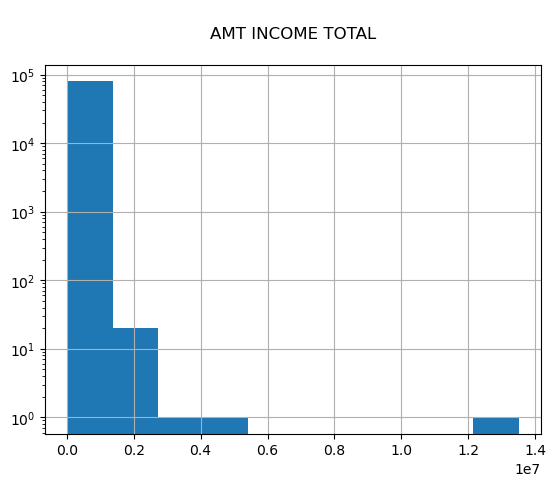

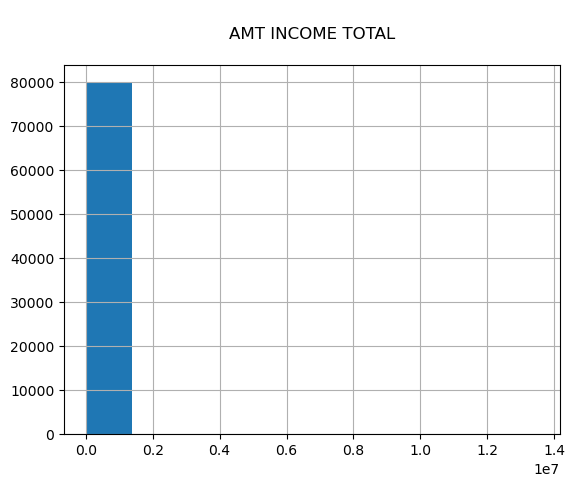

--------------------------------------------------
AMT_CREDIT
--------------------------------------------------

100.00% above 0
0.00% is missing


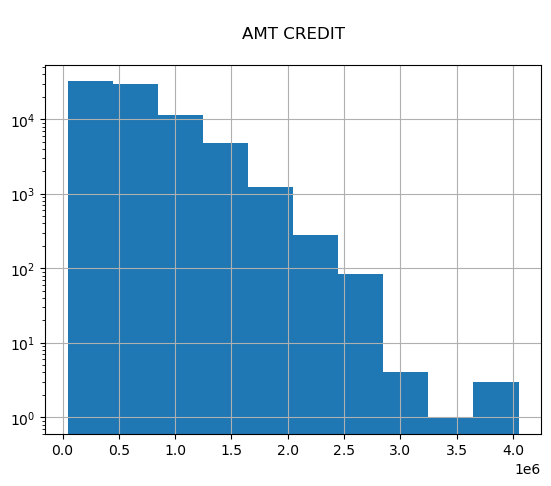

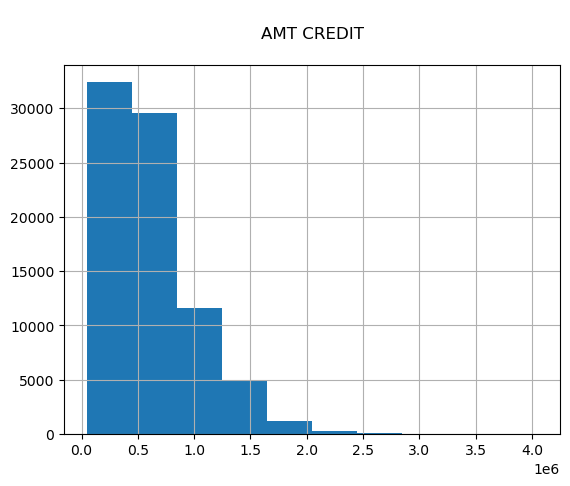

--------------------------------------------------
AMT_ANNUITY
--------------------------------------------------

99.99% above 0
0.01% is missing


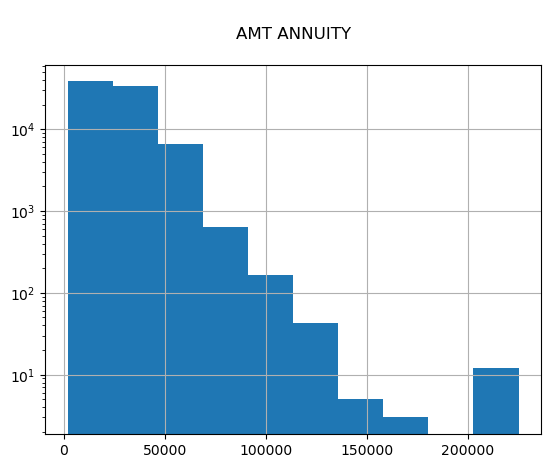

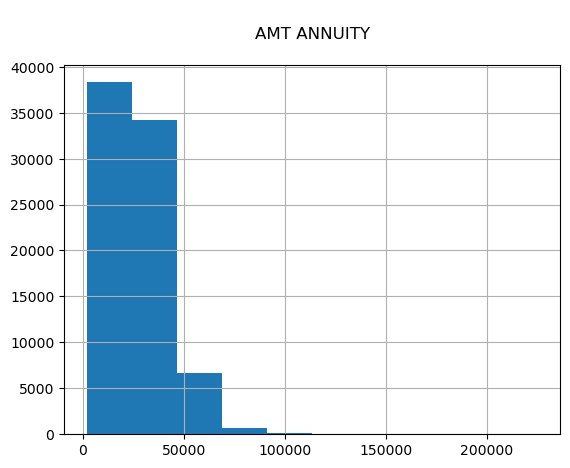

--------------------------------------------------
AMT_GOODS_PRICE
--------------------------------------------------

99.92% above 0
0.08% is missing


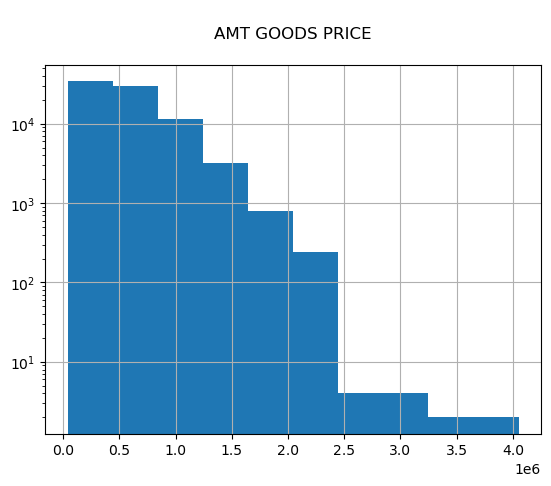

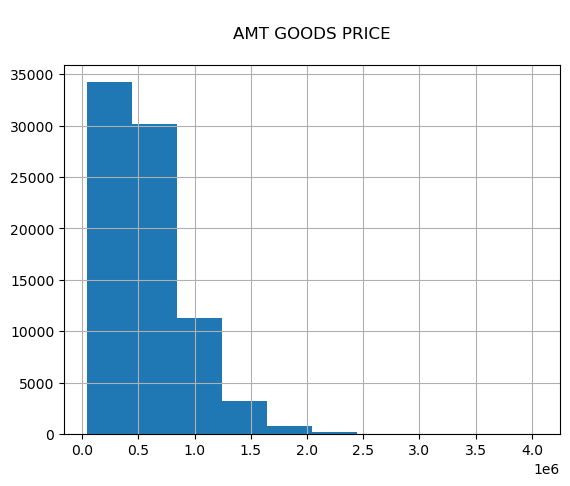

--------------------------------------------------
NAME_TYPE_SUITE
--------------------------------------------------

0.44% is missing


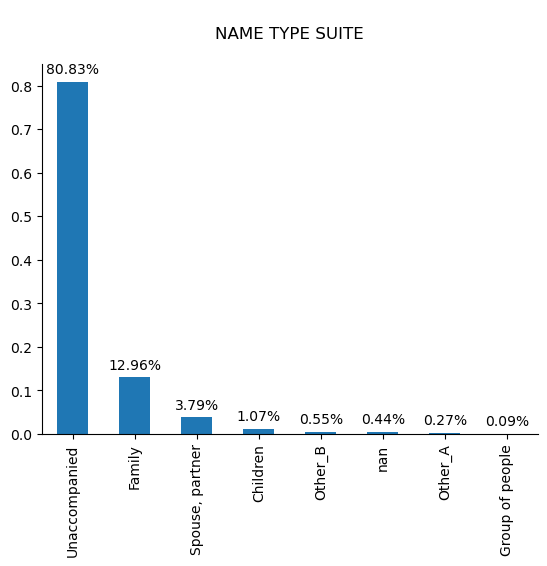

--------------------------------------------------
NAME_INCOME_TYPE
--------------------------------------------------

0.00% is missing


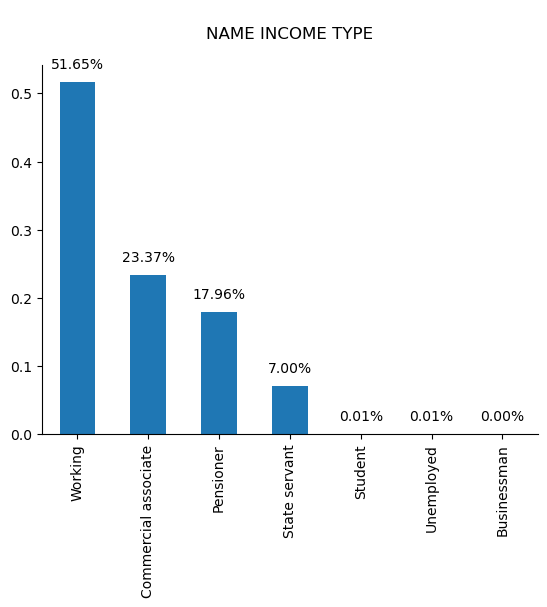

--------------------------------------------------
NAME_EDUCATION_TYPE
--------------------------------------------------

0.00% is missing


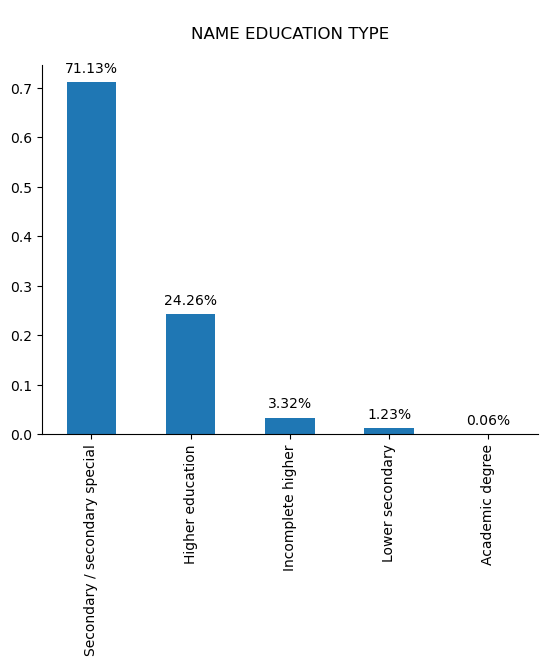

--------------------------------------------------
NAME_FAMILY_STATUS
--------------------------------------------------

0.00% is missing


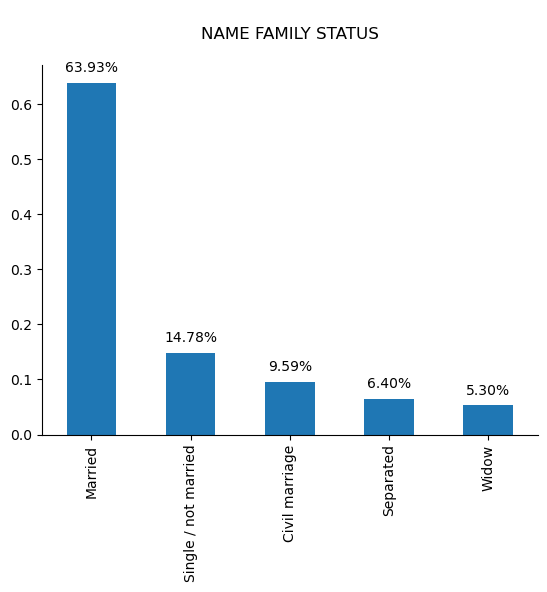

--------------------------------------------------
NAME_HOUSING_TYPE
--------------------------------------------------

0.00% is missing


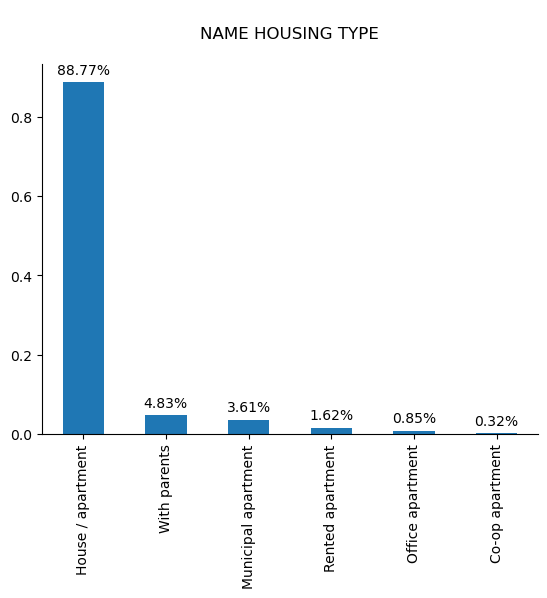

--------------------------------------------------
REGION_POPULATION_RELATIVE
--------------------------------------------------

100.00% above 0
0.00% is missing


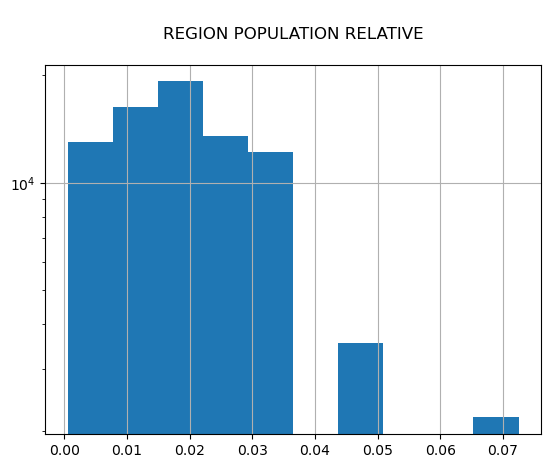

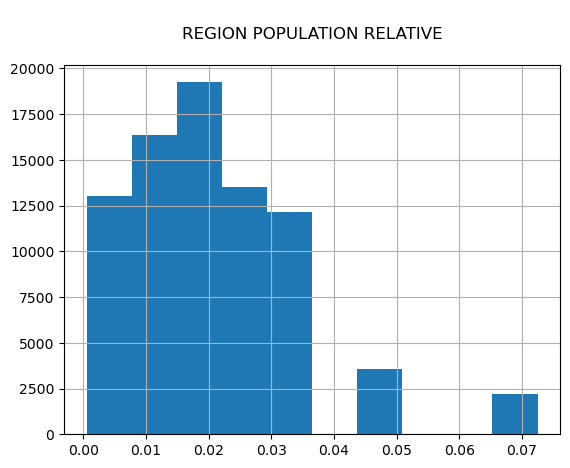

--------------------------------------------------
DAYS_BIRTH
--------------------------------------------------

0.00% above 0
25.27% is missing


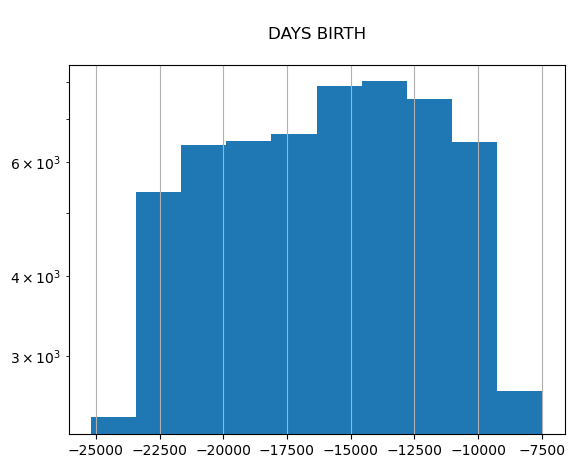

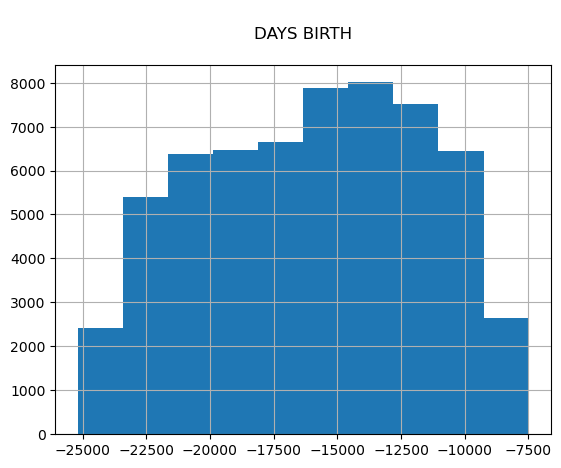

--------------------------------------------------
DAYS_EMPLOYED
--------------------------------------------------

17.96% above 0
0.00% is missing


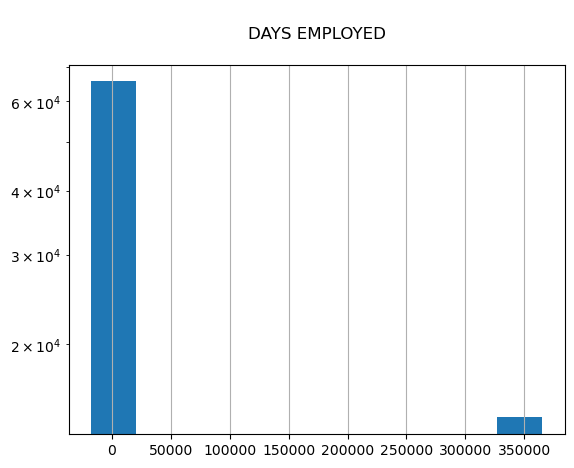

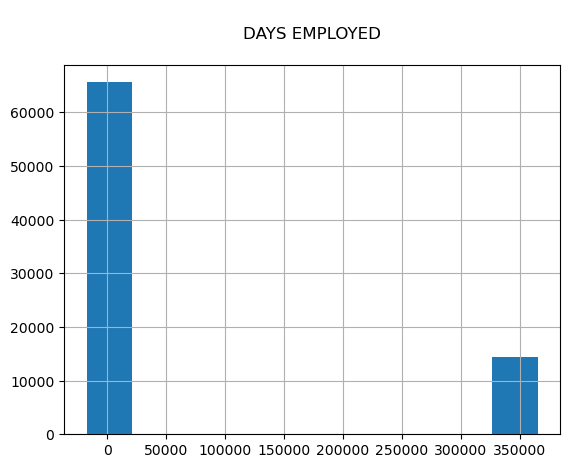

--------------------------------------------------
DAYS_REGISTRATION
--------------------------------------------------

0.00% above 0
0.00% is missing


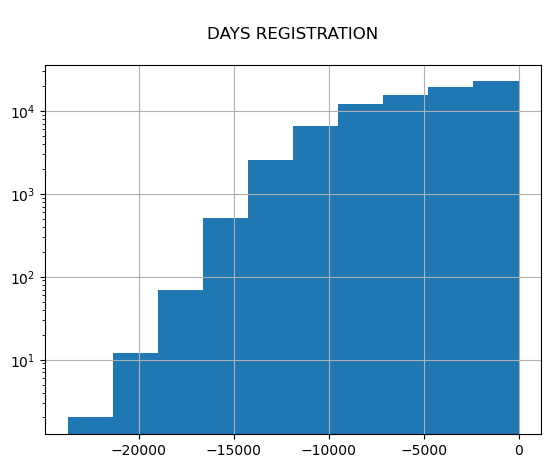

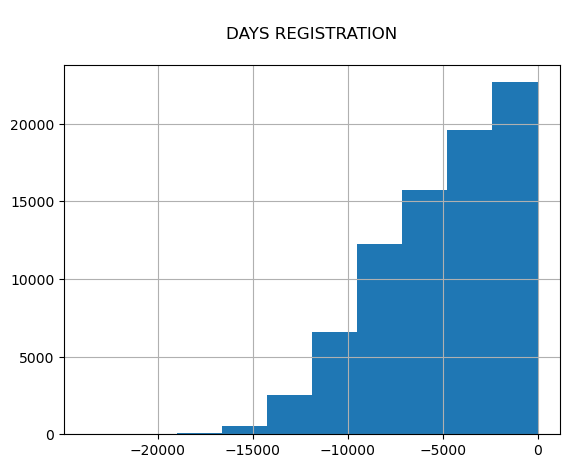

--------------------------------------------------
DAYS_ID_PUBLISH
--------------------------------------------------

0.00% above 0
0.00% is missing


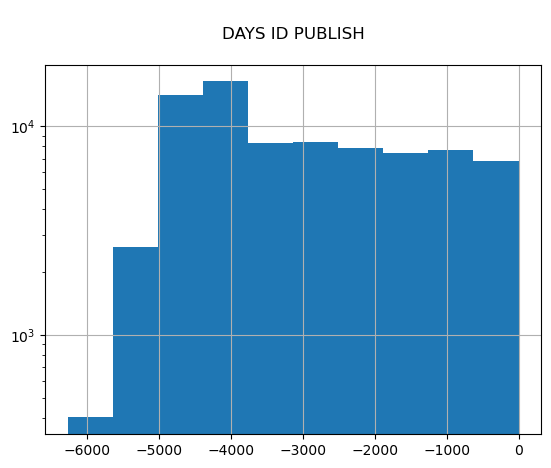

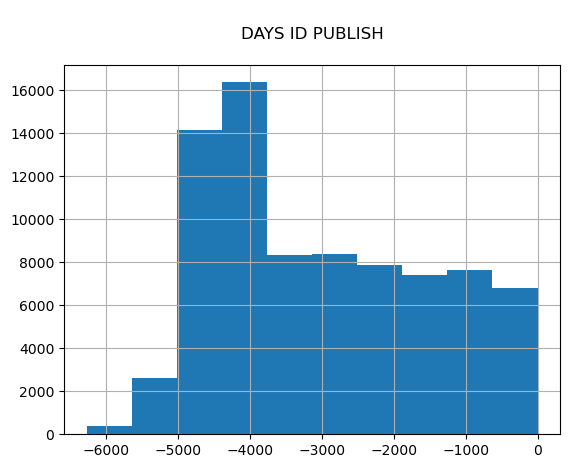

--------------------------------------------------
OWN_CAR_AGE
--------------------------------------------------

33.44% above 0
65.85% is missing


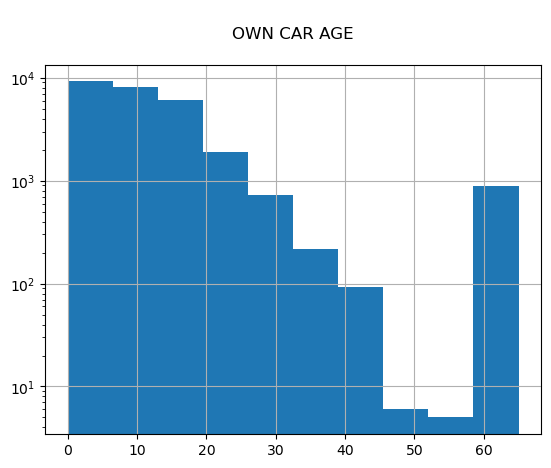

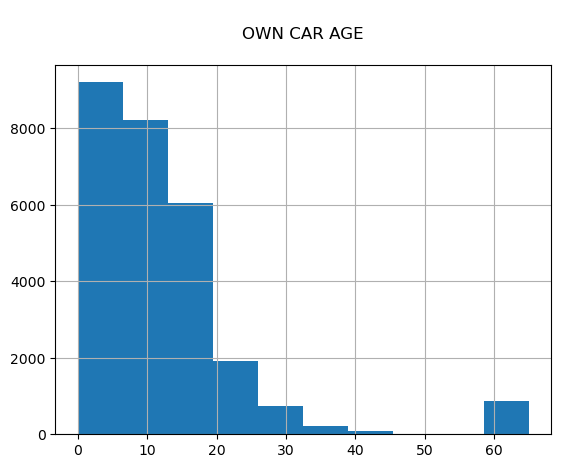

--------------------------------------------------
FLAG_MOBIL
--------------------------------------------------

FLAG_MOBIL - only constant with value [1]
--------------------------------------------------
FLAG_EMP_PHONE
--------------------------------------------------

0.00% is missing


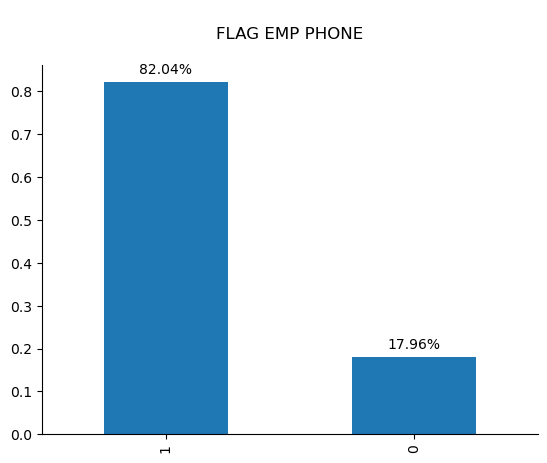

--------------------------------------------------
FLAG_WORK_PHONE
--------------------------------------------------

0.00% is missing


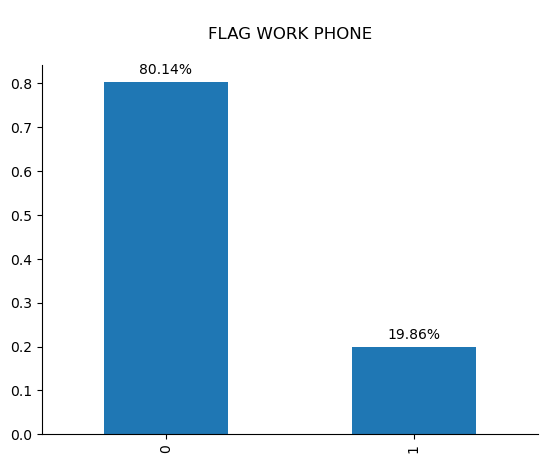

--------------------------------------------------
FLAG_CONT_MOBILE
--------------------------------------------------

0.00% is missing


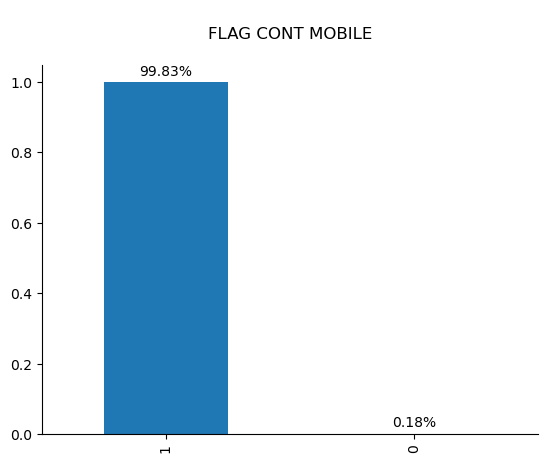

--------------------------------------------------
FLAG_PHONE
--------------------------------------------------

0.00% is missing


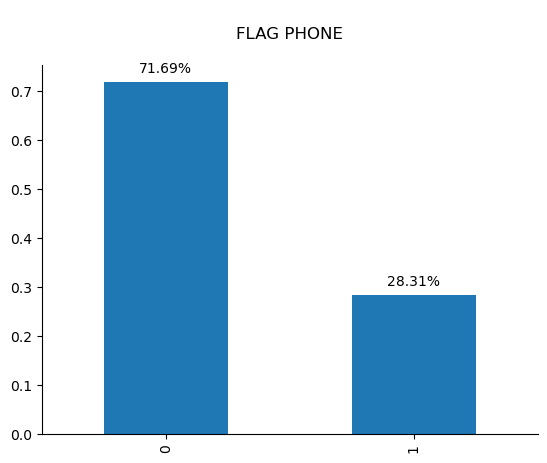

--------------------------------------------------
FLAG_EMAIL
--------------------------------------------------

0.00% is missing


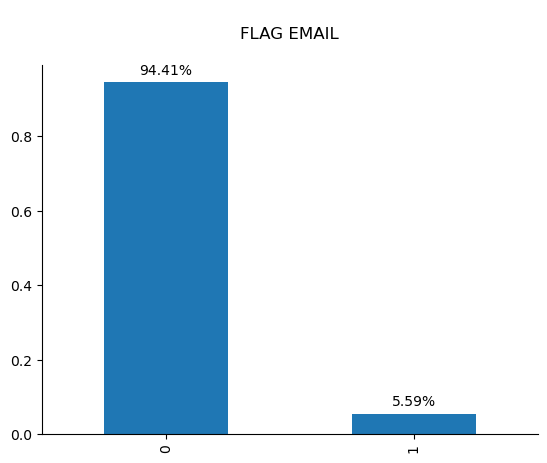

--------------------------------------------------
OCCUPATION_TYPE
--------------------------------------------------

31.33% is missing


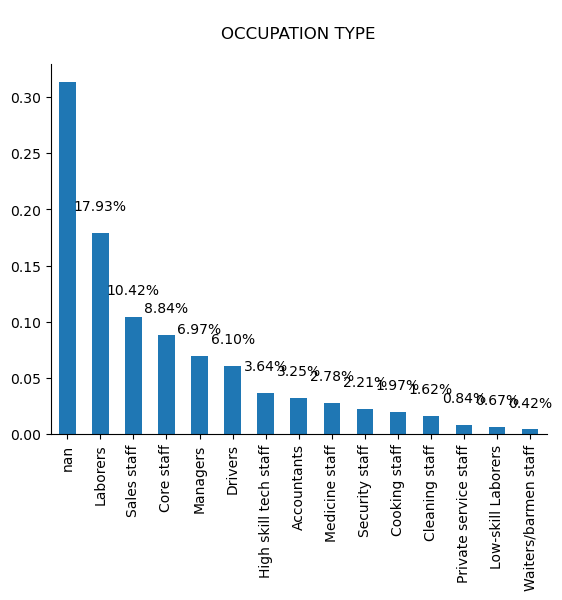

--------------------------------------------------
CNT_FAM_MEMBERS
--------------------------------------------------

0.00% is missing


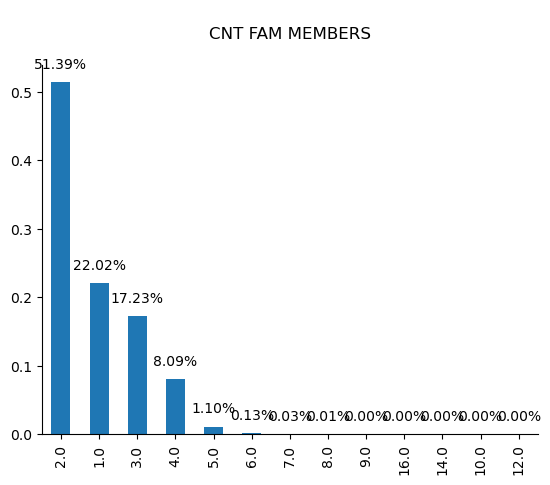

--------------------------------------------------
REGION_RATING_CLIENT
--------------------------------------------------

0.00% is missing


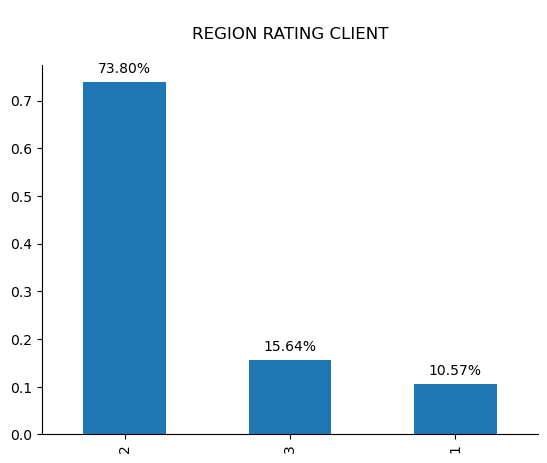

--------------------------------------------------
REGION_RATING_CLIENT_W_CITY
--------------------------------------------------

0.00% is missing


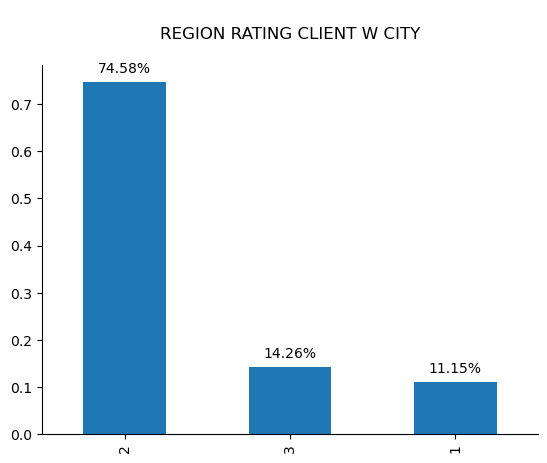

--------------------------------------------------
WEEKDAY_APPR_PROCESS_START
--------------------------------------------------

0.00% is missing


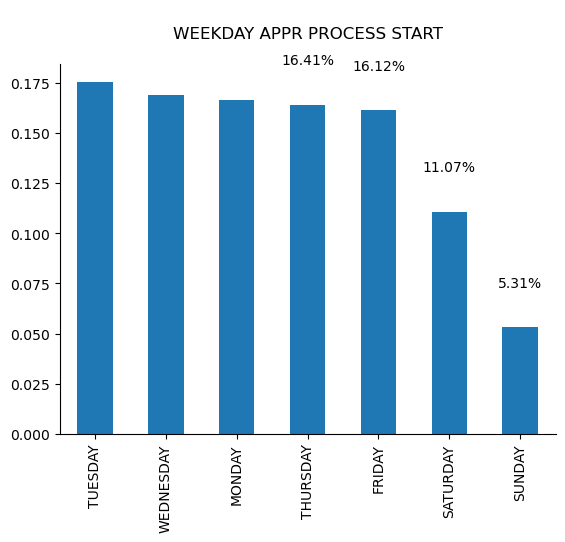

--------------------------------------------------
HOUR_APPR_PROCESS_START
--------------------------------------------------

99.99% above 0
0.00% is missing


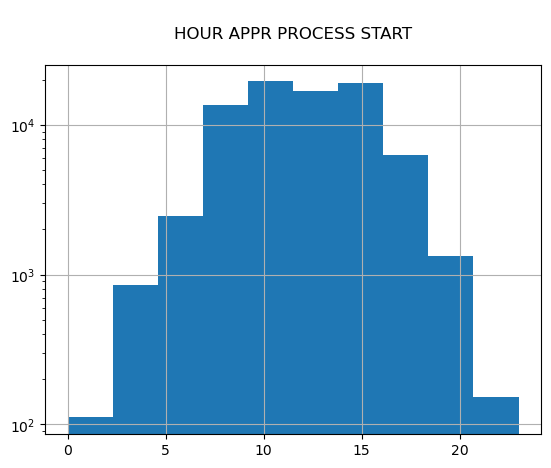

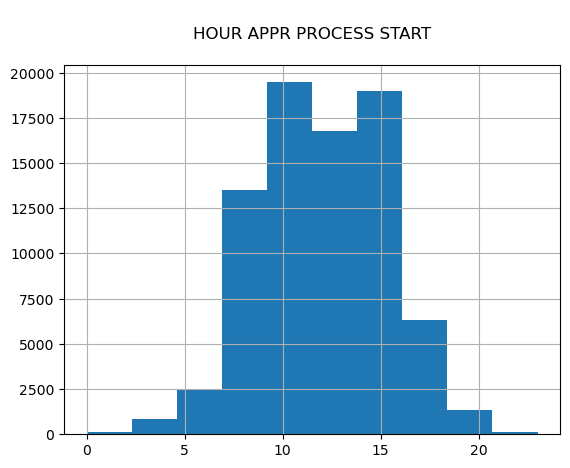

--------------------------------------------------
REG_REGION_NOT_LIVE_REGION
--------------------------------------------------

0.00% is missing


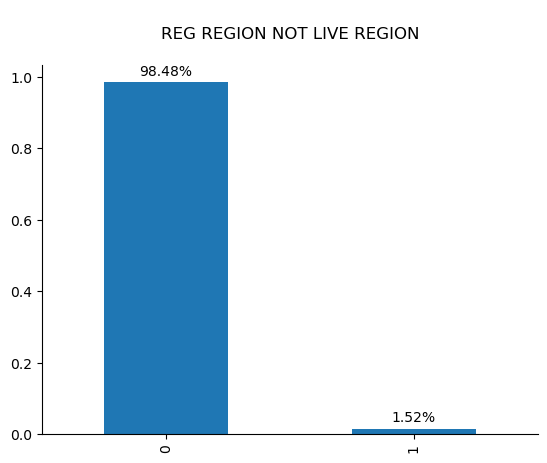

--------------------------------------------------
REG_REGION_NOT_WORK_REGION
--------------------------------------------------

0.00% is missing


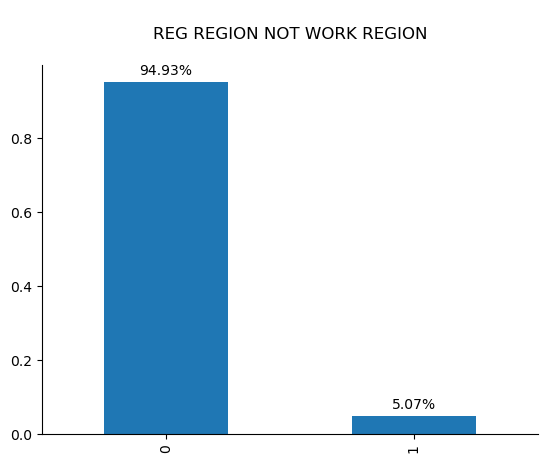

--------------------------------------------------
LIVE_REGION_NOT_WORK_REGION
--------------------------------------------------

0.00% is missing


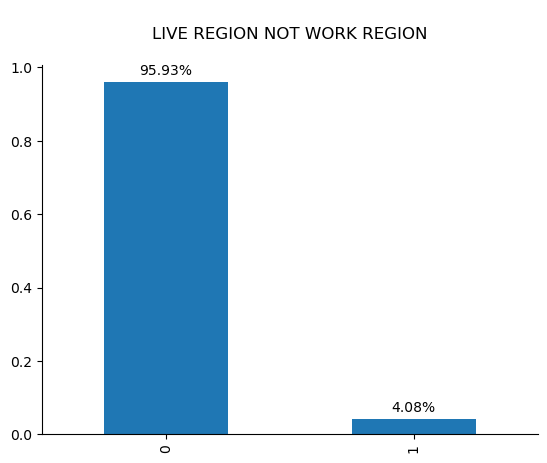

--------------------------------------------------
REG_CITY_NOT_LIVE_CITY
--------------------------------------------------

0.00% is missing


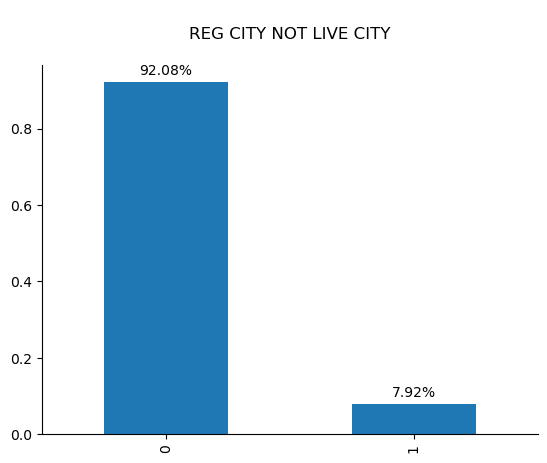

--------------------------------------------------
REG_CITY_NOT_WORK_CITY
--------------------------------------------------

0.00% is missing


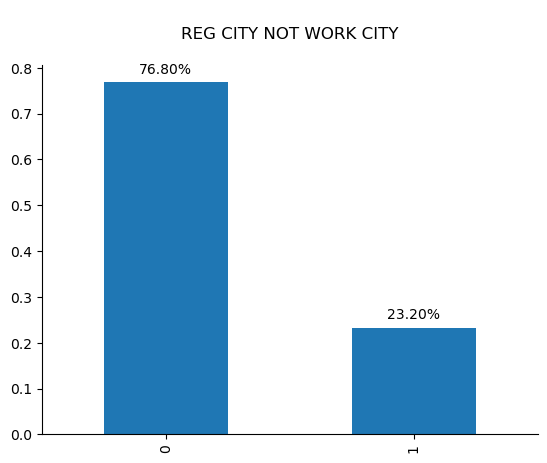

--------------------------------------------------
LIVE_CITY_NOT_WORK_CITY
--------------------------------------------------

0.00% is missing


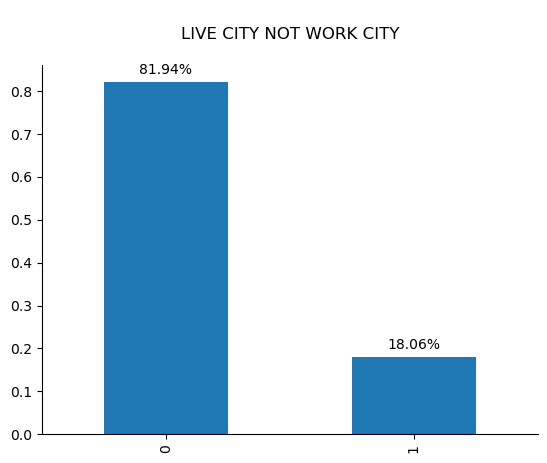

--------------------------------------------------
ORGANIZATION_TYPE
--------------------------------------------------

0.00% is missing


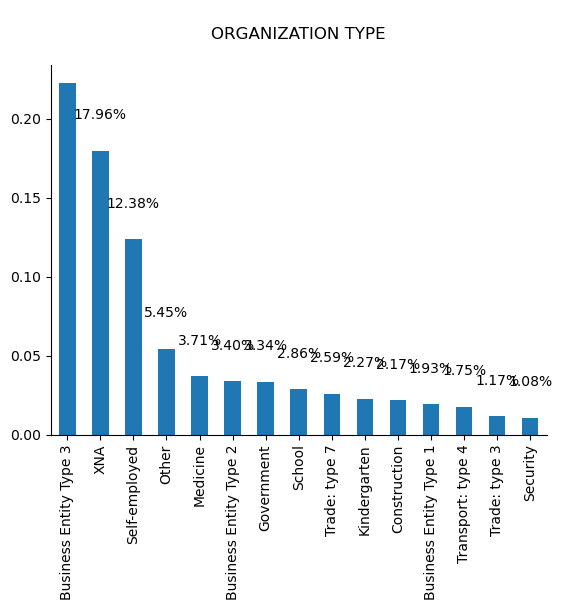

--------------------------------------------------
EXT_SOURCE_1
--------------------------------------------------

43.56% above 0
56.44% is missing


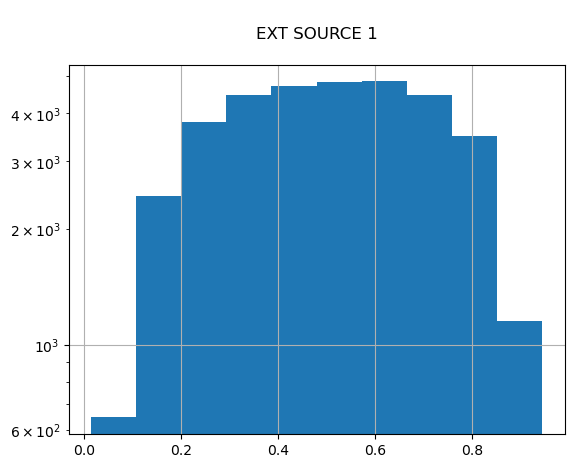

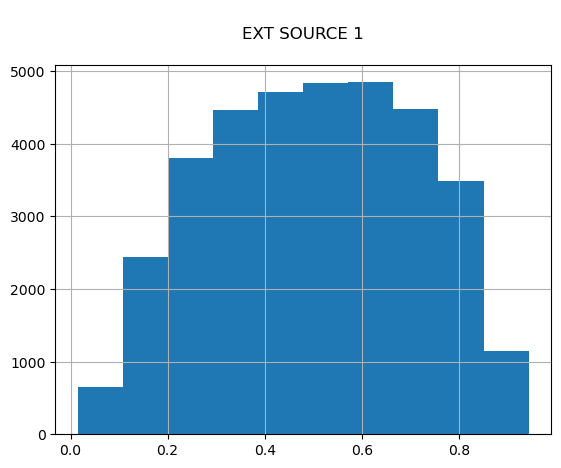

--------------------------------------------------
EXT_SOURCE_2
--------------------------------------------------

99.79% above 0
0.21% is missing


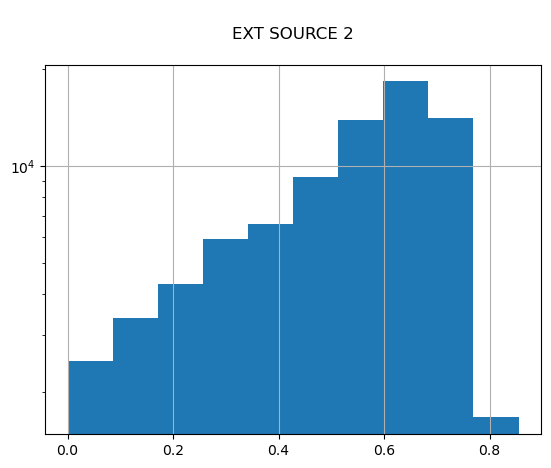

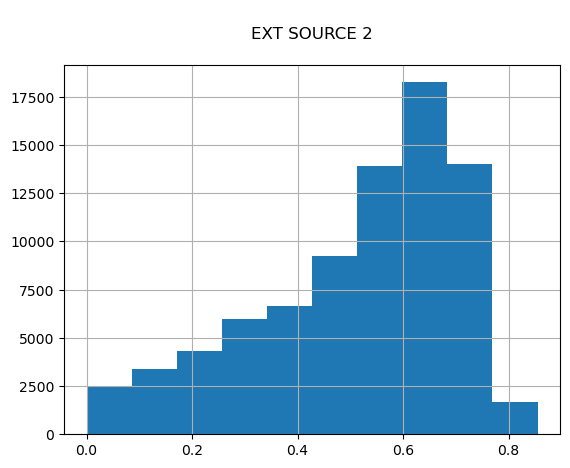

--------------------------------------------------
EXT_SOURCE_3
--------------------------------------------------

80.08% above 0
19.92% is missing


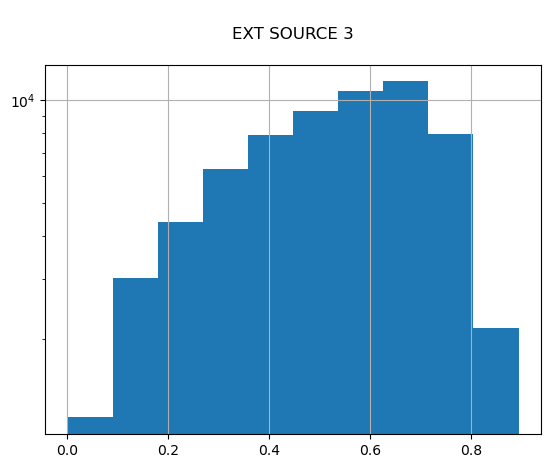

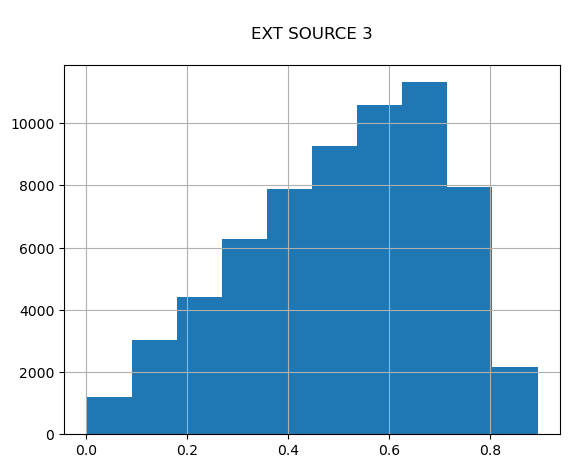

--------------------------------------------------
APARTMENTS_AVG
--------------------------------------------------

49.09% above 0
50.67% is missing


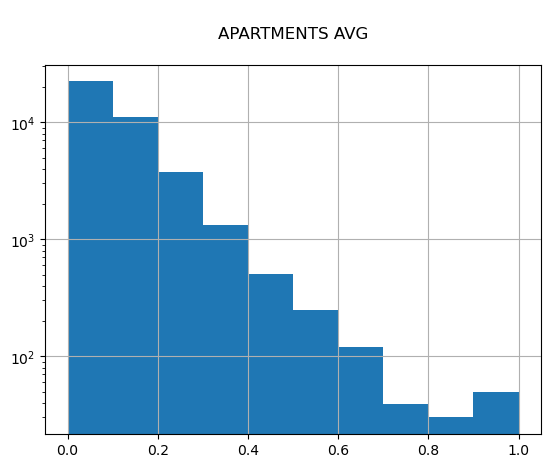

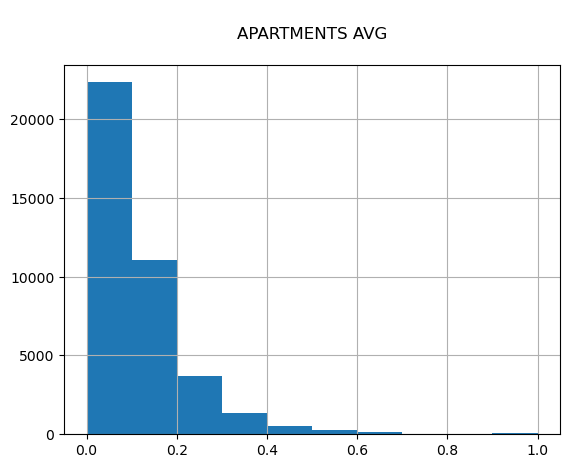

--------------------------------------------------
BASEMENTAREA_AVG
--------------------------------------------------

36.61% above 0
58.52% is missing


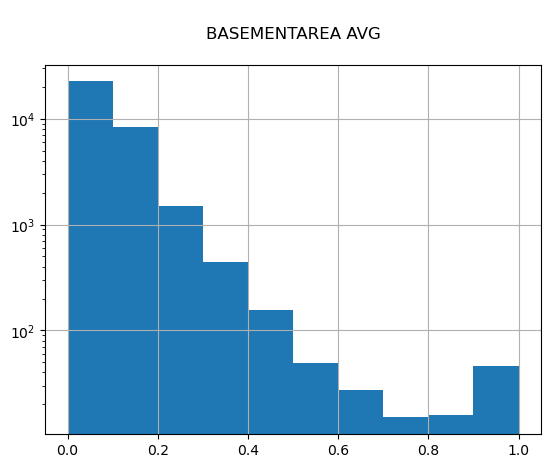

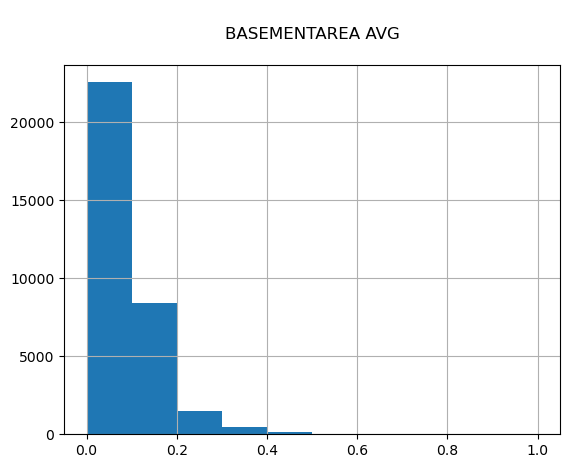

--------------------------------------------------
YEARS_BEGINEXPLUATATION_AVG
--------------------------------------------------

51.05% above 0
48.79% is missing


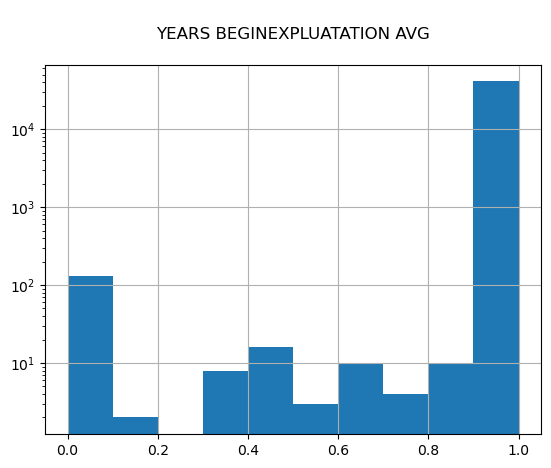

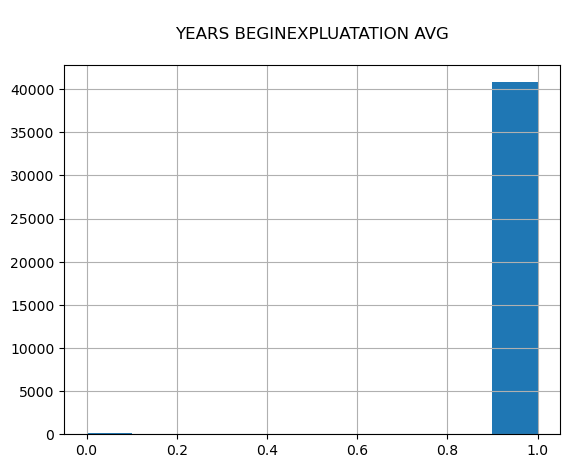

--------------------------------------------------
YEARS_BUILD_AVG
--------------------------------------------------

33.27% above 0
66.70% is missing


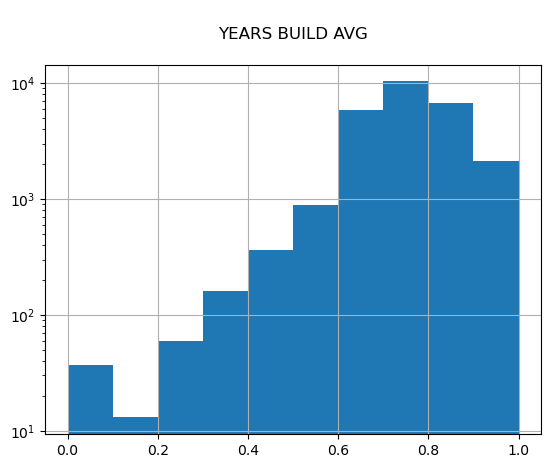

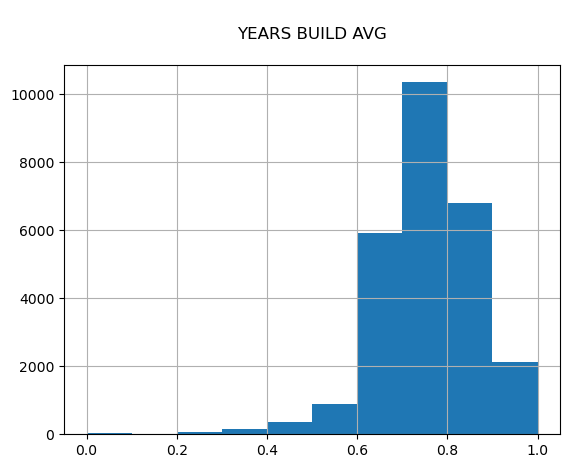

--------------------------------------------------
COMMONAREA_AVG
--------------------------------------------------

27.14% above 0
70.08% is missing


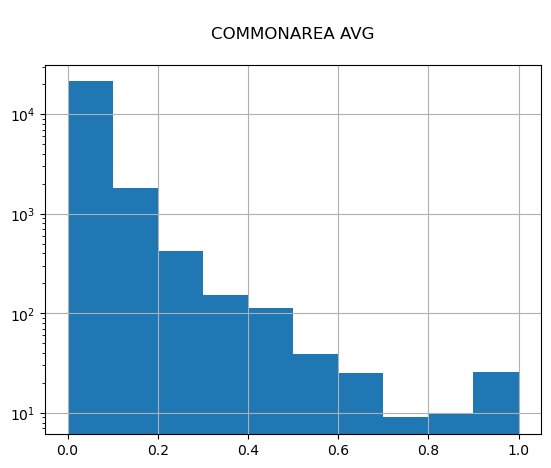

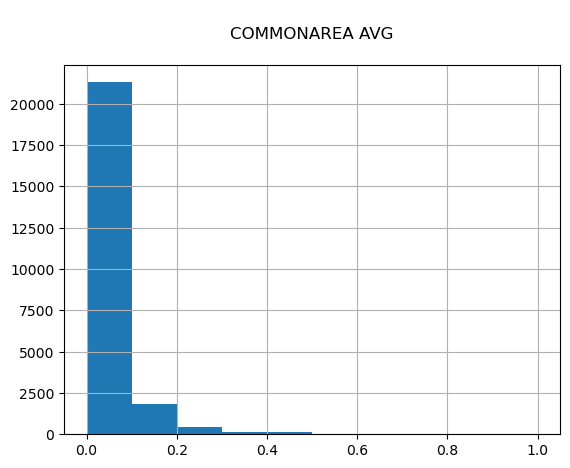

--------------------------------------------------
ELEVATORS_AVG
--------------------------------------------------

18.75% above 0
53.23% is missing


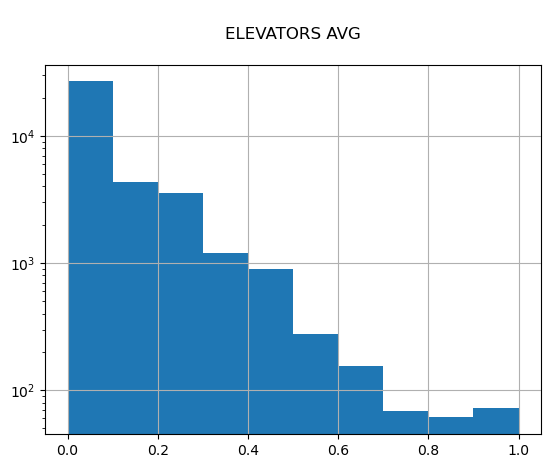

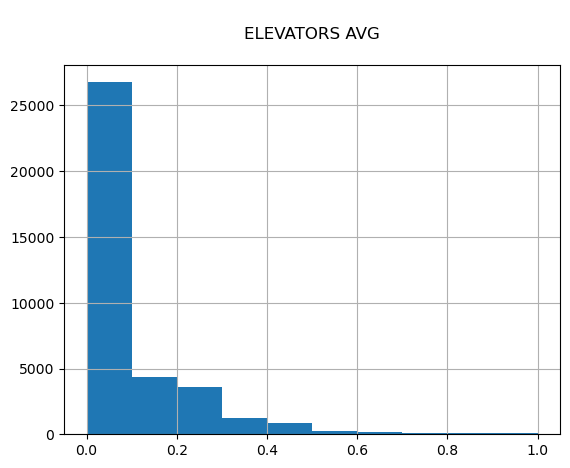

--------------------------------------------------
ENTRANCES_AVG
--------------------------------------------------

49.58% above 0
50.32% is missing


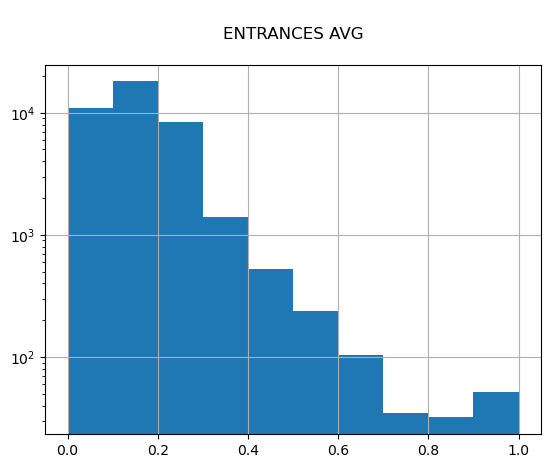

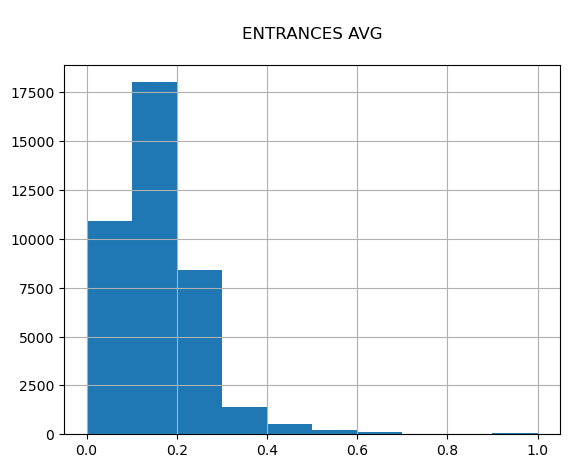

--------------------------------------------------
FLOORSMAX_AVG
--------------------------------------------------

49.30% above 0
49.72% is missing


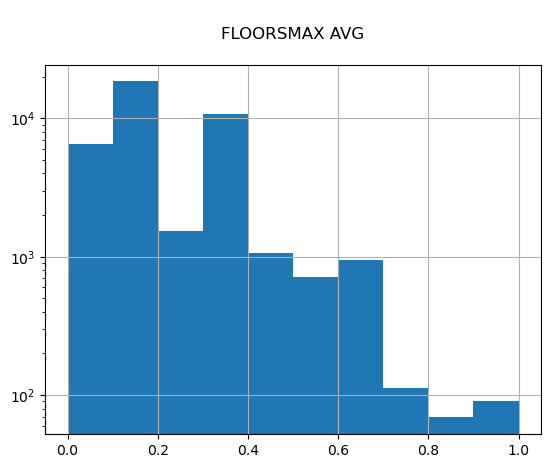

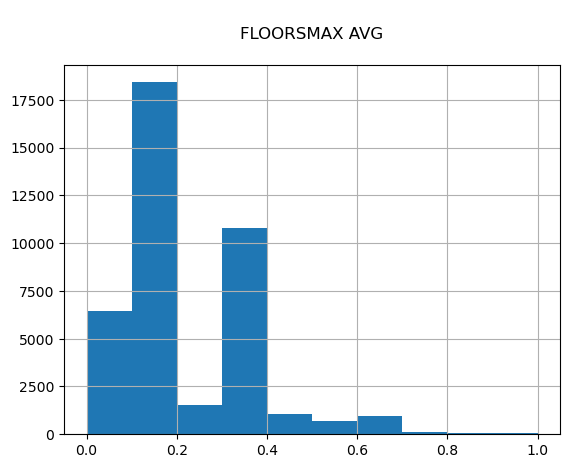

--------------------------------------------------
FLOORSMIN_AVG
--------------------------------------------------

31.23% above 0
68.01% is missing


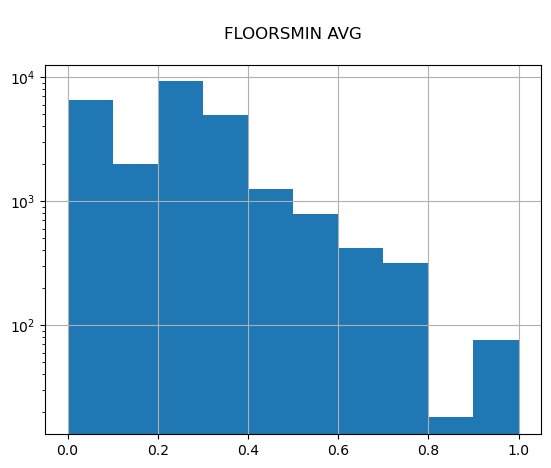

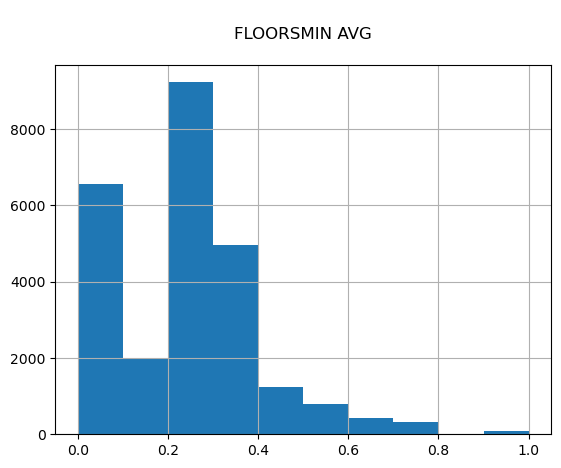

--------------------------------------------------
LANDAREA_AVG
--------------------------------------------------

35.42% above 0
59.41% is missing


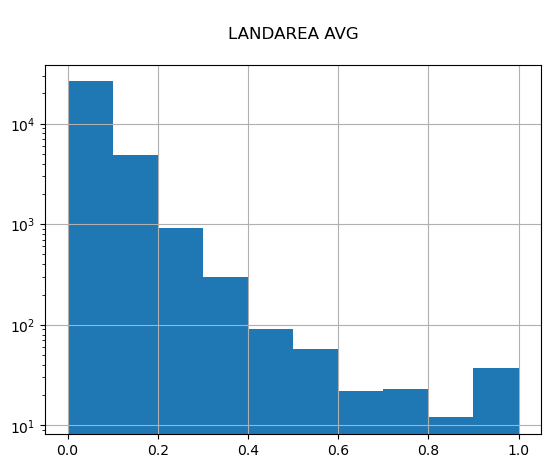

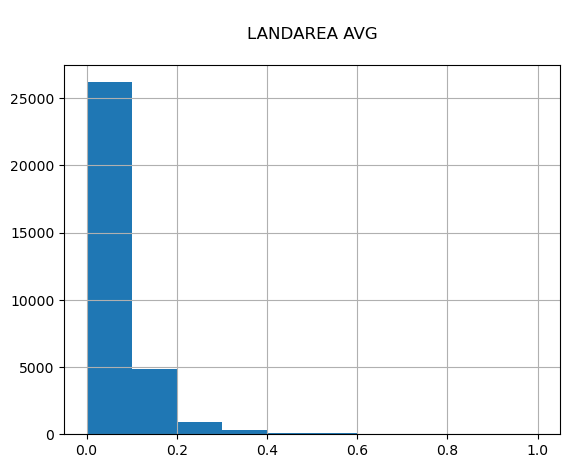

--------------------------------------------------
LIVINGAPARTMENTS_AVG
--------------------------------------------------

31.40% above 0
68.47% is missing


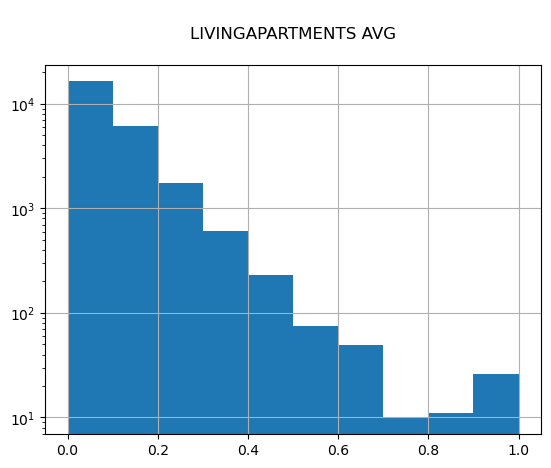

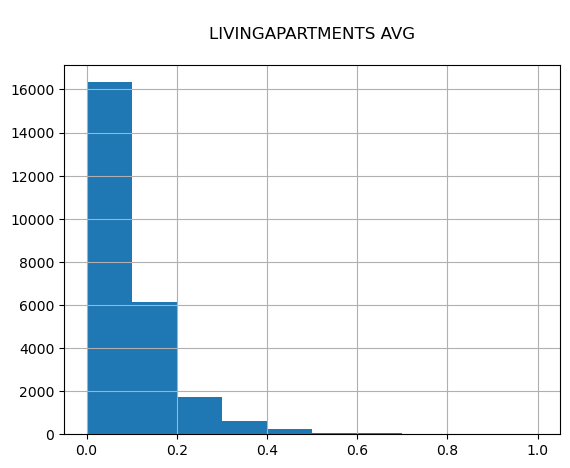

--------------------------------------------------
LIVINGAREA_AVG
--------------------------------------------------

49.73% above 0
50.17% is missing


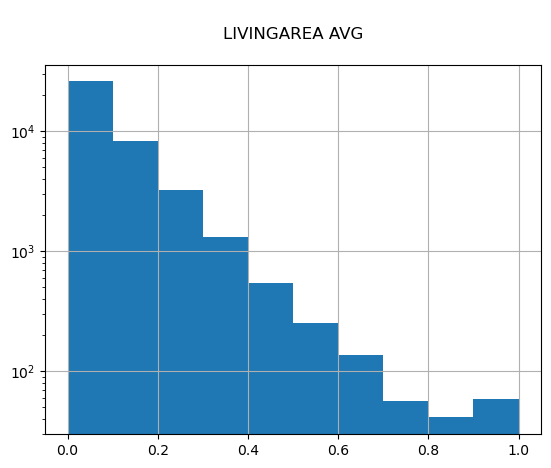

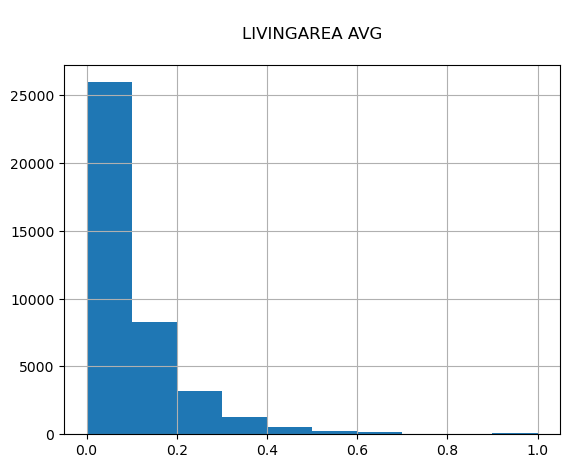

--------------------------------------------------
NONLIVINGAPARTMENTS_AVG
--------------------------------------------------

12.61% above 0
69.58% is missing


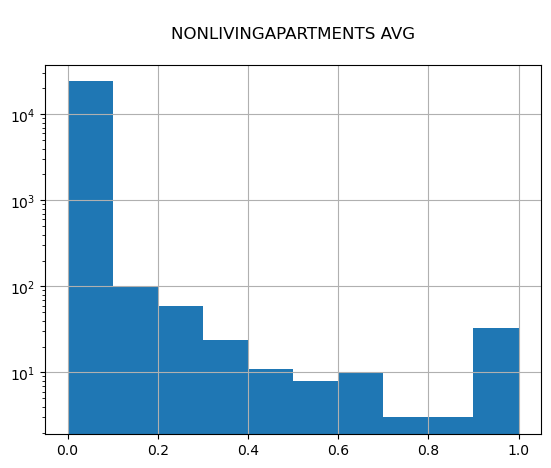

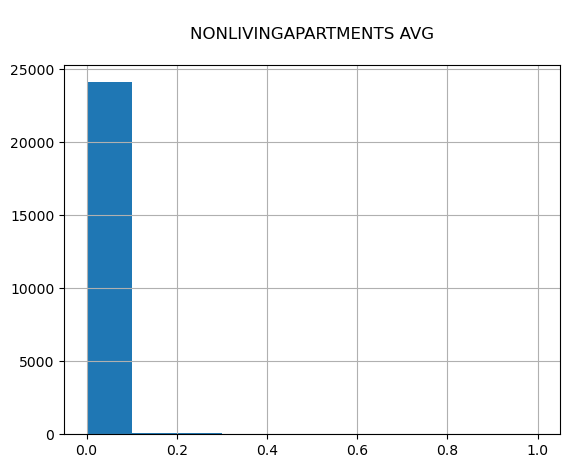

--------------------------------------------------
NONLIVINGAREA_AVG
--------------------------------------------------

25.64% above 0
55.13% is missing


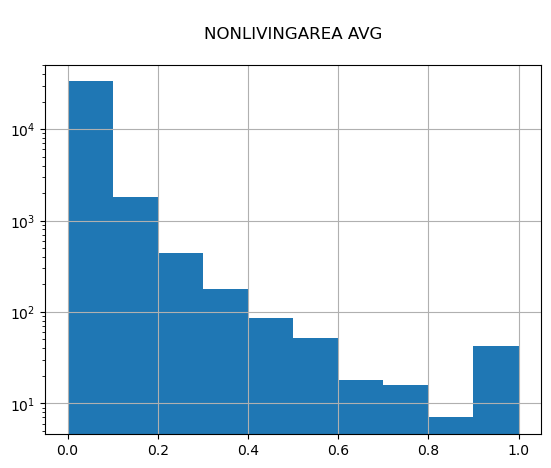

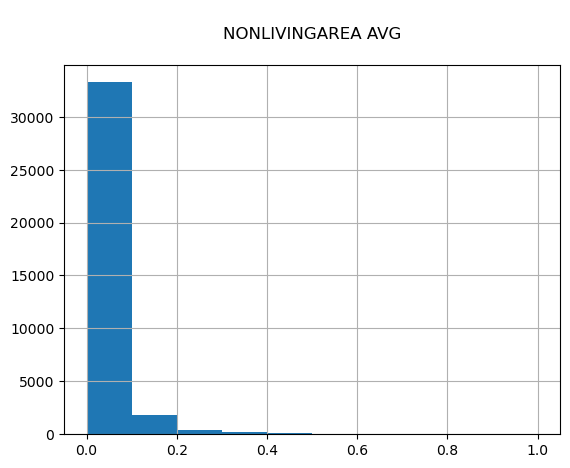

--------------------------------------------------
APARTMENTS_MODE
--------------------------------------------------

49.03% above 0
50.67% is missing


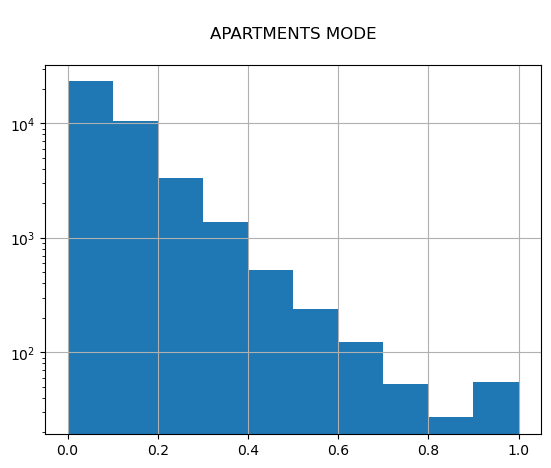

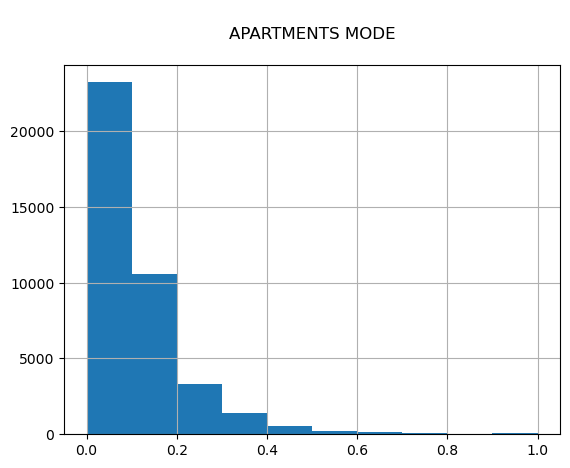

--------------------------------------------------
BASEMENTAREA_MODE
--------------------------------------------------

35.98% above 0
58.52% is missing


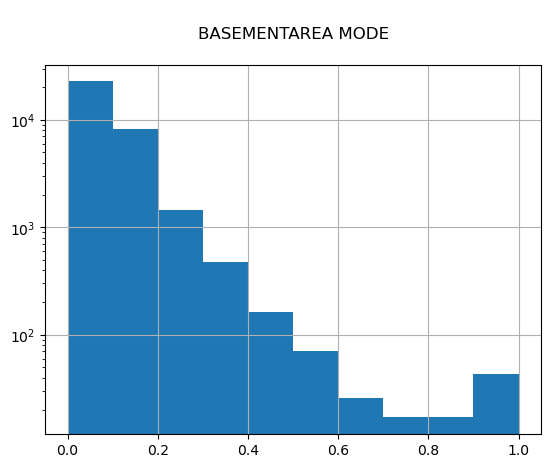

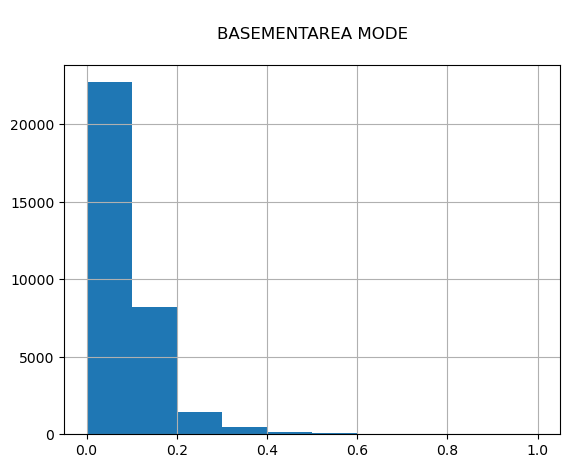

--------------------------------------------------
YEARS_BEGINEXPLUATATION_MODE
--------------------------------------------------

51.18% above 0
48.79% is missing


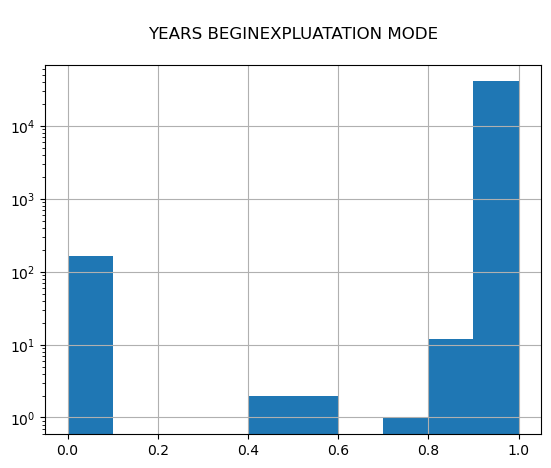

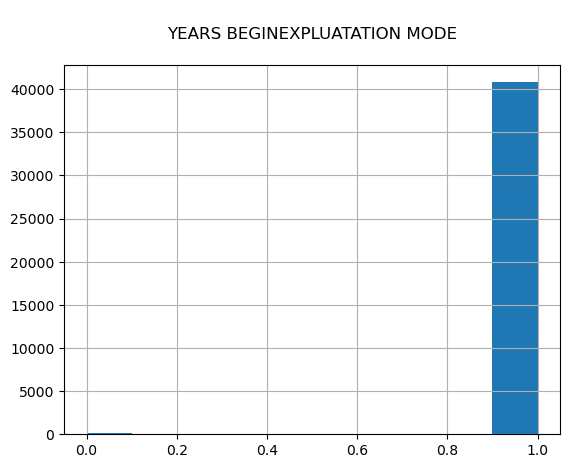

--------------------------------------------------
YEARS_BUILD_MODE
--------------------------------------------------

33.27% above 0
66.70% is missing


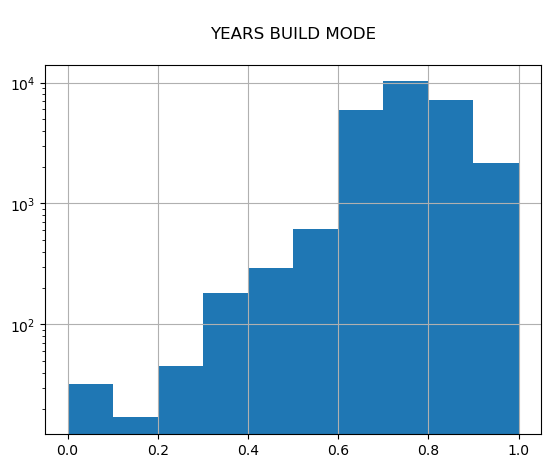

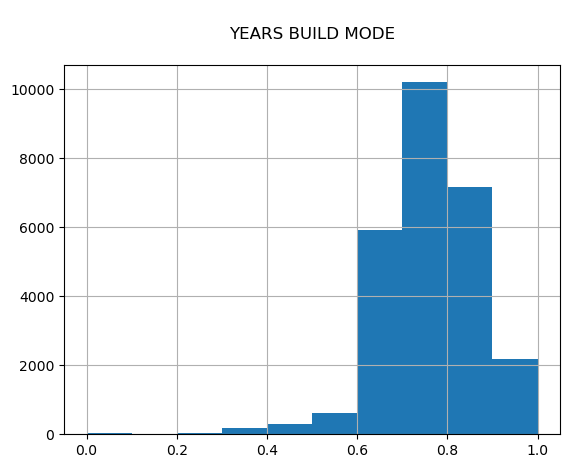

--------------------------------------------------
COMMONAREA_MODE
--------------------------------------------------

26.78% above 0
70.08% is missing


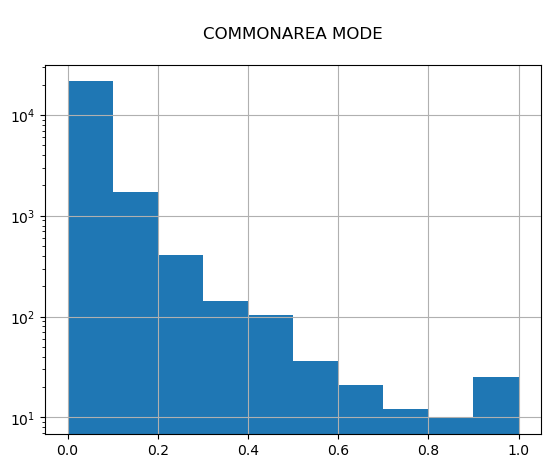

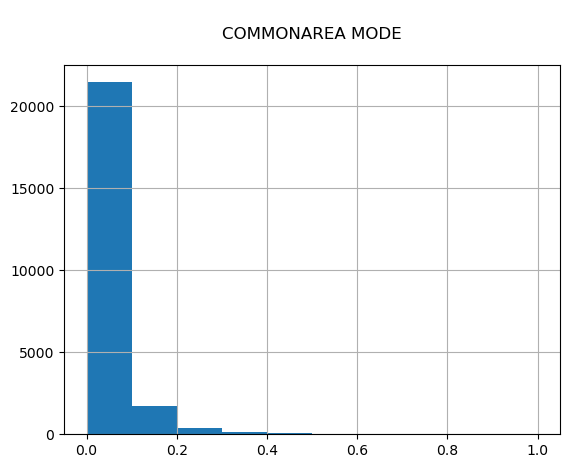

--------------------------------------------------
ELEVATORS_MODE
--------------------------------------------------

17.49% above 0
53.23% is missing


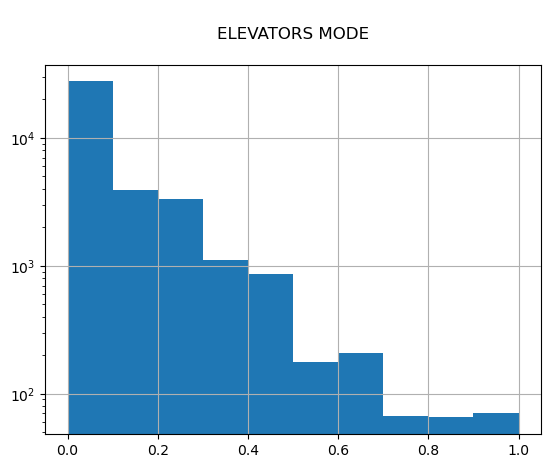

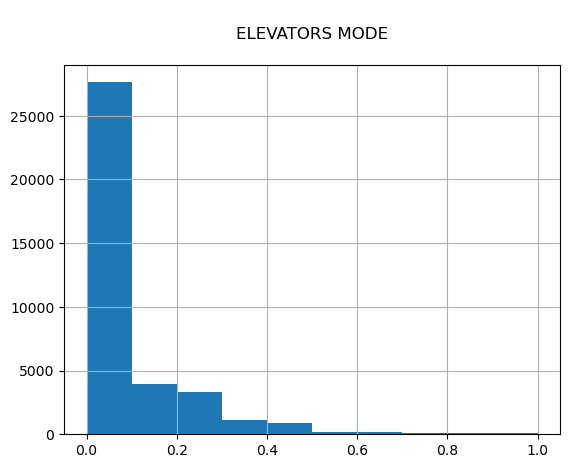

--------------------------------------------------
ENTRANCES_MODE
--------------------------------------------------

49.56% above 0
50.32% is missing


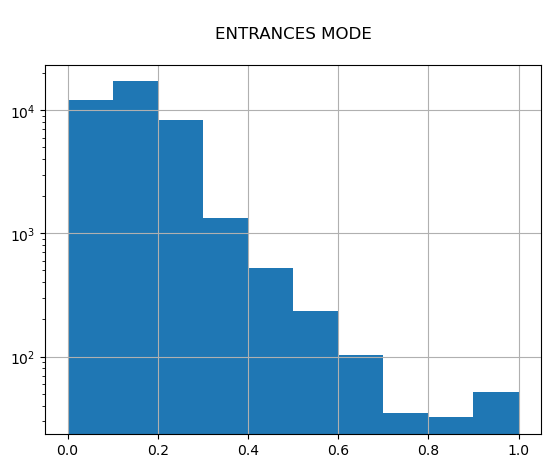

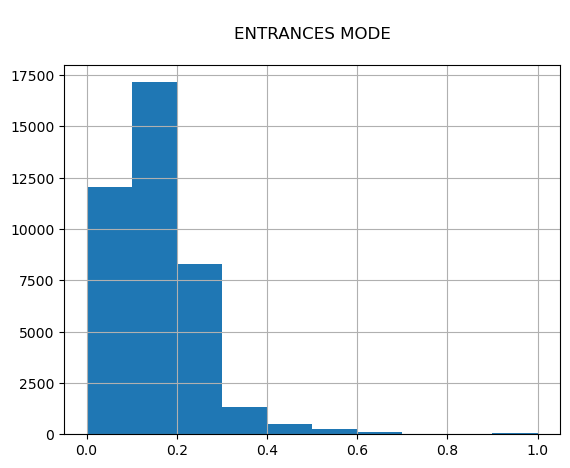

--------------------------------------------------
FLOORSMAX_MODE
--------------------------------------------------

49.15% above 0
49.72% is missing


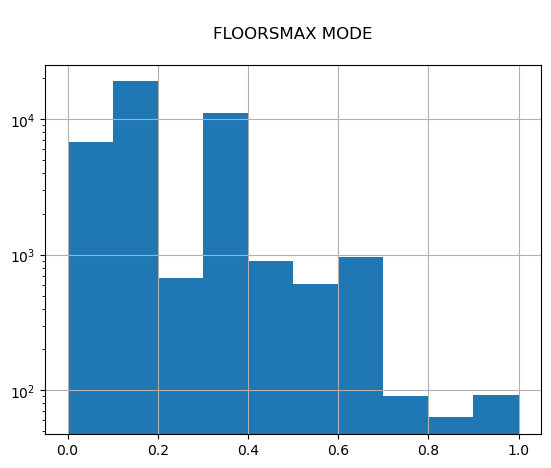

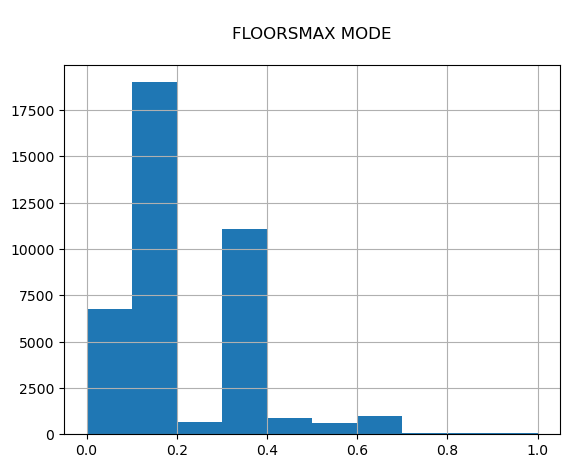

--------------------------------------------------
FLOORSMIN_MODE
--------------------------------------------------

31.18% above 0
68.01% is missing


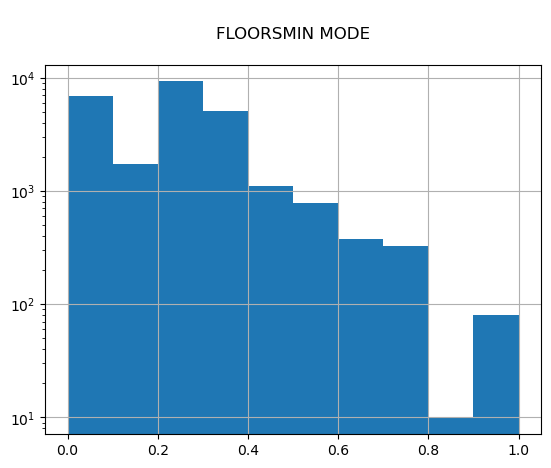

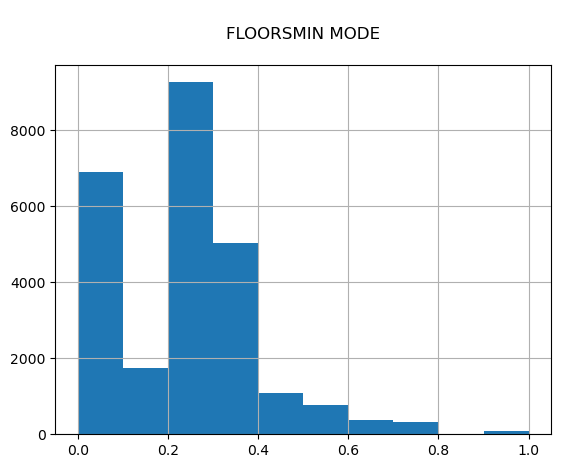

--------------------------------------------------
LANDAREA_MODE
--------------------------------------------------

34.81% above 0
59.41% is missing


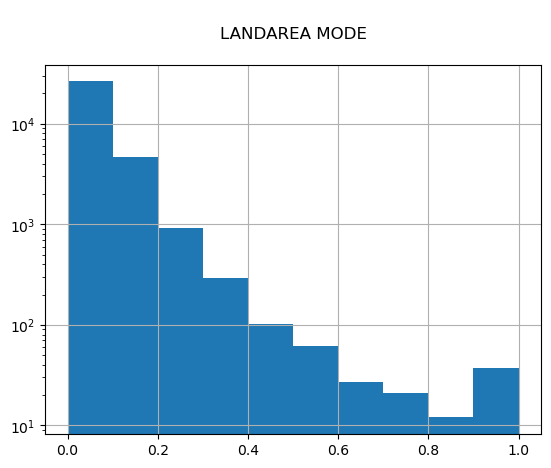

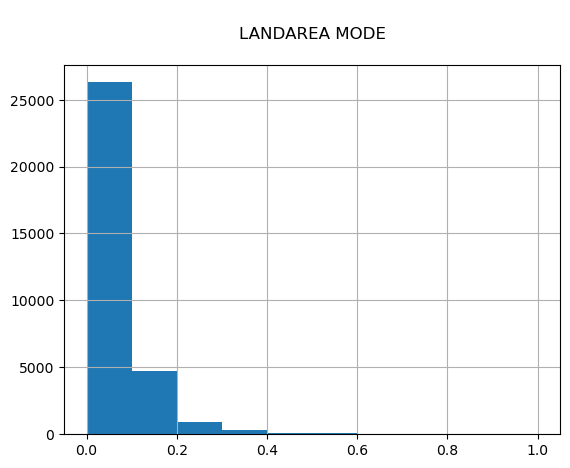

--------------------------------------------------
LIVINGAPARTMENTS_MODE
--------------------------------------------------

31.37% above 0
68.47% is missing


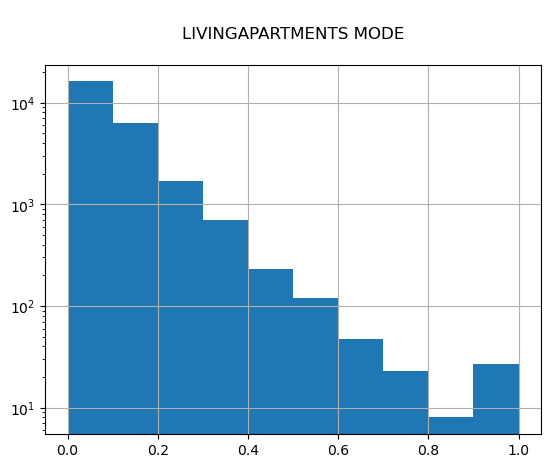

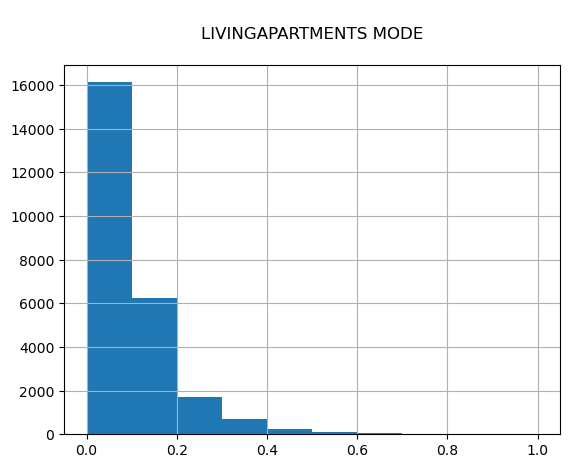

--------------------------------------------------
LIVINGAREA_MODE
--------------------------------------------------

49.68% above 0
50.17% is missing


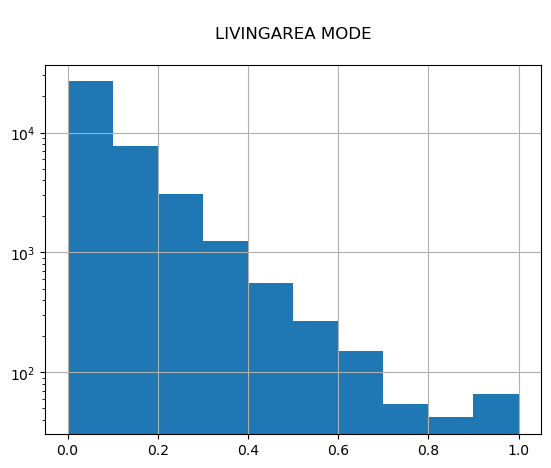

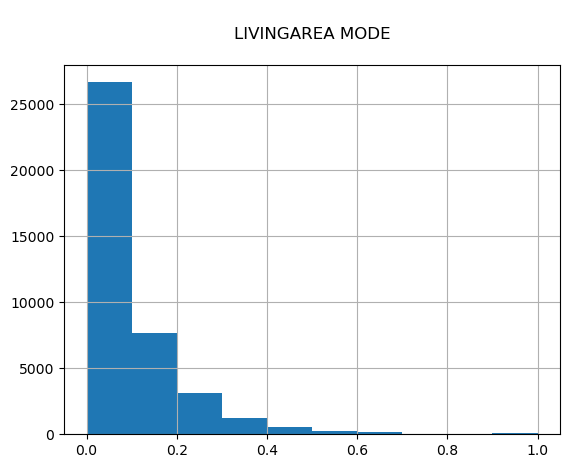

--------------------------------------------------
NONLIVINGAPARTMENTS_MODE
--------------------------------------------------

11.09% above 0
69.58% is missing


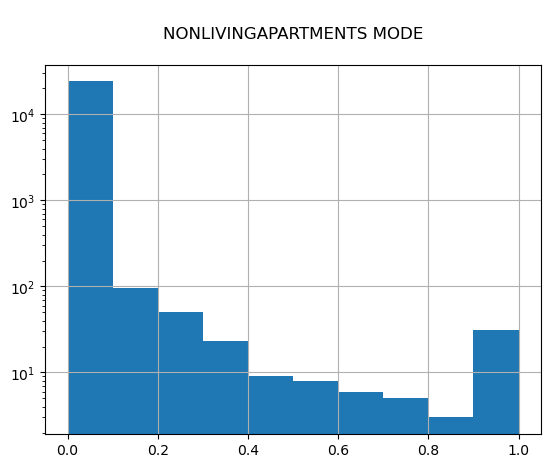

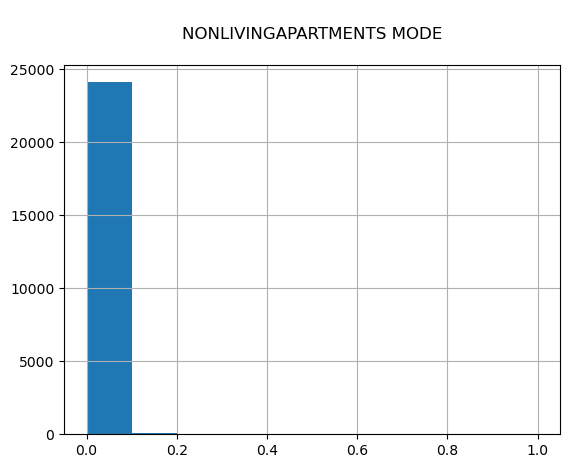

--------------------------------------------------
NONLIVINGAREA_MODE
--------------------------------------------------

22.93% above 0
55.13% is missing


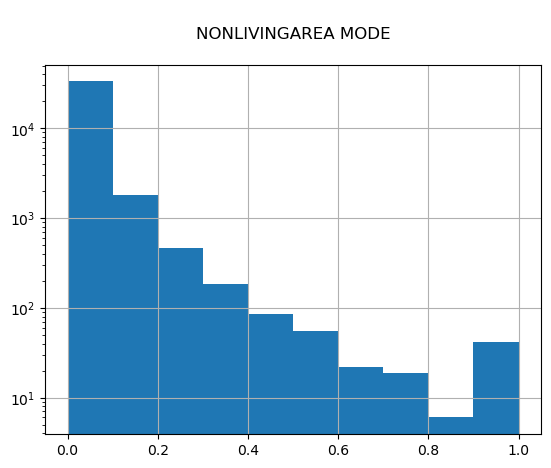

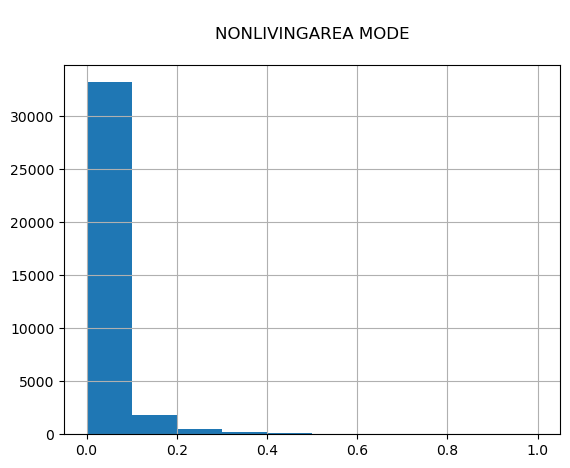

--------------------------------------------------
APARTMENTS_MEDI
--------------------------------------------------

49.09% above 0
50.67% is missing


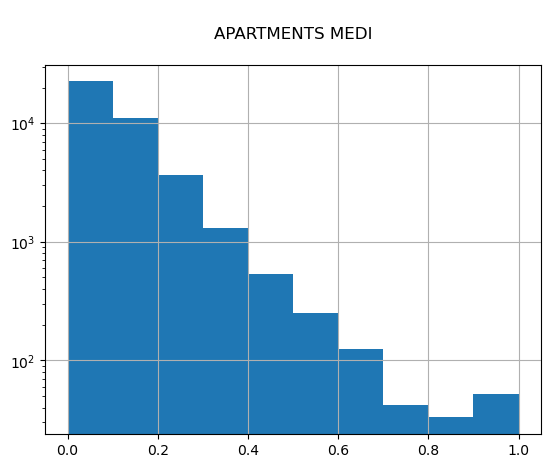

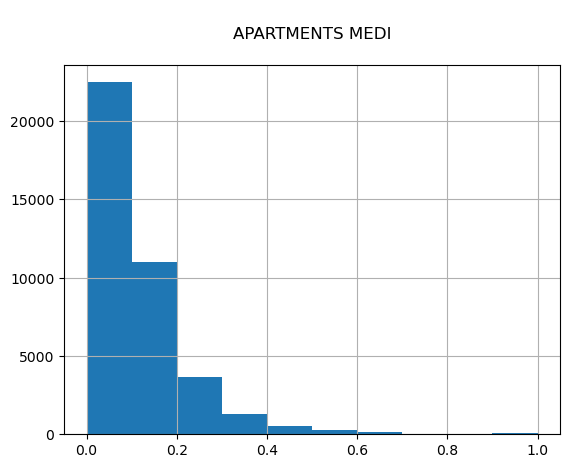

--------------------------------------------------
BASEMENTAREA_MEDI
--------------------------------------------------

36.54% above 0
58.52% is missing


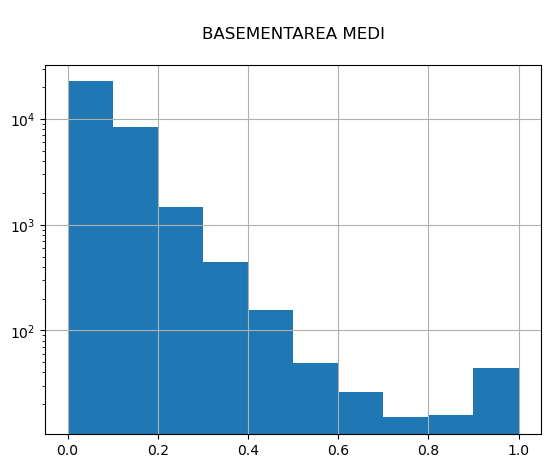

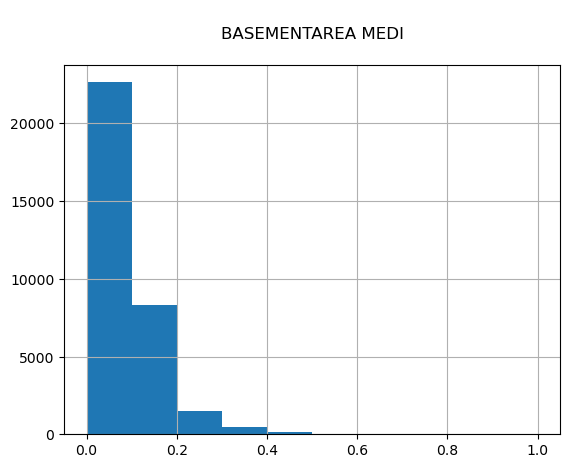

--------------------------------------------------
YEARS_BEGINEXPLUATATION_MEDI
--------------------------------------------------

51.04% above 0
48.79% is missing


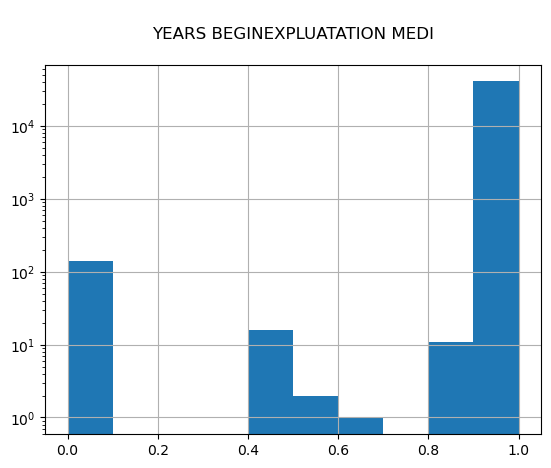

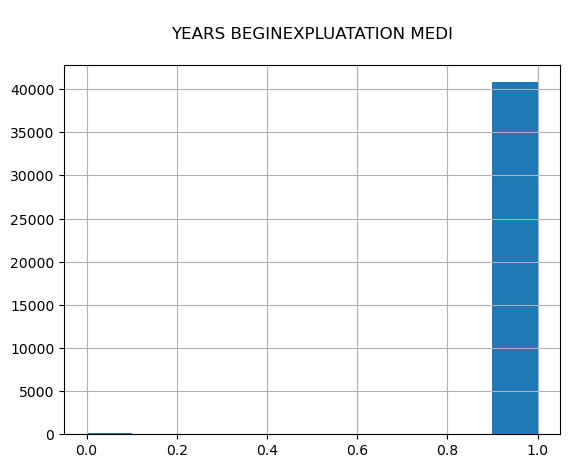

--------------------------------------------------
YEARS_BUILD_MEDI
--------------------------------------------------

33.27% above 0
66.70% is missing


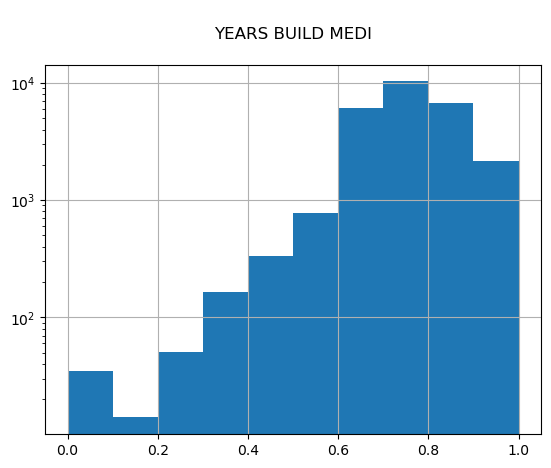

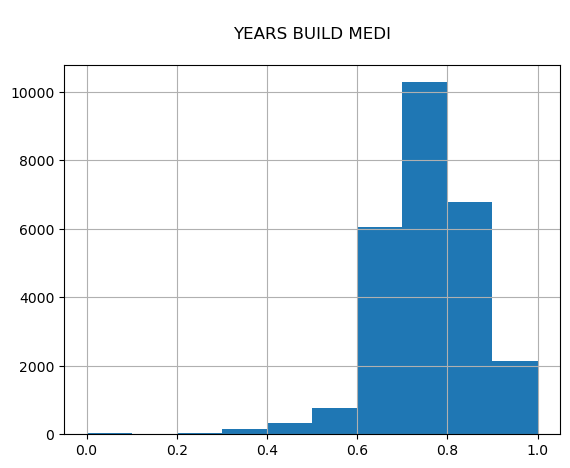

--------------------------------------------------
COMMONAREA_MEDI
--------------------------------------------------

27.08% above 0
70.08% is missing


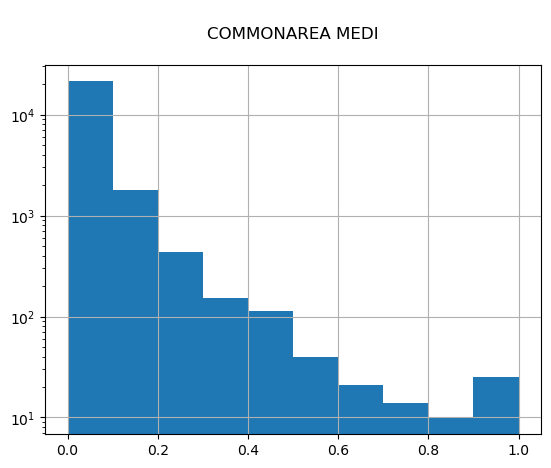

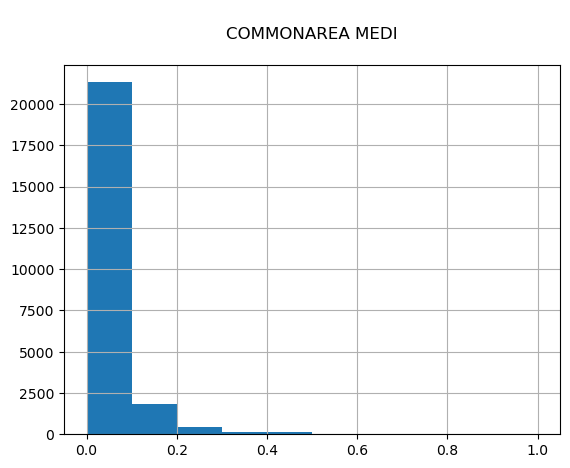

--------------------------------------------------
ELEVATORS_MEDI
--------------------------------------------------

18.30% above 0
53.23% is missing


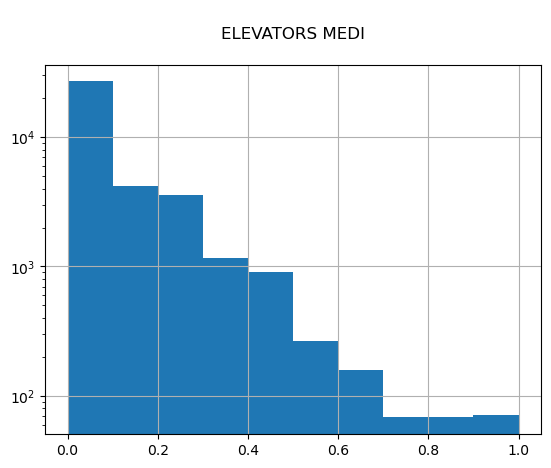

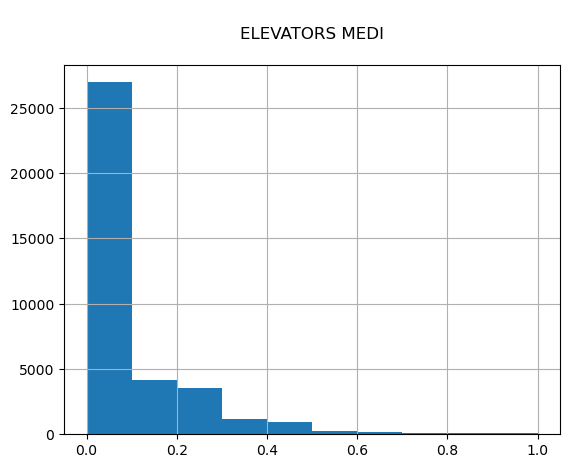

--------------------------------------------------
ENTRANCES_MEDI
--------------------------------------------------

49.58% above 0
50.32% is missing


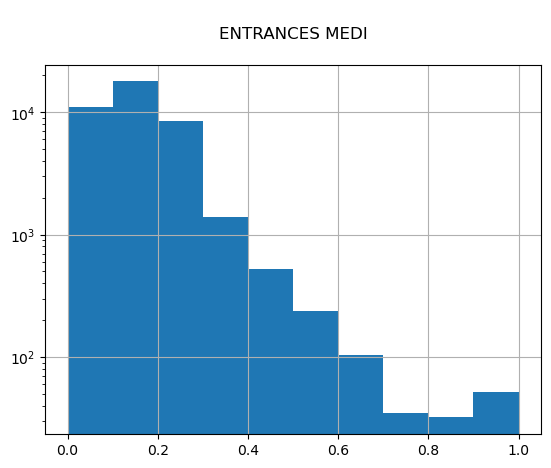

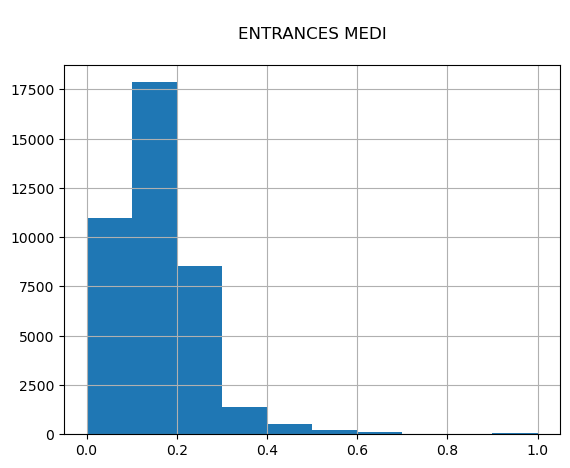

--------------------------------------------------
FLOORSMAX_MEDI
--------------------------------------------------

49.27% above 0
49.72% is missing


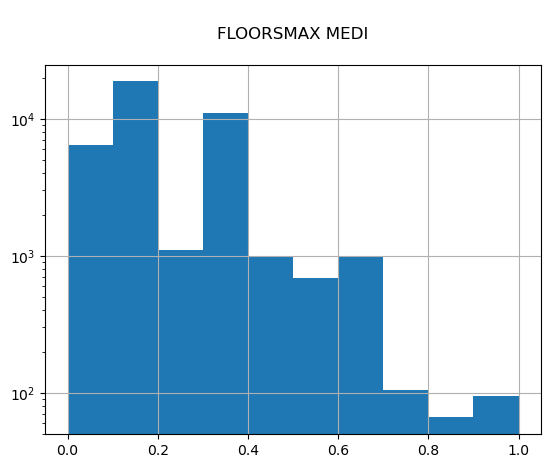

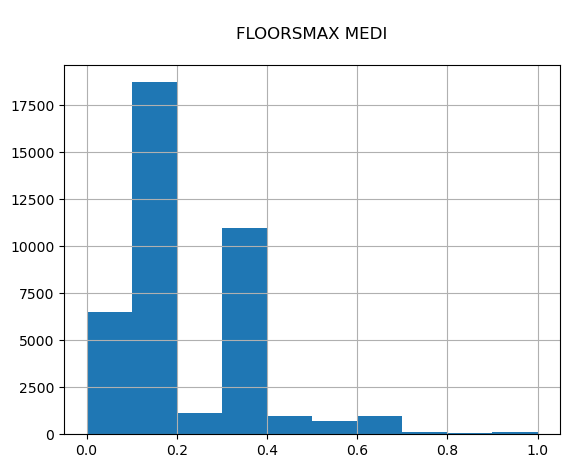

--------------------------------------------------
FLOORSMIN_MEDI
--------------------------------------------------

31.22% above 0
68.01% is missing


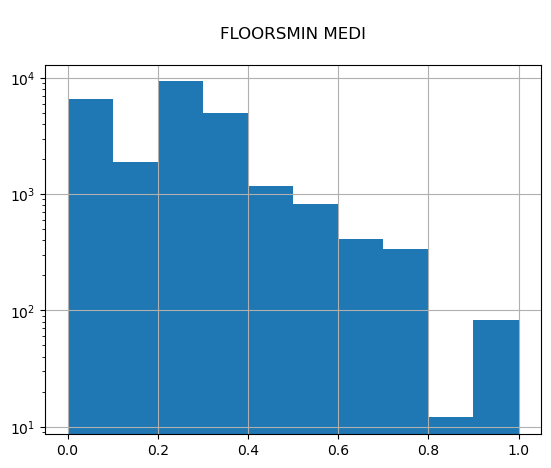

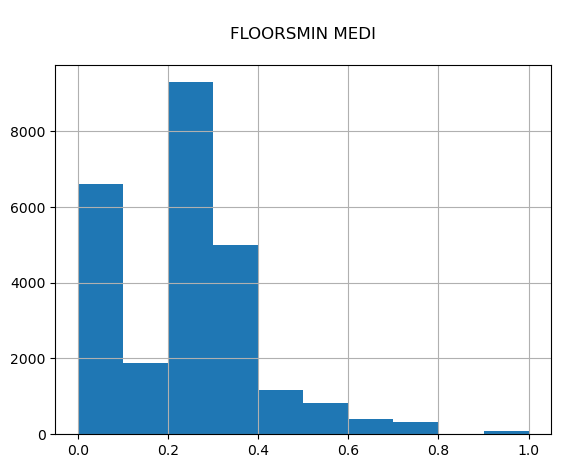

--------------------------------------------------
LANDAREA_MEDI
--------------------------------------------------

35.33% above 0
59.41% is missing


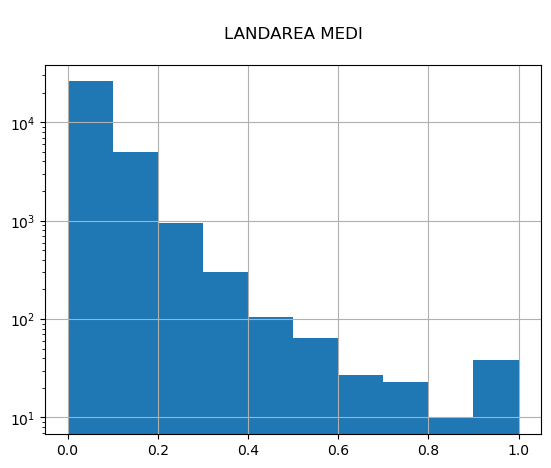

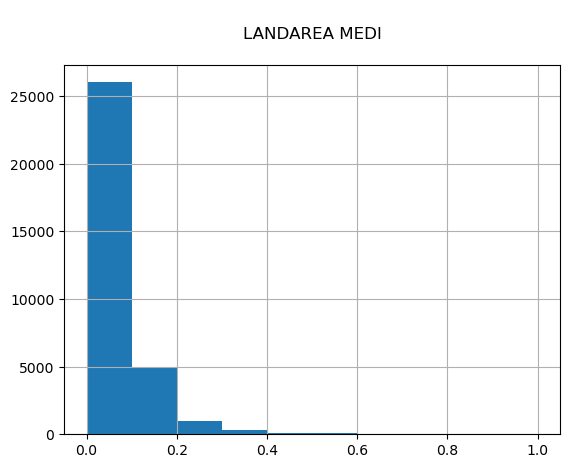

--------------------------------------------------
LIVINGAPARTMENTS_MEDI
--------------------------------------------------

31.39% above 0
68.47% is missing


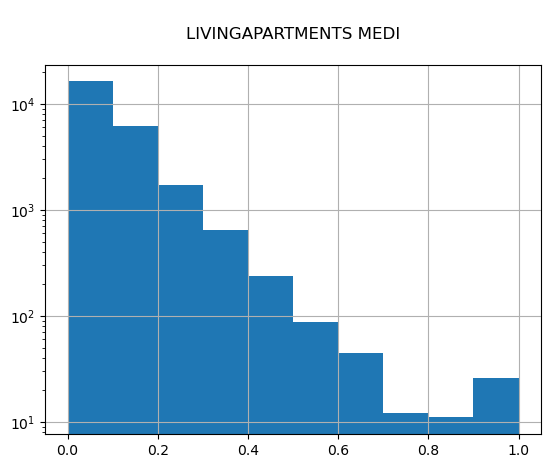

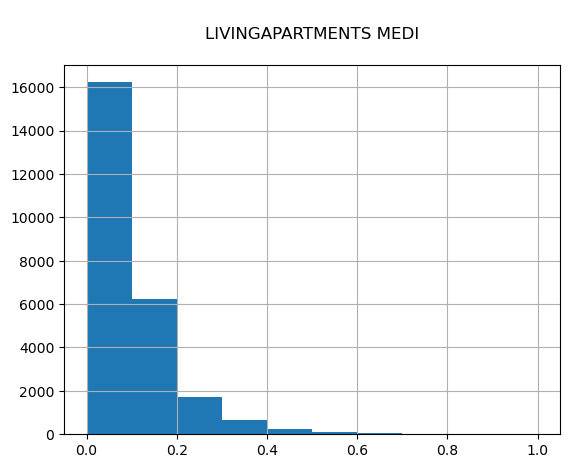

--------------------------------------------------
LIVINGAREA_MEDI
--------------------------------------------------

49.72% above 0
50.17% is missing


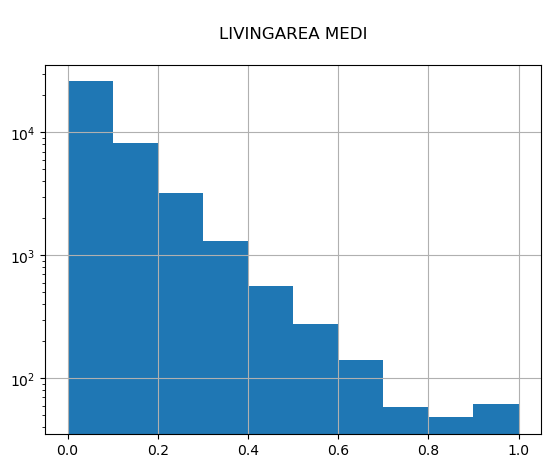

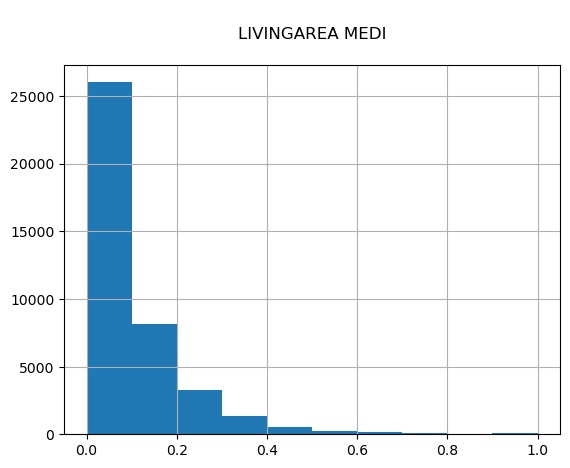

--------------------------------------------------
NONLIVINGAPARTMENTS_MEDI
--------------------------------------------------

12.11% above 0
69.58% is missing


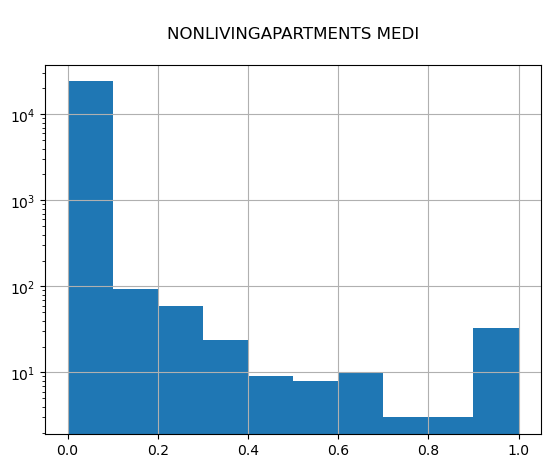

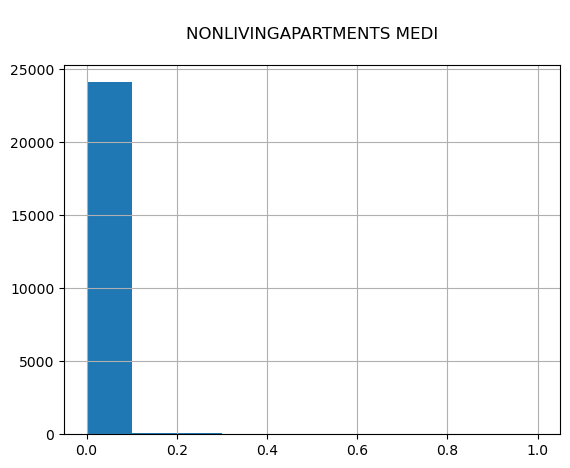

--------------------------------------------------
NONLIVINGAREA_MEDI
--------------------------------------------------

24.91% above 0
55.13% is missing


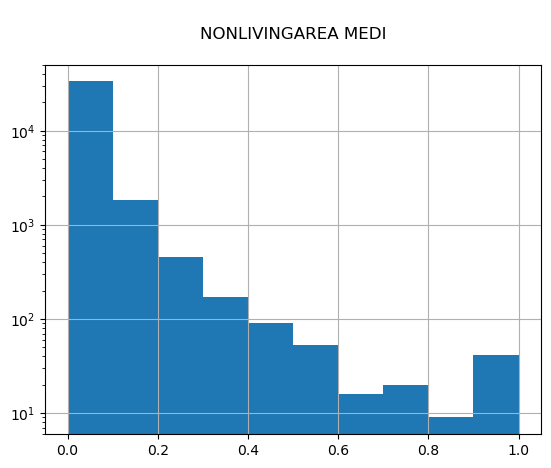

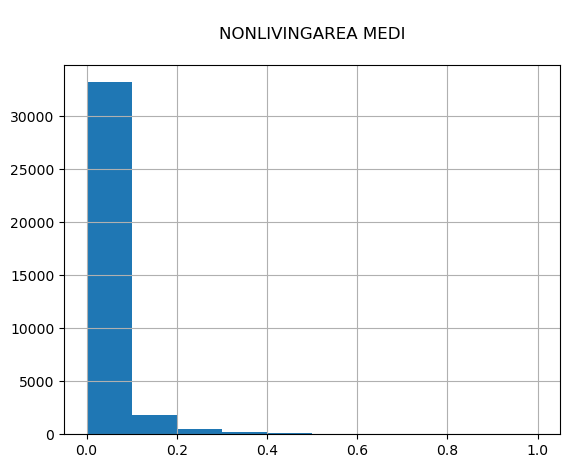

--------------------------------------------------
FONDKAPREMONT_MODE
--------------------------------------------------

68.61% is missing


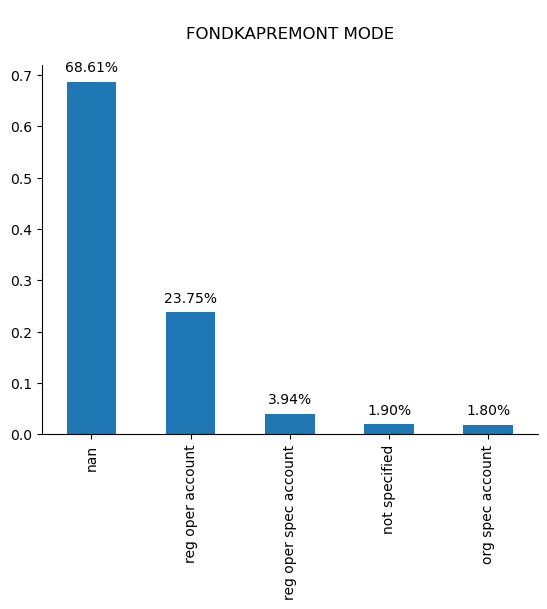

--------------------------------------------------
HOUSETYPE_MODE
--------------------------------------------------

50.15% is missing


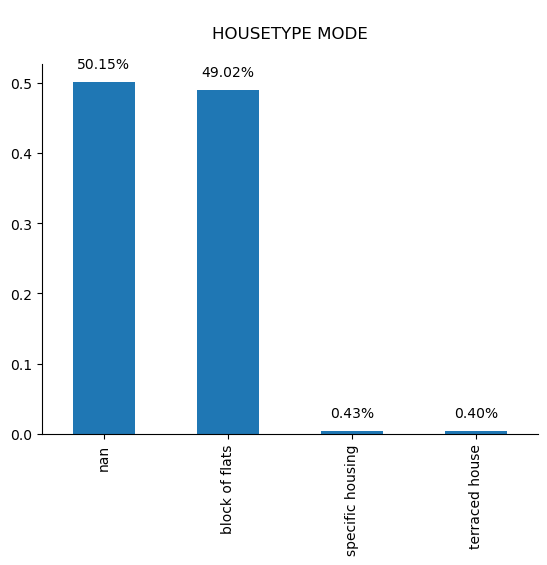

--------------------------------------------------
TOTALAREA_MODE
--------------------------------------------------

51.58% above 0
48.23% is missing


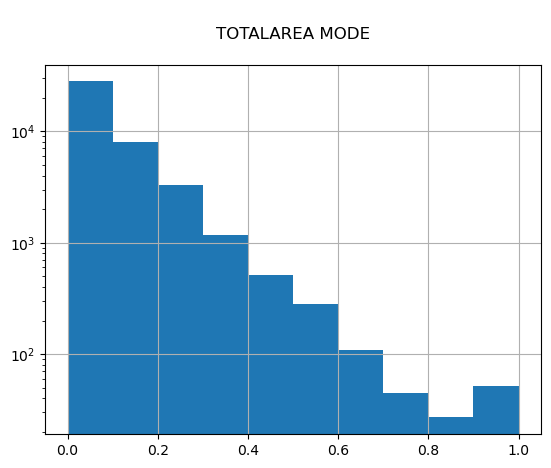

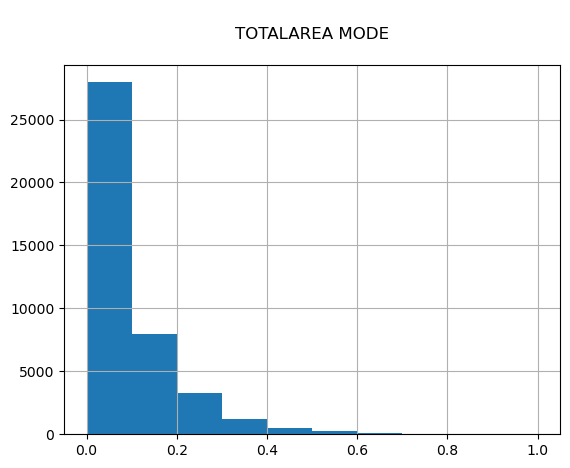

--------------------------------------------------
WALLSMATERIAL_MODE
--------------------------------------------------

50.78% is missing


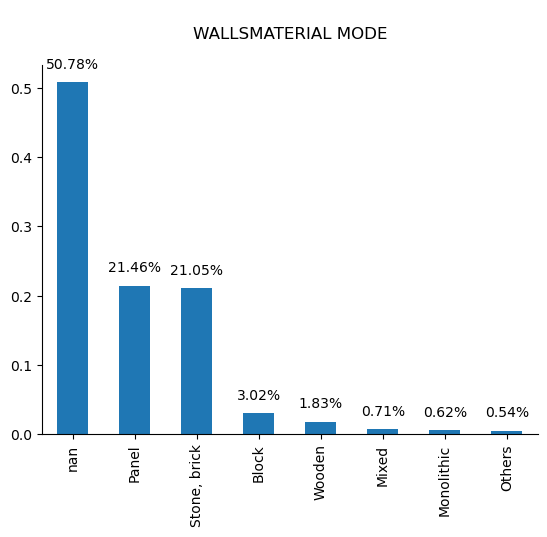

--------------------------------------------------
EMERGENCYSTATE_MODE
--------------------------------------------------

47.37% is missing


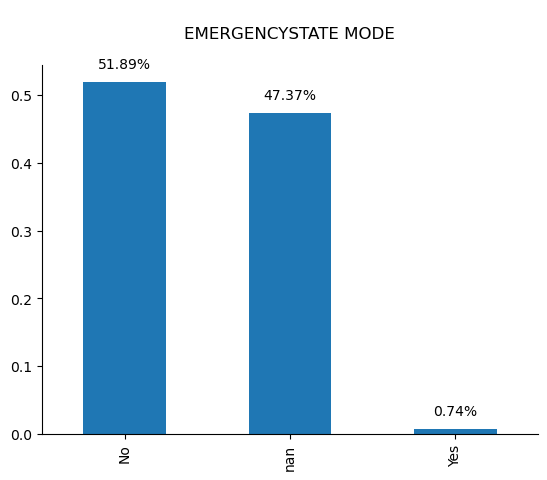

--------------------------------------------------
OBS_30_CNT_SOCIAL_CIRCLE
--------------------------------------------------

46.15% above 0
0.33% is missing


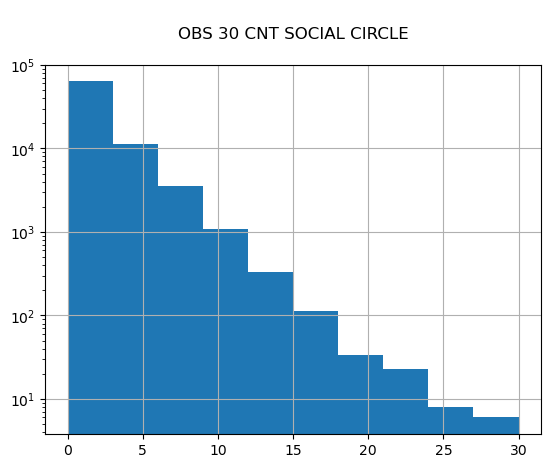

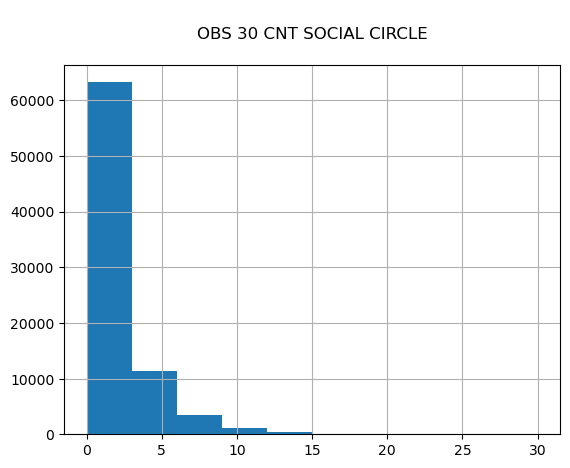

--------------------------------------------------
DEF_30_CNT_SOCIAL_CIRCLE
--------------------------------------------------

0.33% is missing


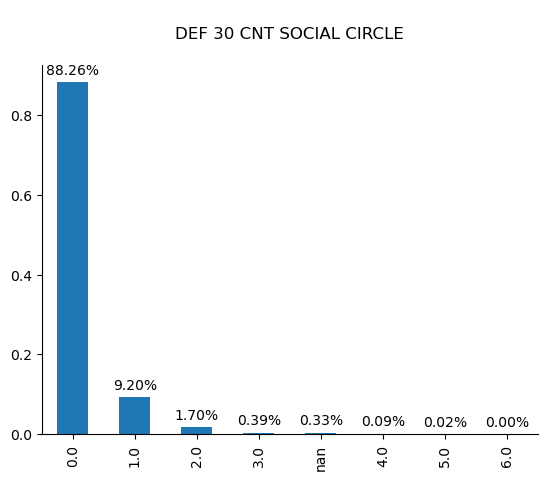

--------------------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE
--------------------------------------------------

45.91% above 0
0.33% is missing


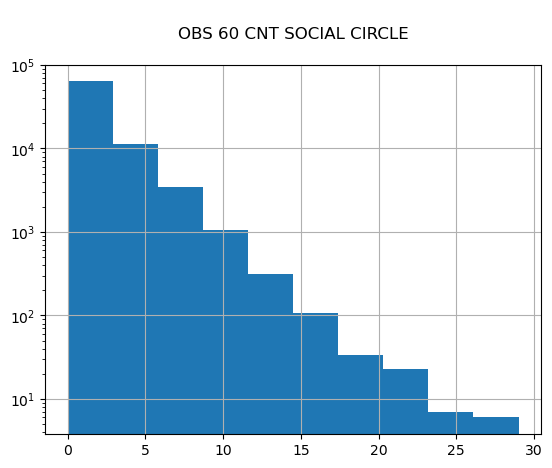

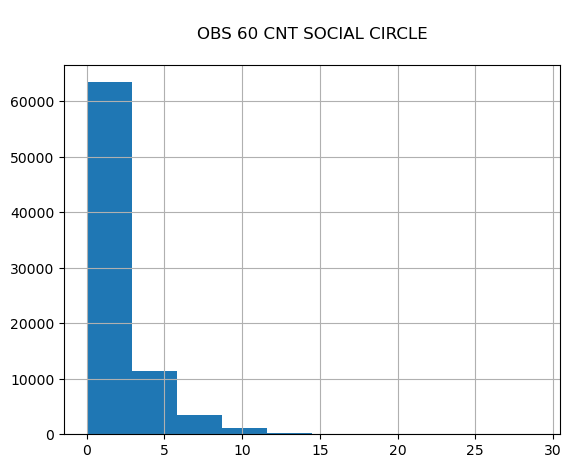

--------------------------------------------------
DEF_60_CNT_SOCIAL_CIRCLE
--------------------------------------------------

0.33% is missing


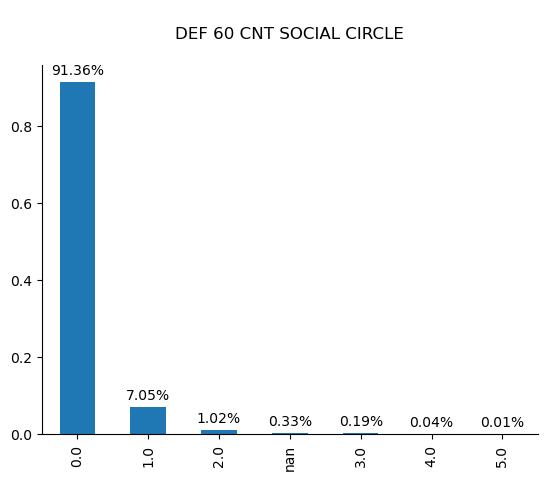

--------------------------------------------------
DAYS_LAST_PHONE_CHANGE
--------------------------------------------------

0.00% above 0
0.00% is missing


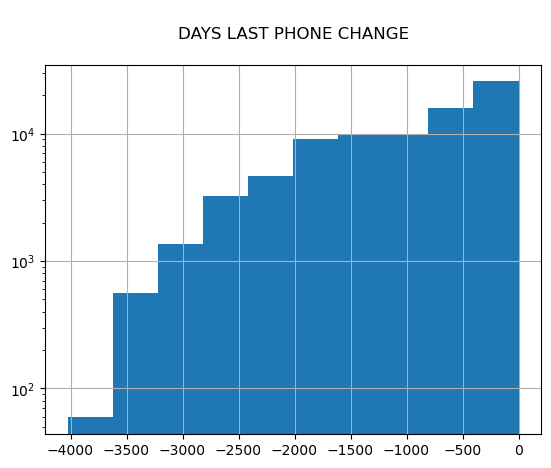

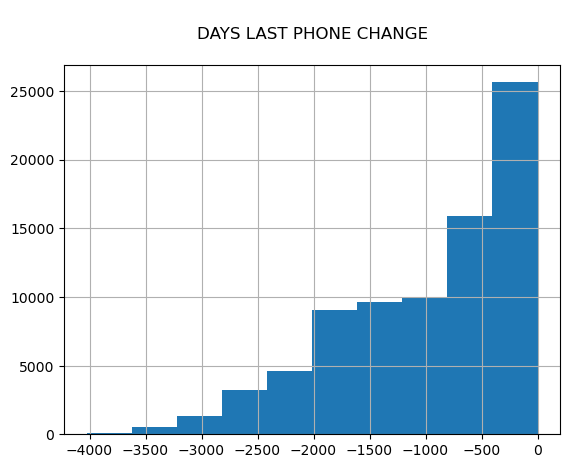

--------------------------------------------------
FLAG_DOCUMENT_2
--------------------------------------------------

0.00% is missing


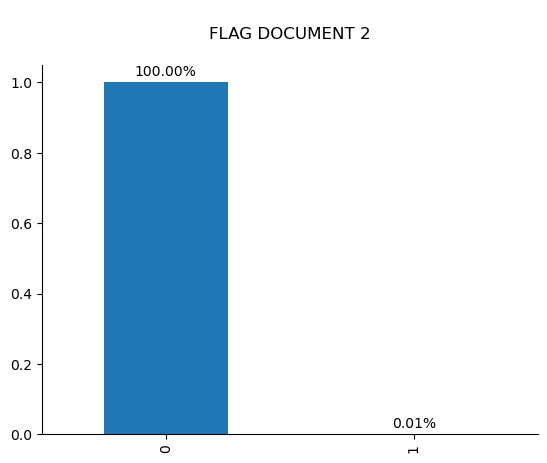

--------------------------------------------------
FLAG_DOCUMENT_3
--------------------------------------------------

0.00% is missing


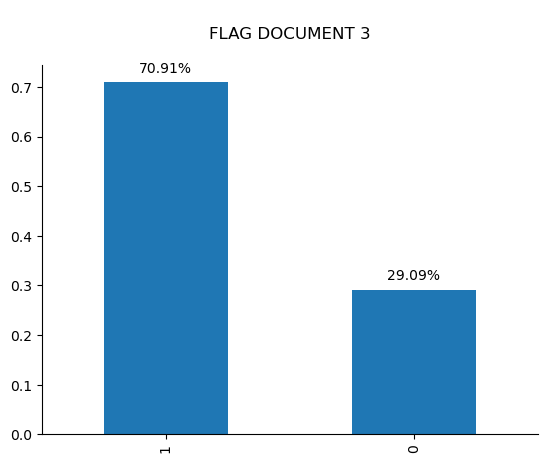

--------------------------------------------------
FLAG_DOCUMENT_4
--------------------------------------------------

0.00% is missing


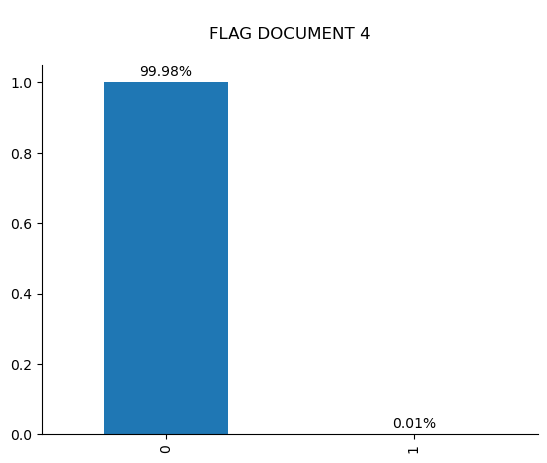

--------------------------------------------------
FLAG_DOCUMENT_5
--------------------------------------------------

0.00% is missing


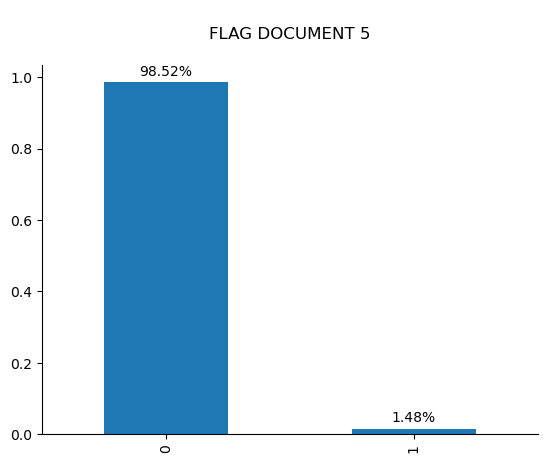

--------------------------------------------------
FLAG_DOCUMENT_6
--------------------------------------------------

0.00% is missing


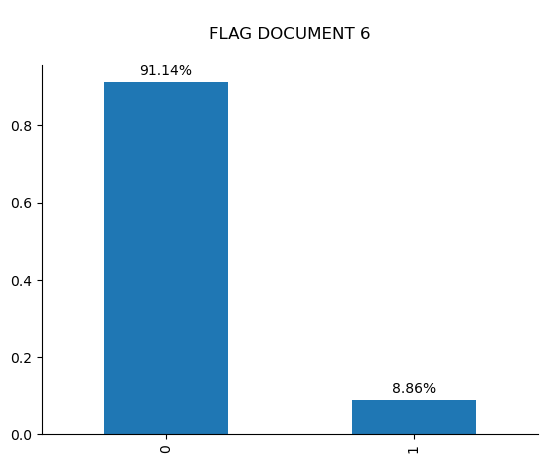

--------------------------------------------------
FLAG_DOCUMENT_7
--------------------------------------------------

0.00% is missing


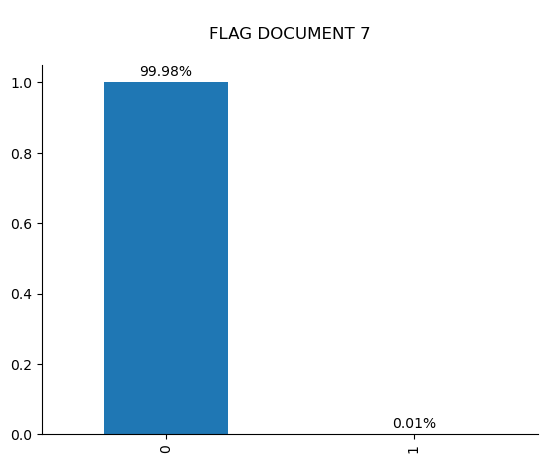

--------------------------------------------------
FLAG_DOCUMENT_8
--------------------------------------------------

0.00% is missing


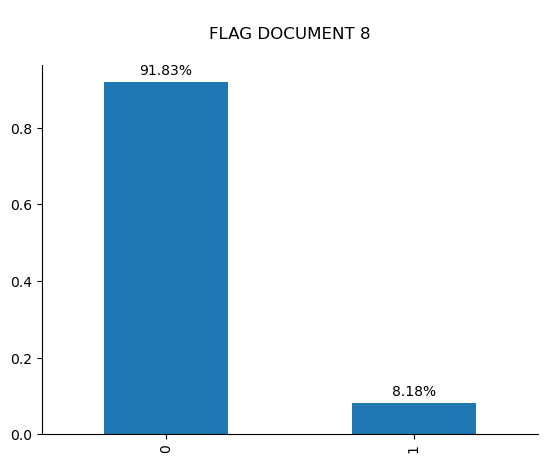

--------------------------------------------------
FLAG_DOCUMENT_9
--------------------------------------------------

0.00% is missing


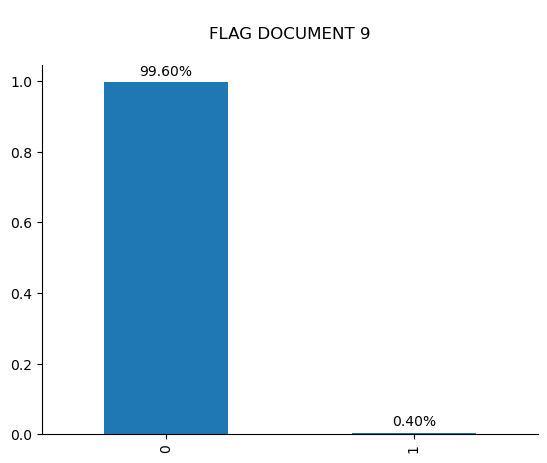

--------------------------------------------------
FLAG_DOCUMENT_10
--------------------------------------------------

FLAG_DOCUMENT_10 - only constant with value [0]
--------------------------------------------------
FLAG_DOCUMENT_11
--------------------------------------------------

0.00% is missing


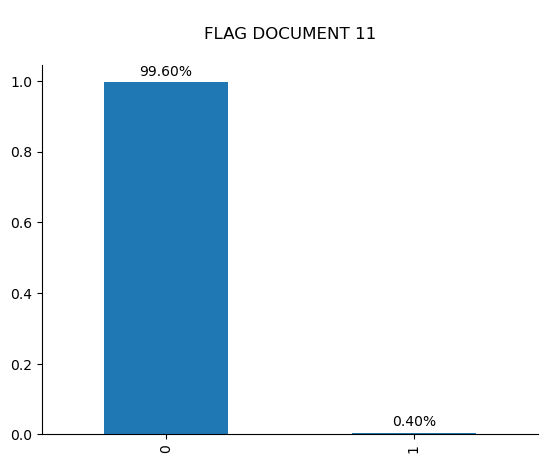

--------------------------------------------------
FLAG_DOCUMENT_12
--------------------------------------------------

FLAG_DOCUMENT_12 - only constant with value [0]
--------------------------------------------------
FLAG_DOCUMENT_13
--------------------------------------------------

0.00% is missing


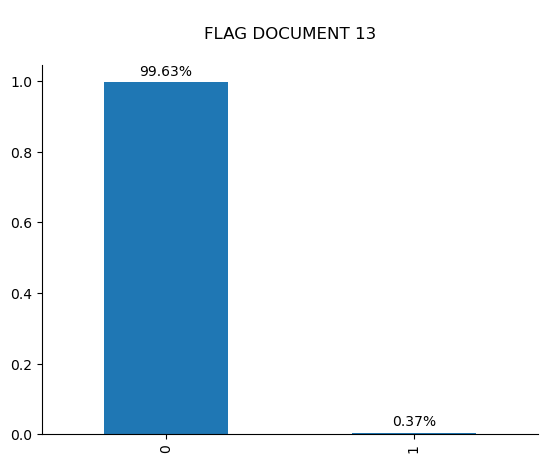

--------------------------------------------------
FLAG_DOCUMENT_14
--------------------------------------------------

0.00% is missing


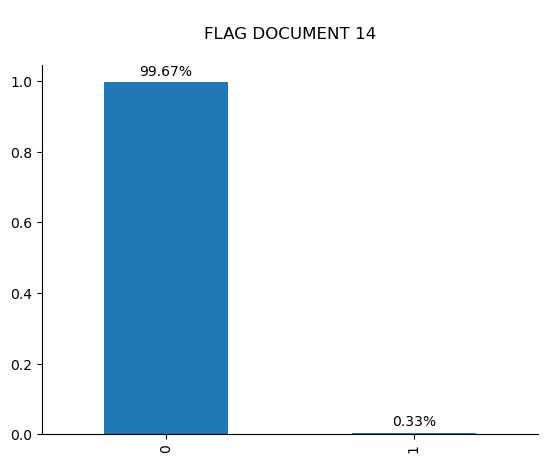

--------------------------------------------------
FLAG_DOCUMENT_15
--------------------------------------------------

0.00% is missing


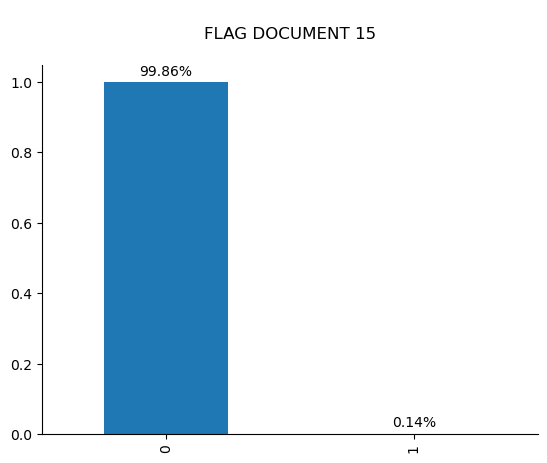

--------------------------------------------------
FLAG_DOCUMENT_16
--------------------------------------------------

0.00% is missing


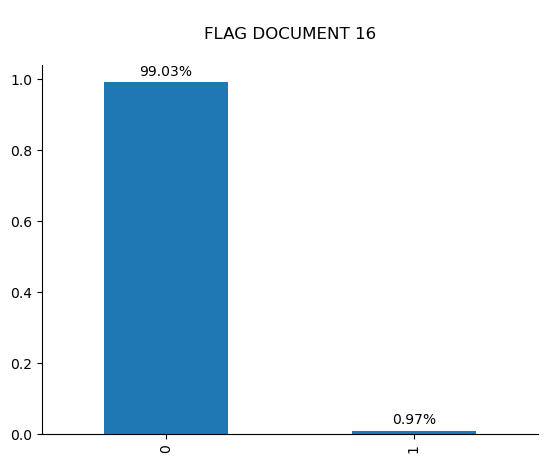

--------------------------------------------------
FLAG_DOCUMENT_17
--------------------------------------------------

0.00% is missing


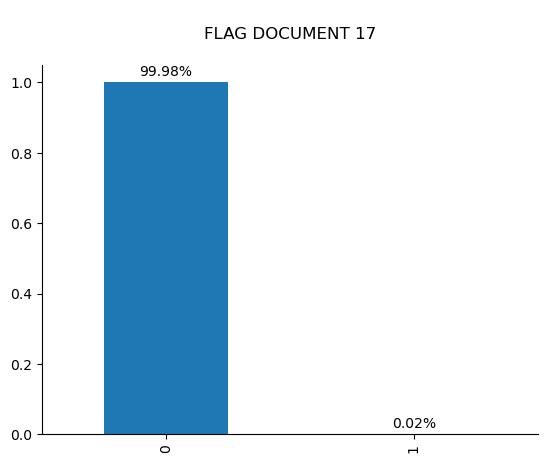

--------------------------------------------------
FLAG_DOCUMENT_18
--------------------------------------------------

0.00% is missing


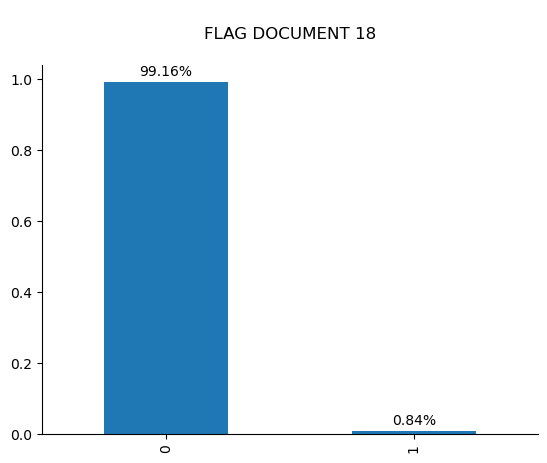

--------------------------------------------------
FLAG_DOCUMENT_19
--------------------------------------------------

0.00% is missing


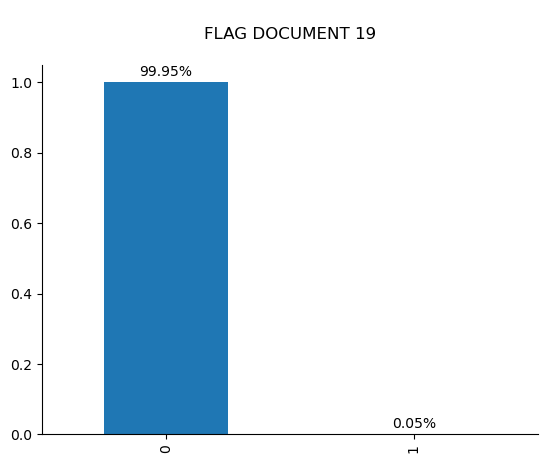

--------------------------------------------------
FLAG_DOCUMENT_20
--------------------------------------------------

0.00% is missing


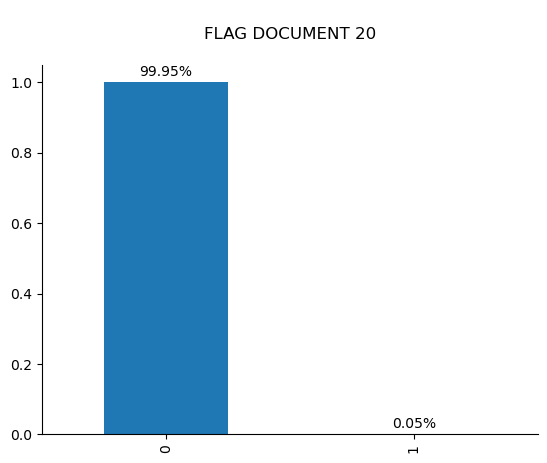

--------------------------------------------------
FLAG_DOCUMENT_21
--------------------------------------------------

0.00% is missing


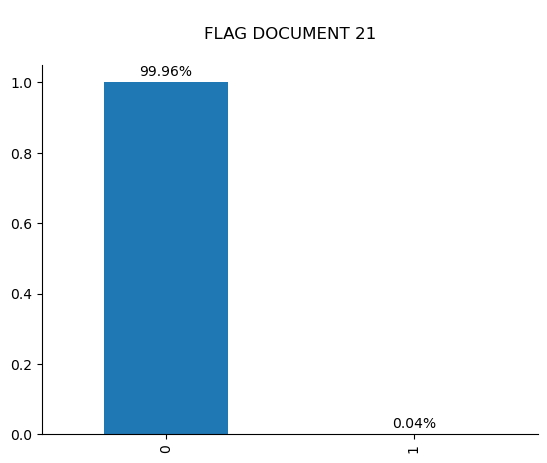

--------------------------------------------------
AMT_REQ_CREDIT_BUREAU_HOUR
--------------------------------------------------

13.50% is missing


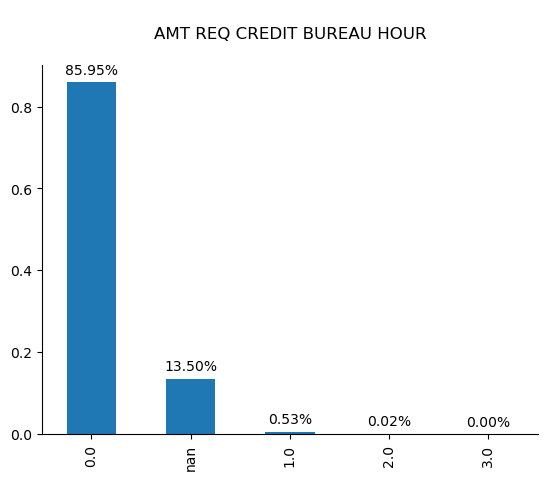

--------------------------------------------------
AMT_REQ_CREDIT_BUREAU_DAY
--------------------------------------------------

13.50% is missing


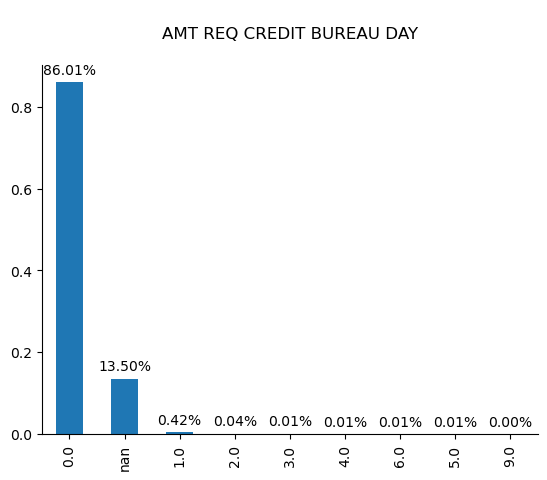

--------------------------------------------------
AMT_REQ_CREDIT_BUREAU_WEEK
--------------------------------------------------

13.50% is missing


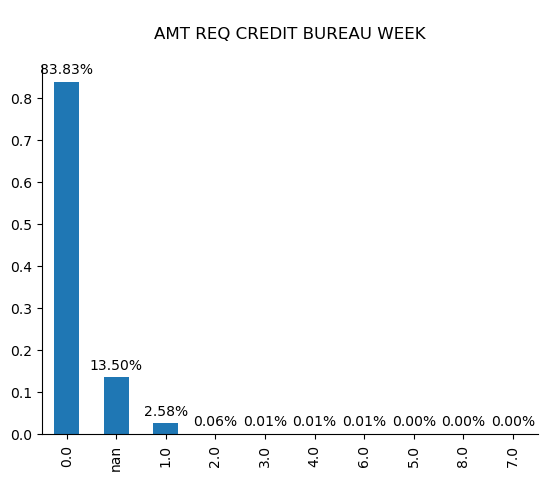

--------------------------------------------------
AMT_REQ_CREDIT_BUREAU_MON
--------------------------------------------------

14.21% above 0
13.50% is missing


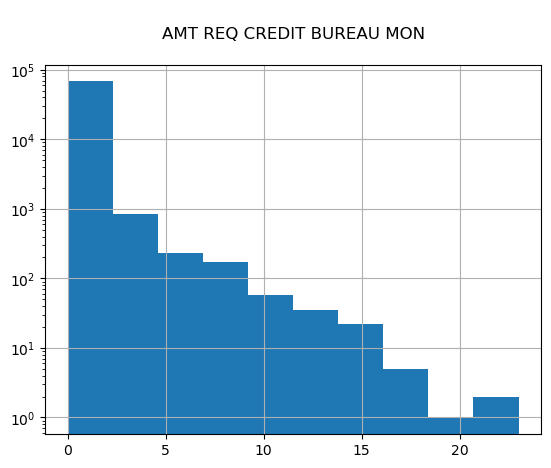

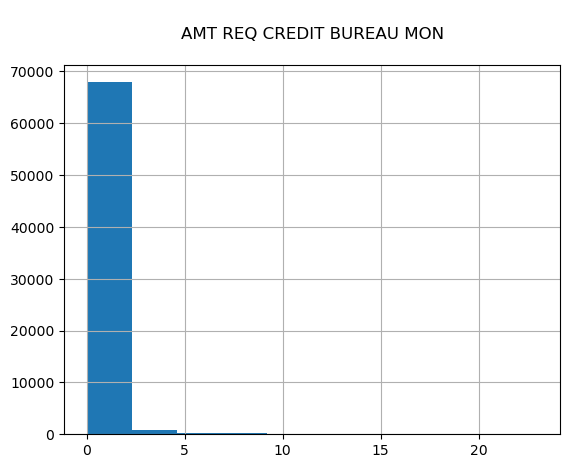

--------------------------------------------------
AMT_REQ_CREDIT_BUREAU_QRT
--------------------------------------------------

13.50% is missing


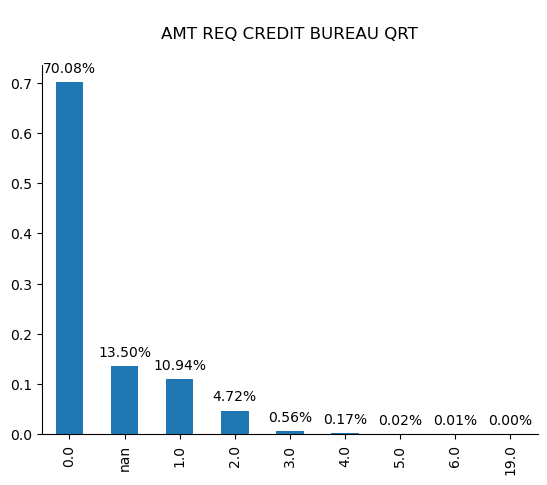

--------------------------------------------------
AMT_REQ_CREDIT_BUREAU_YEAR
--------------------------------------------------

63.15% above 0
13.50% is missing


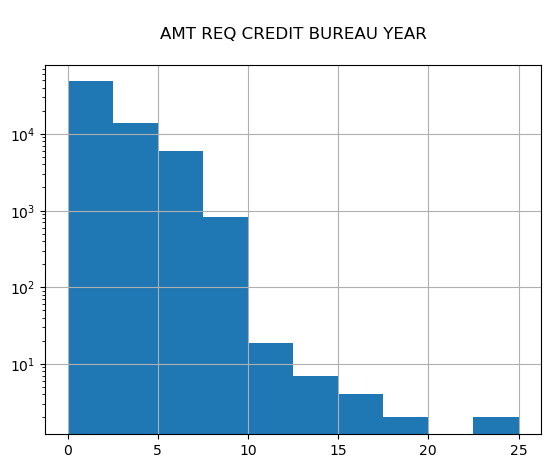

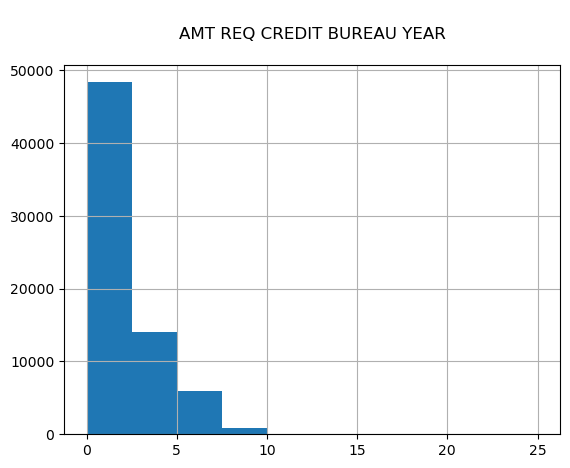

--------------------------------------------------
MIN_AMTCR_0M_INFM
--------------------------------------------------

57.17% above 0
37.94% is missing


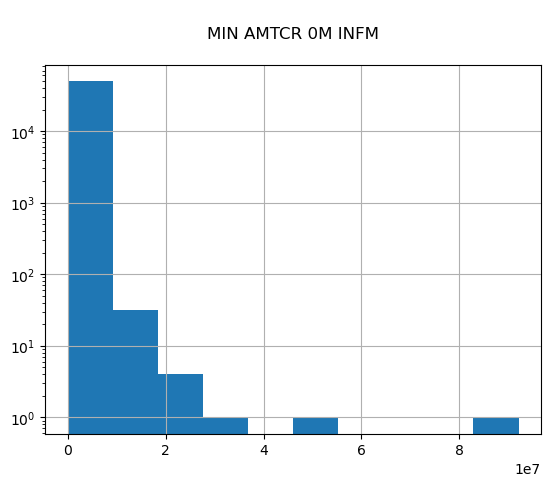

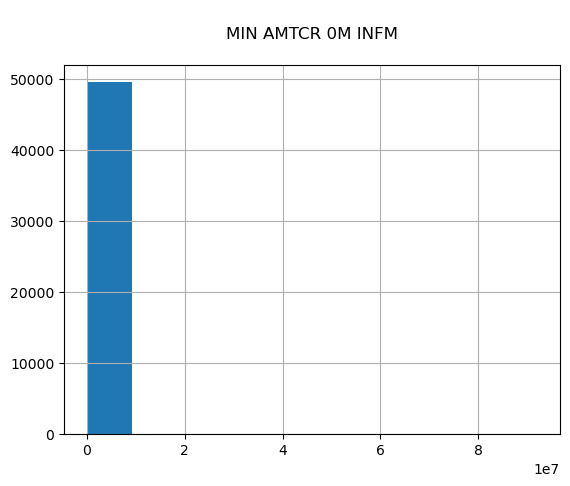

--------------------------------------------------
MAX_AMTCR_0M_INFM
--------------------------------------------------

61.13% above 0
37.94% is missing


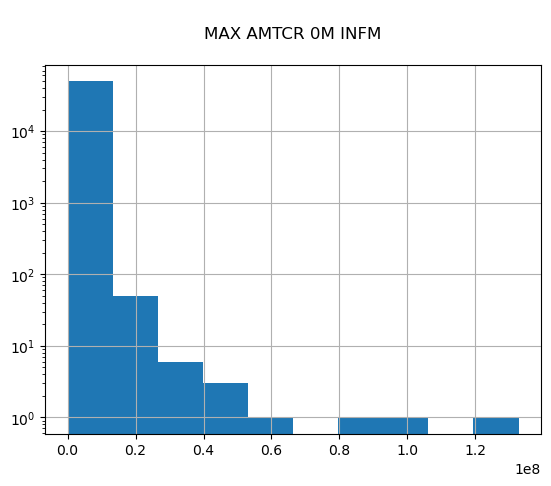

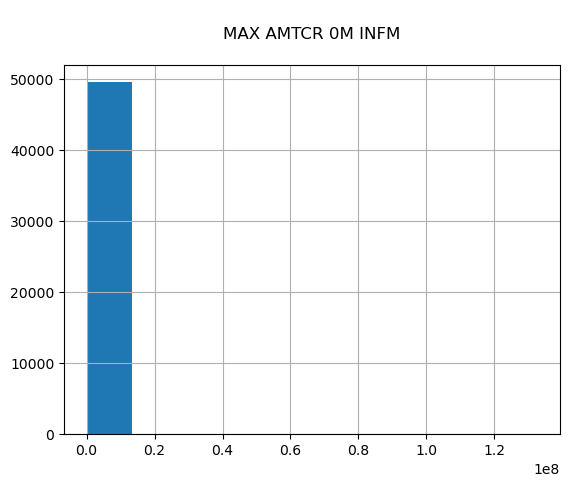

--------------------------------------------------
MEAN_AMTCR_0M_INFM
--------------------------------------------------

61.13% above 0
37.94% is missing


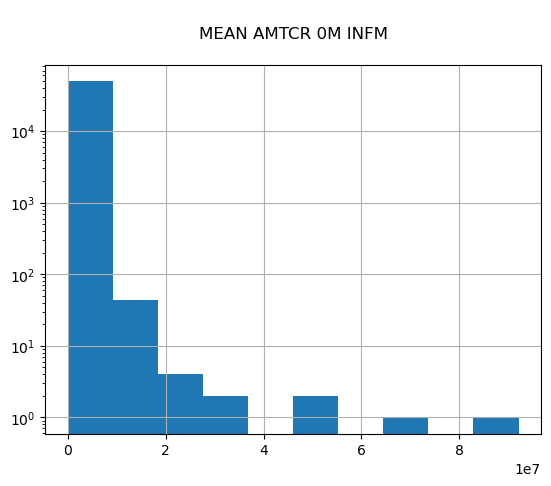

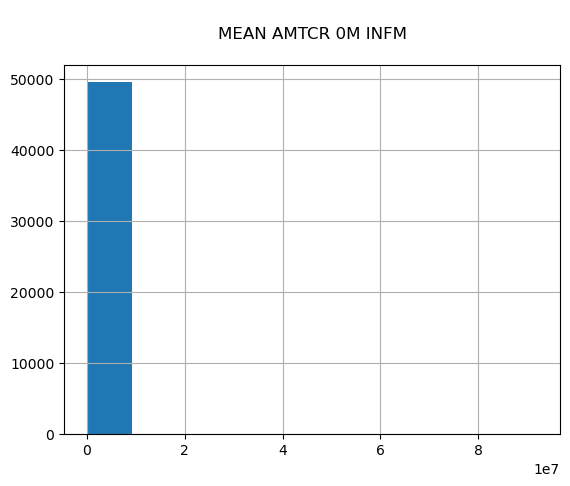

--------------------------------------------------
MEDIAN_AMTCR_0M_INFM
--------------------------------------------------

61.05% above 0
37.94% is missing


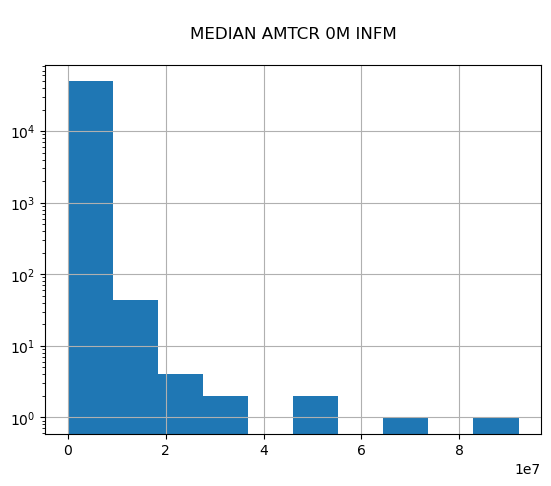

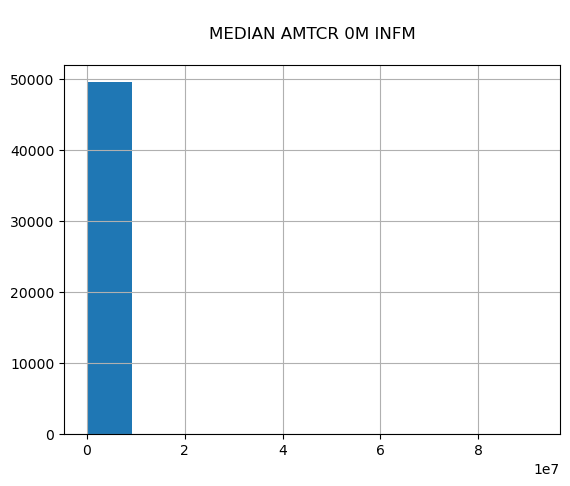

--------------------------------------------------
STD_AMTCR_0M_INFM
--------------------------------------------------

35.25% above 0
64.20% is missing


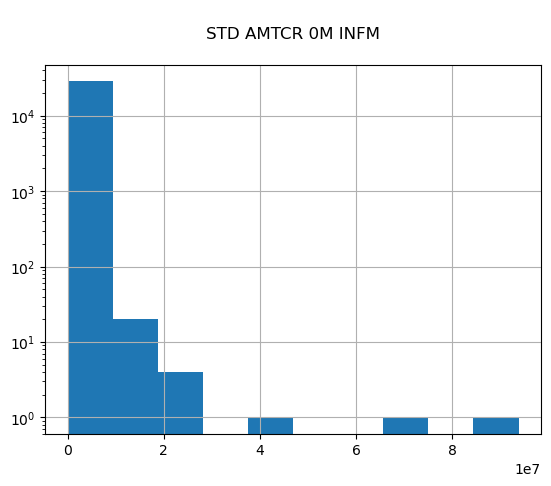

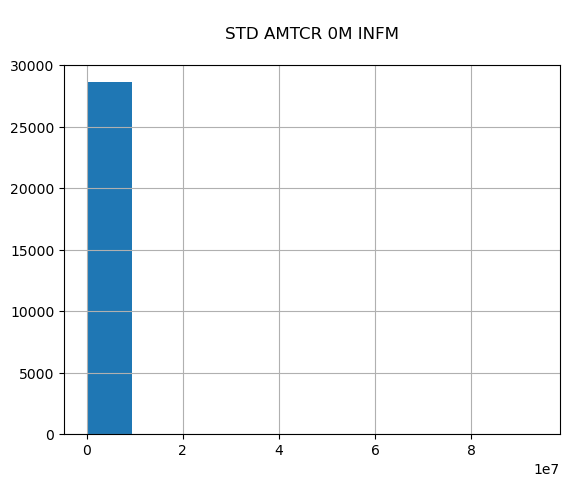

--------------------------------------------------
MIN_AMTCR_0M_6M
--------------------------------------------------

10.27% above 0
89.59% is missing


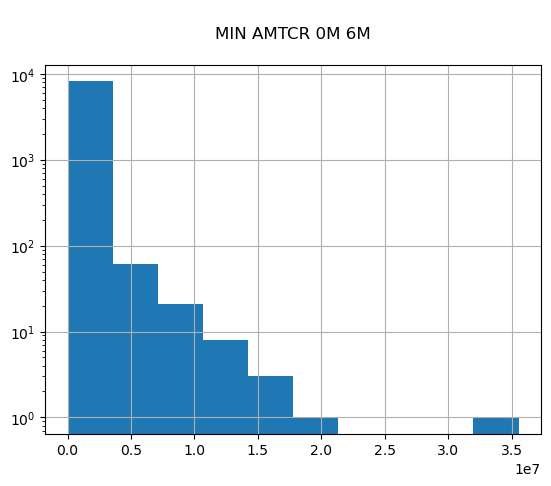

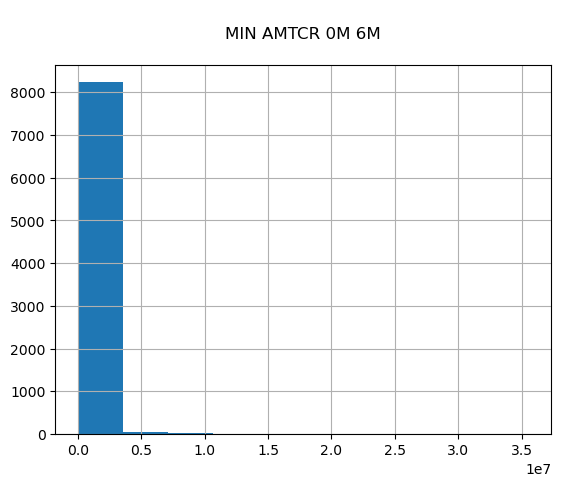

--------------------------------------------------
MAX_AMTCR_0M_6M
--------------------------------------------------

10.31% above 0
89.59% is missing


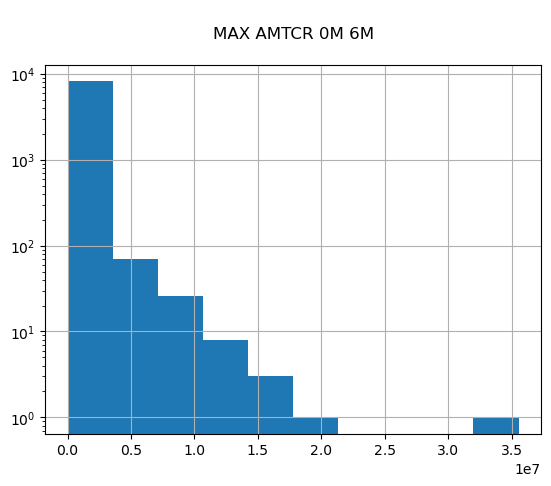

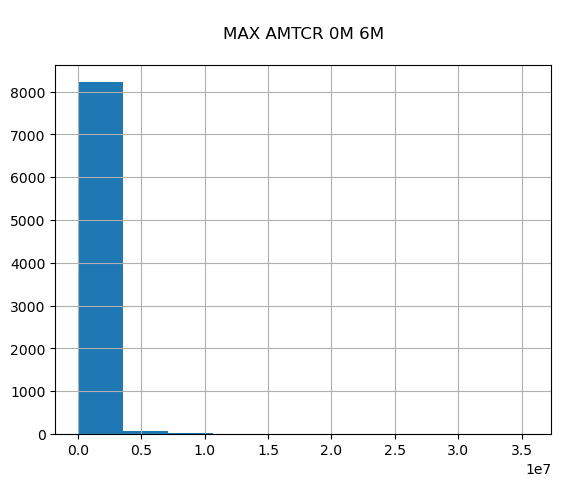

--------------------------------------------------
MEAN_AMTCR_0M_6M
--------------------------------------------------

10.31% above 0
89.59% is missing


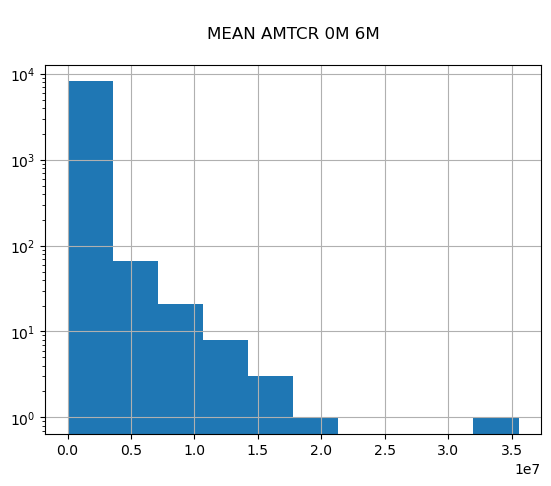

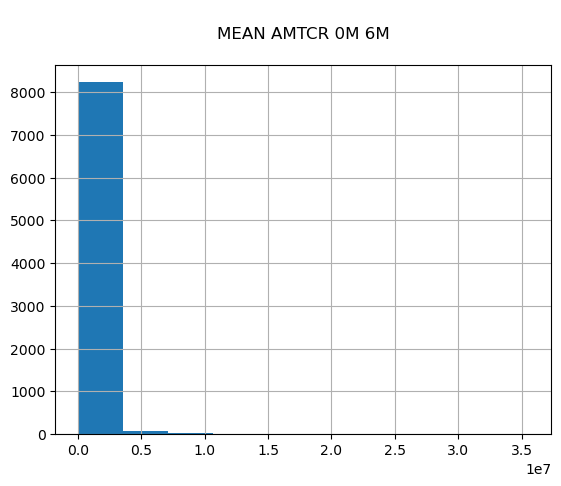

--------------------------------------------------
MEDIAN_AMTCR_0M_6M
--------------------------------------------------

10.31% above 0
89.59% is missing


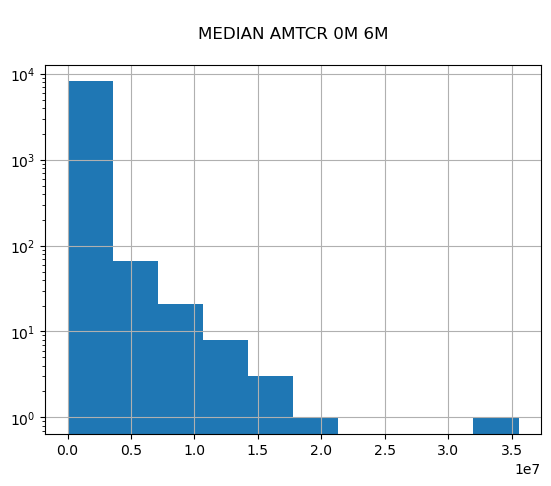

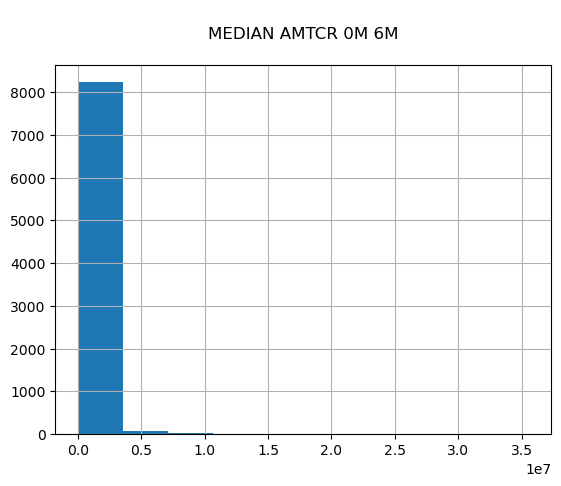

--------------------------------------------------
STD_AMTCR_0M_6M
--------------------------------------------------

1.15% above 0
98.76% is missing


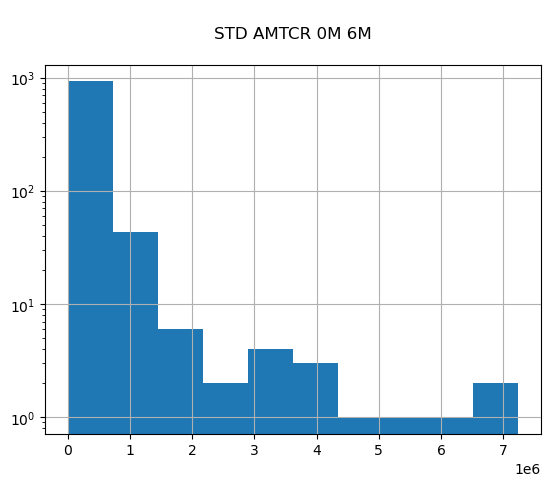

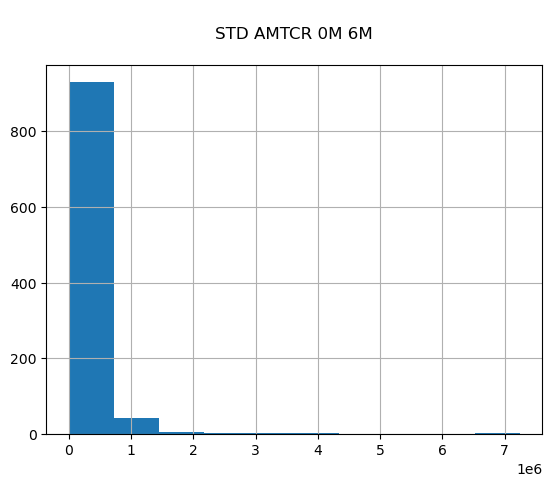

--------------------------------------------------
MIN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

34.01% above 0
63.18% is missing


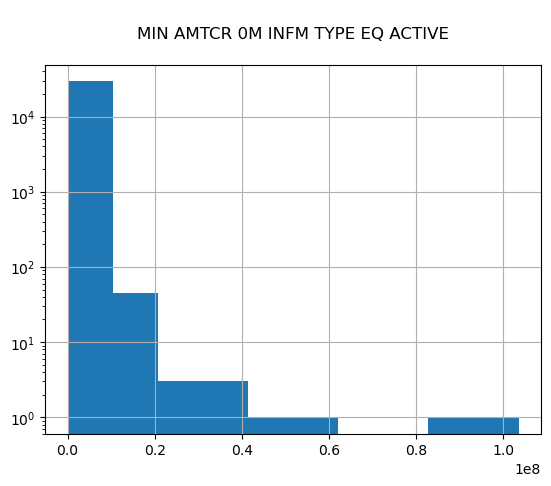

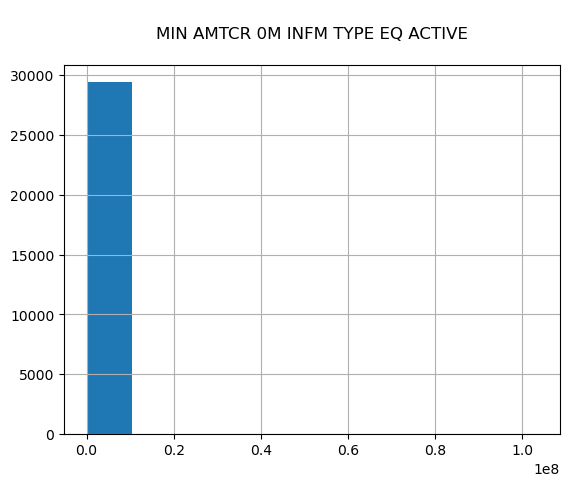

--------------------------------------------------
MAX_AMTCR_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

35.50% above 0
63.18% is missing


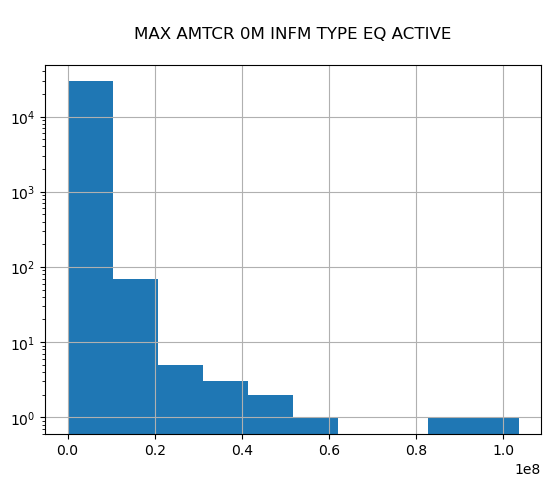

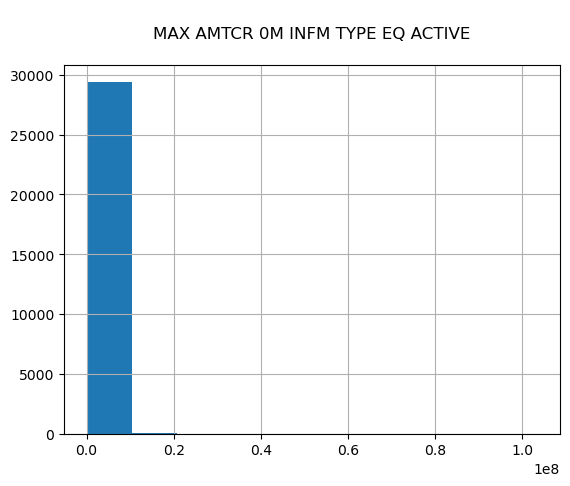

--------------------------------------------------
MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

35.50% above 0
63.18% is missing


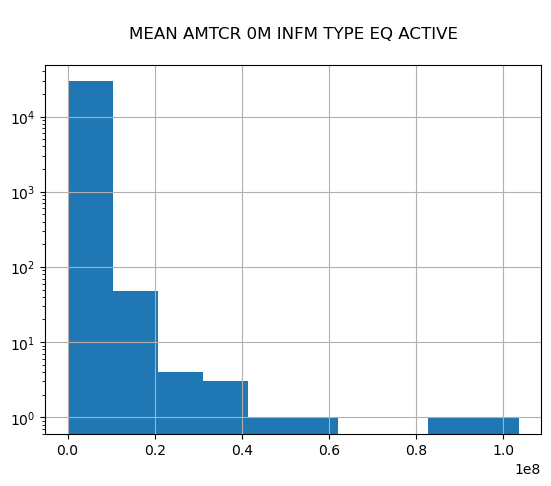

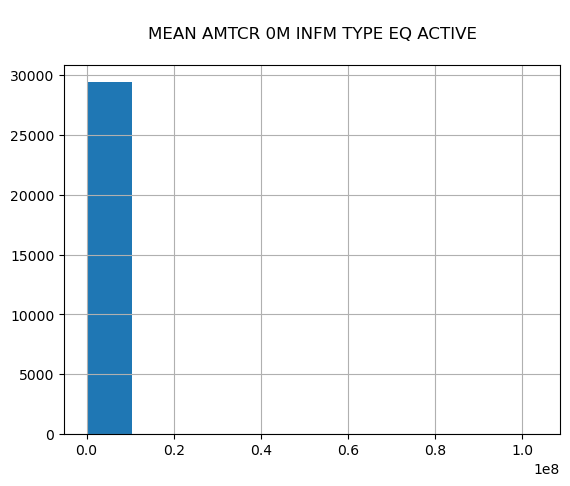

--------------------------------------------------
MEDIAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

35.43% above 0
63.18% is missing


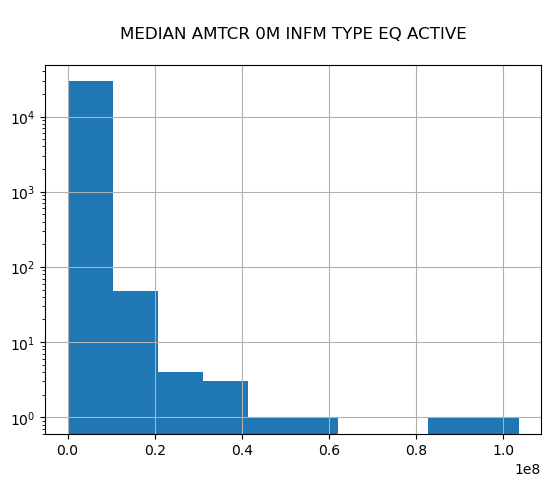

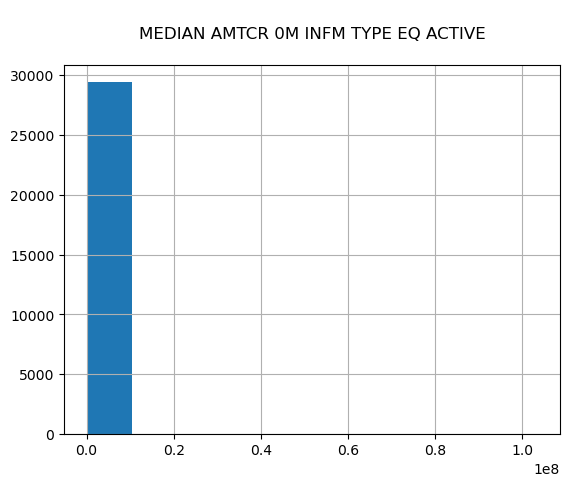

--------------------------------------------------
STD_AMTCR_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

10.57% above 0
89.13% is missing


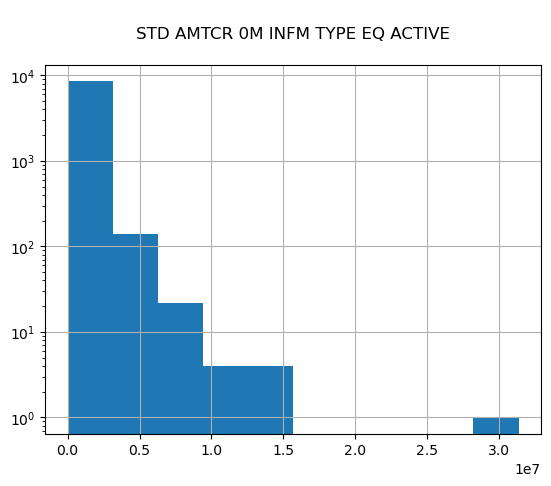

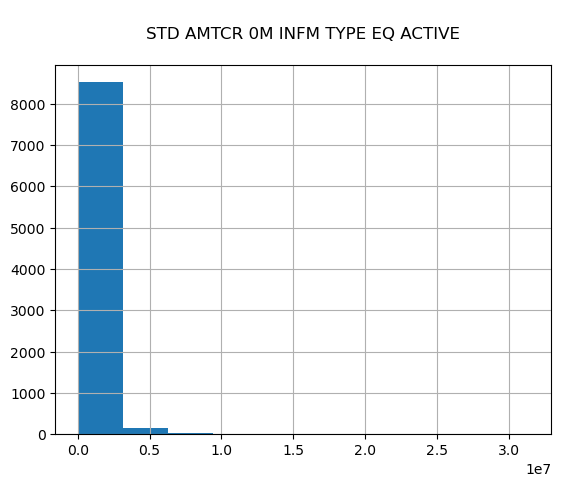

--------------------------------------------------
MIN_AMTCR_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

9.26% above 0
90.62% is missing


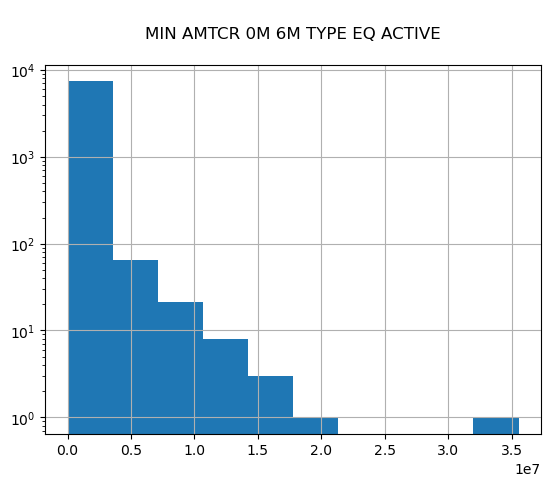

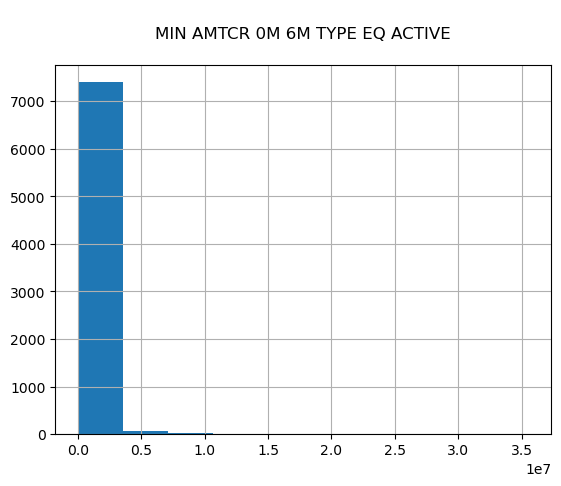

--------------------------------------------------
MAX_AMTCR_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

9.29% above 0
90.62% is missing


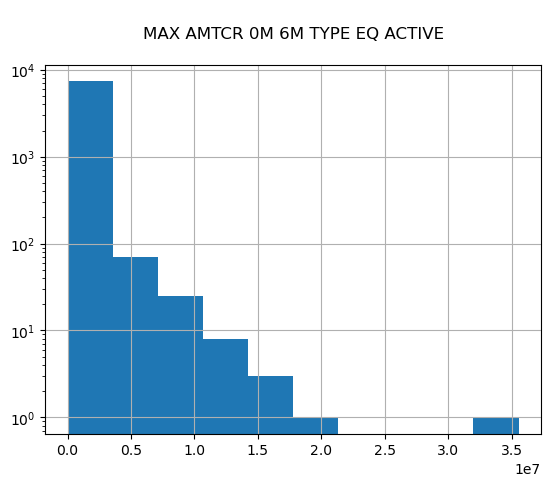

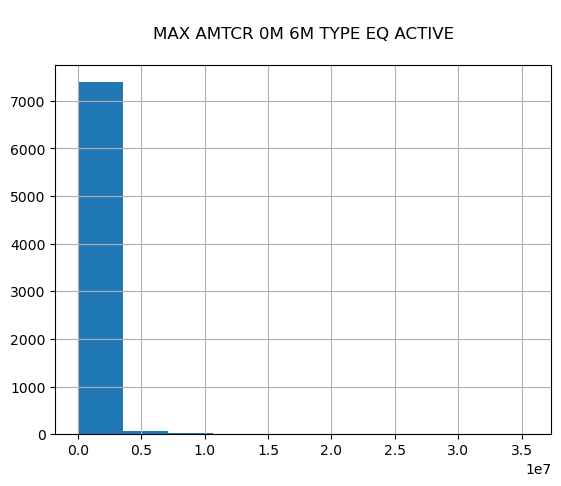

--------------------------------------------------
MEAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

9.29% above 0
90.62% is missing


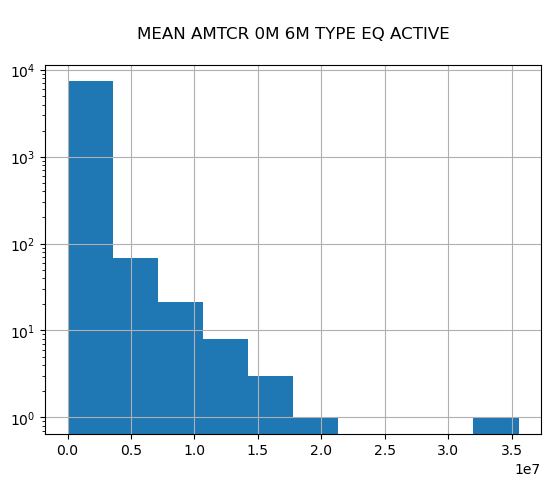

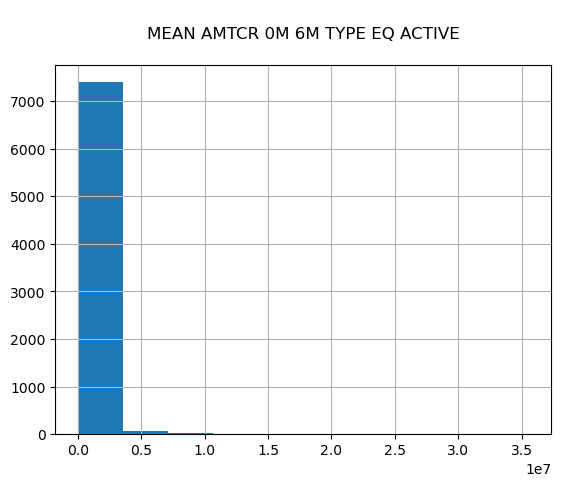

--------------------------------------------------
MEDIAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

9.29% above 0
90.62% is missing


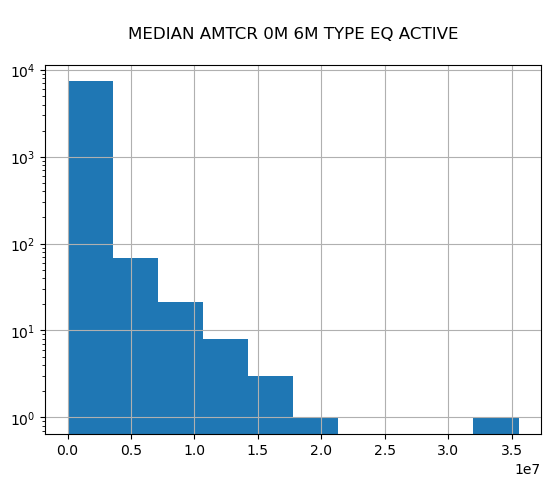

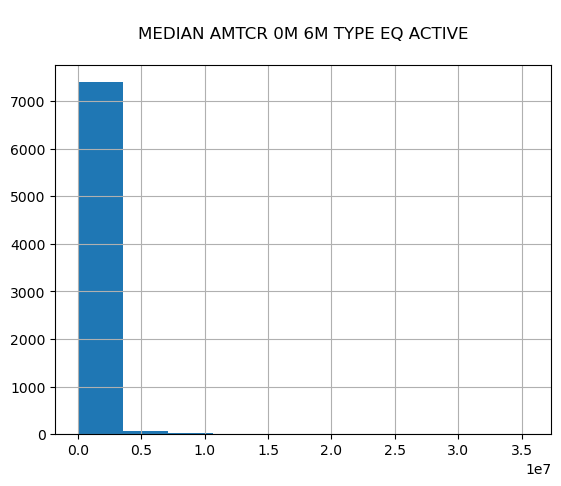

--------------------------------------------------
STD_AMTCR_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

0.75% above 0
99.21% is missing


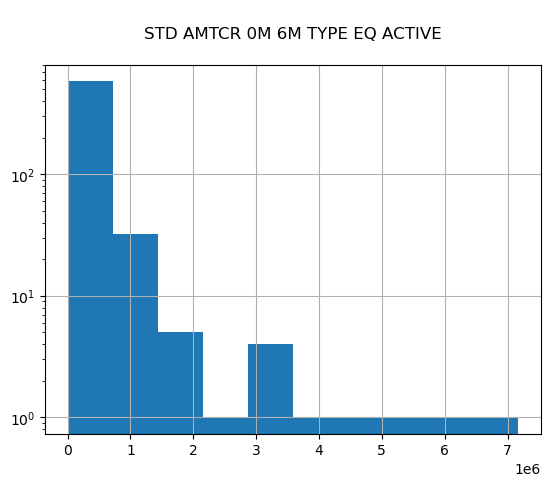

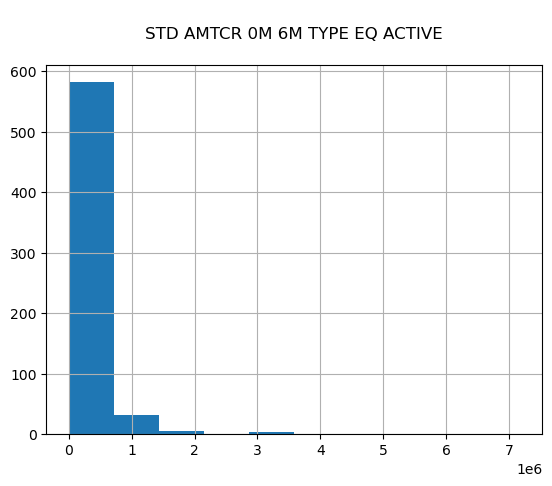

--------------------------------------------------
MIN_AMTCR_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

45.00% above 0
52.82% is missing


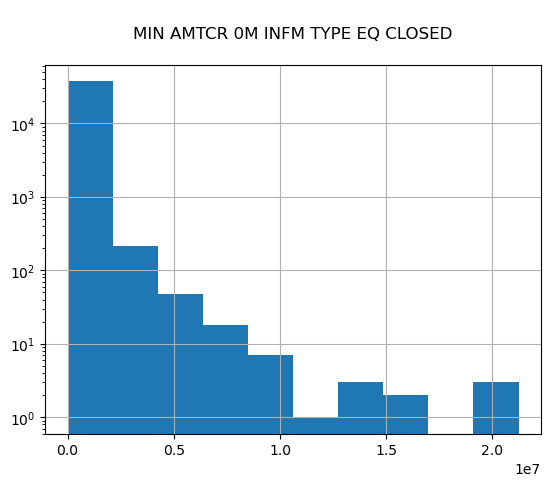

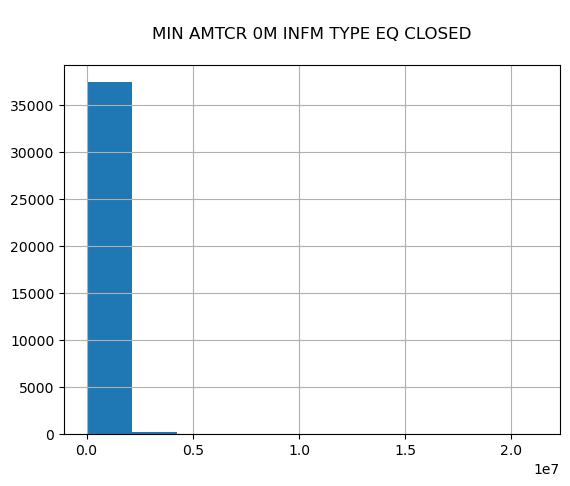

--------------------------------------------------
MAX_AMTCR_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

46.45% above 0
52.82% is missing


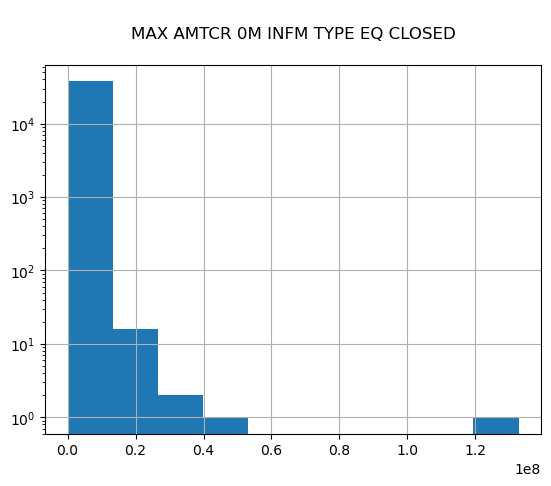

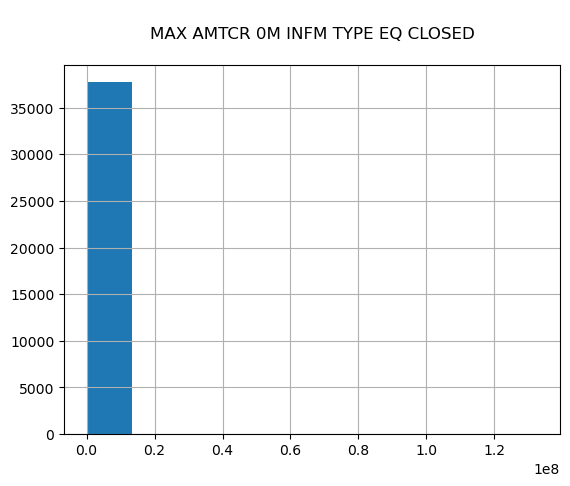

--------------------------------------------------
MEAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

46.45% above 0
52.82% is missing


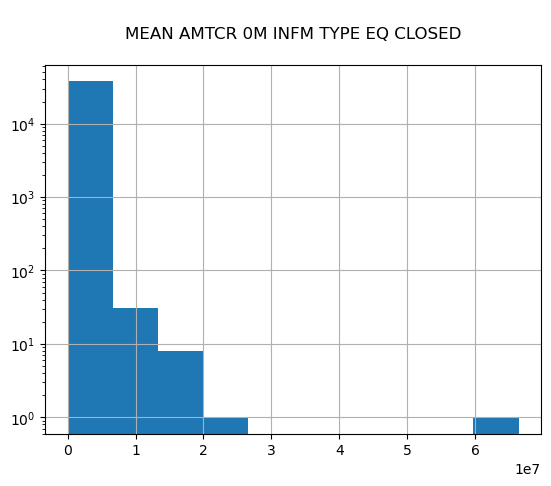

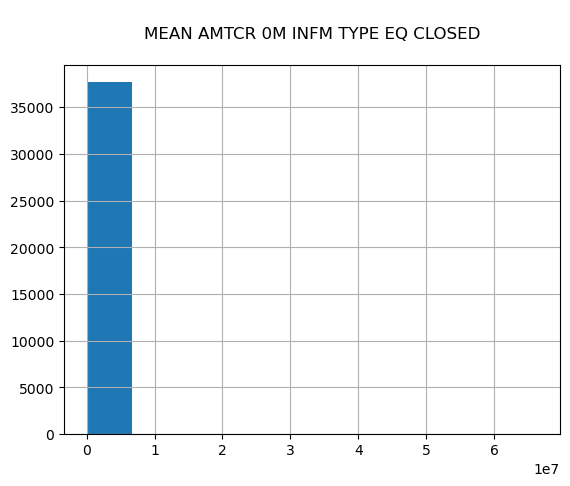

--------------------------------------------------
MEDIAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

46.41% above 0
52.82% is missing


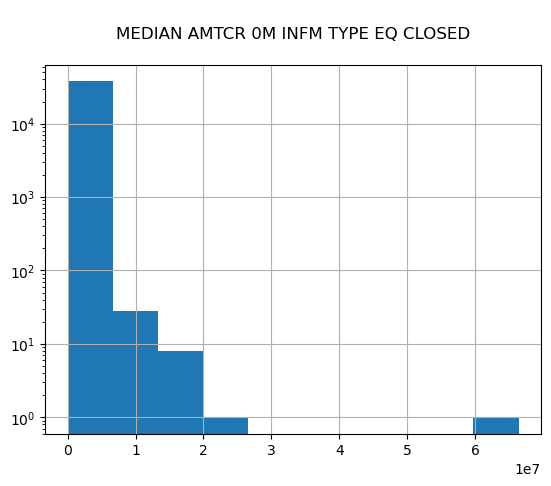

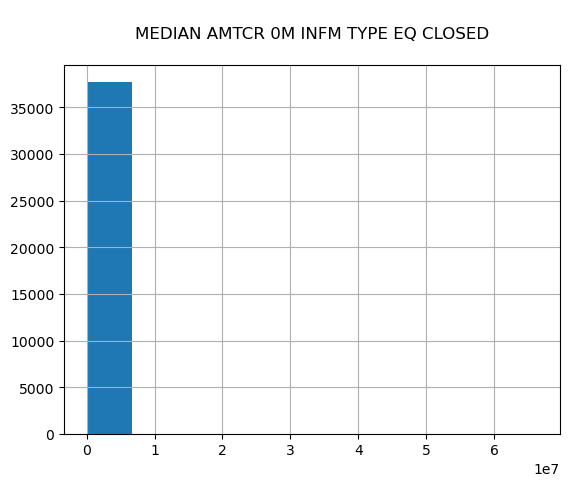

--------------------------------------------------
STD_AMTCR_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

21.37% above 0
78.07% is missing


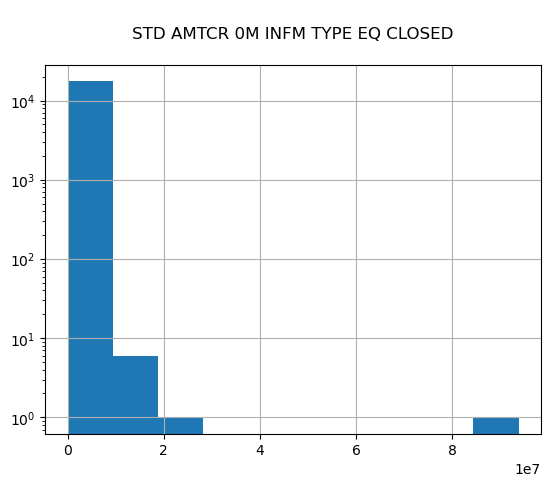

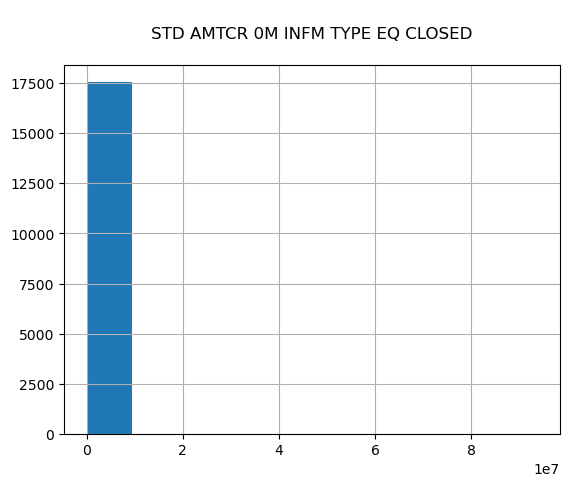

--------------------------------------------------
MIN_AMTCR_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

1.37% above 0
98.60% is missing


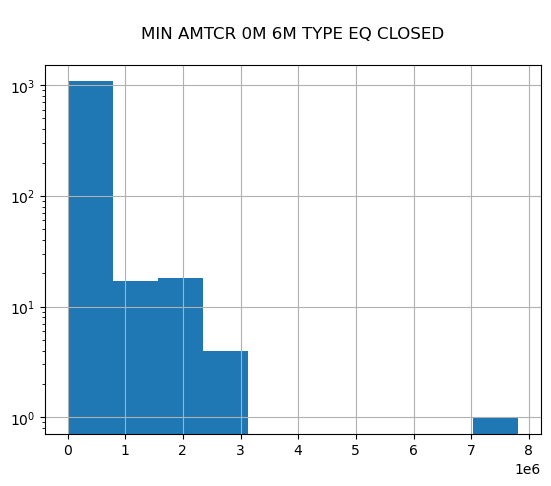

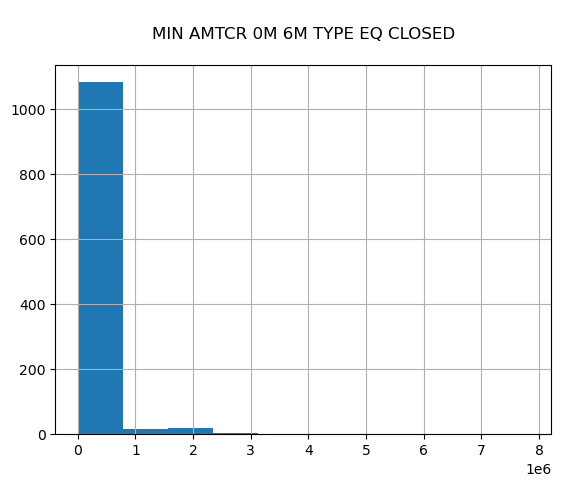

--------------------------------------------------
MAX_AMTCR_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

1.37% above 0
98.60% is missing


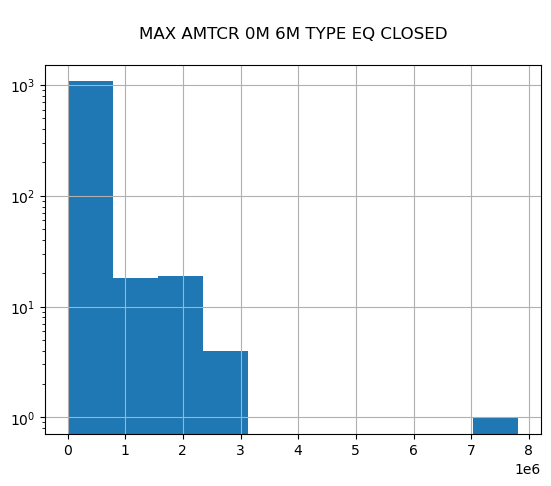

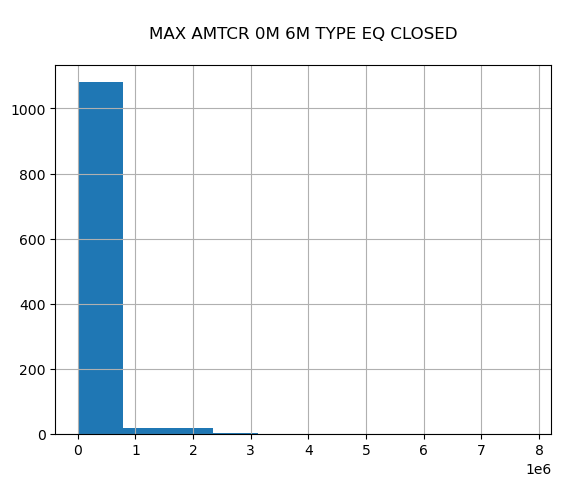

--------------------------------------------------
MEAN_AMTCR_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

1.37% above 0
98.60% is missing


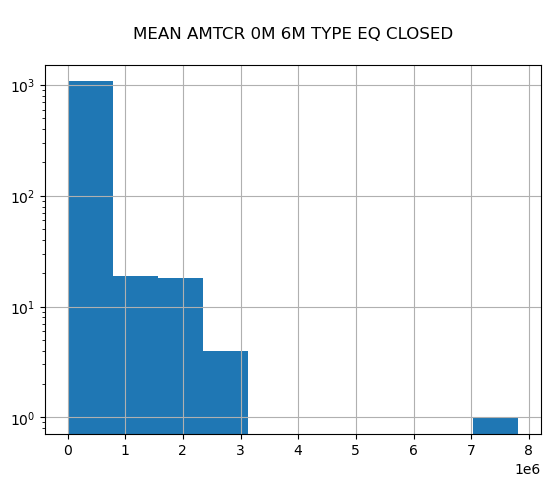

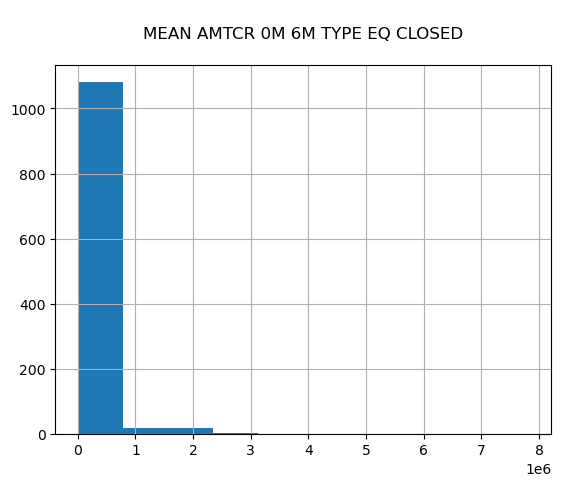

--------------------------------------------------
MEDIAN_AMTCR_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

1.37% above 0
98.60% is missing


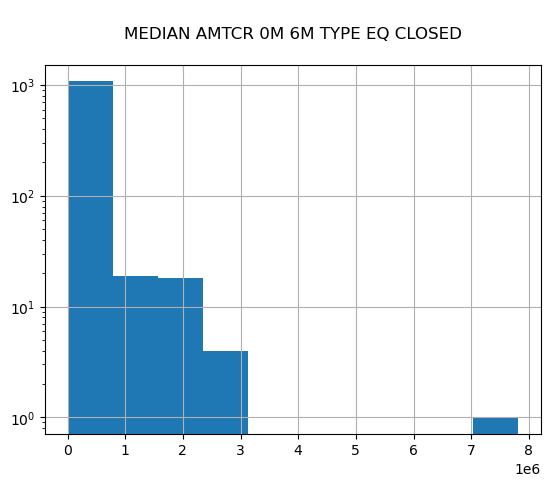

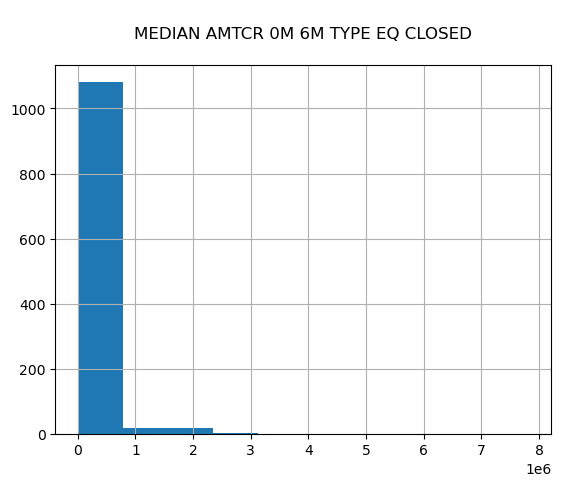

--------------------------------------------------
STD_AMTCR_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

0.19% above 0
99.75% is missing


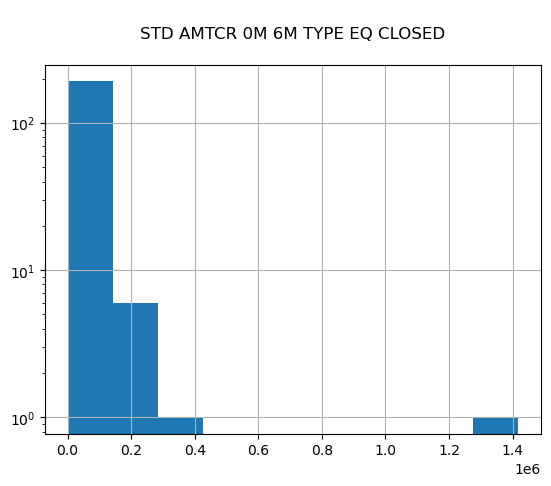

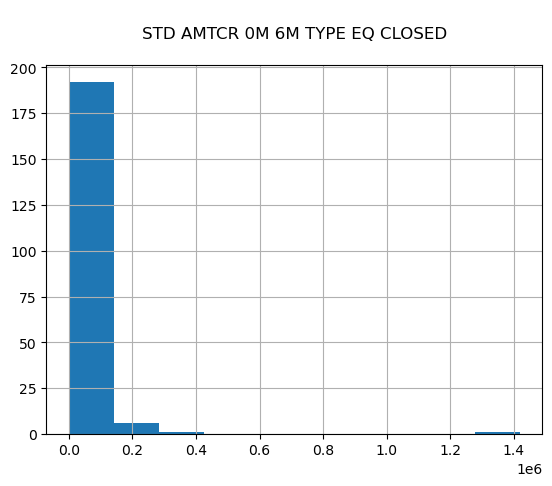

--------------------------------------------------
MIN_DPD_0M_INFM
--------------------------------------------------

0.08% above 0
37.94% is missing


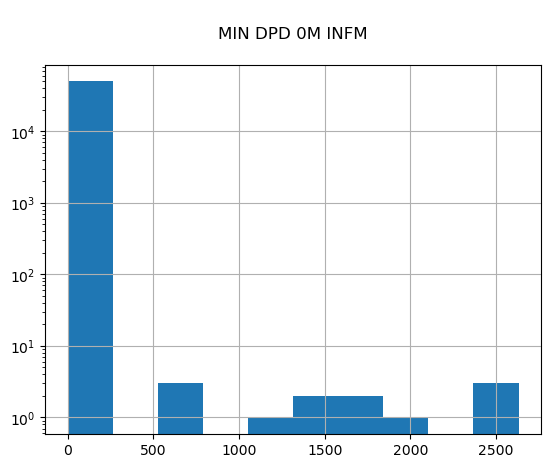

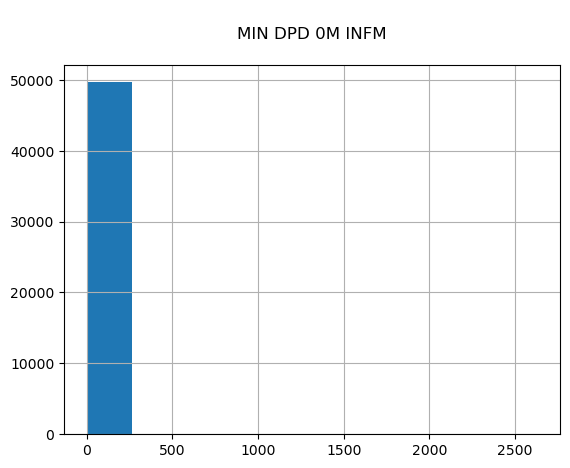

--------------------------------------------------
MAX_DPD_0M_INFM
--------------------------------------------------

0.31% above 0
37.94% is missing


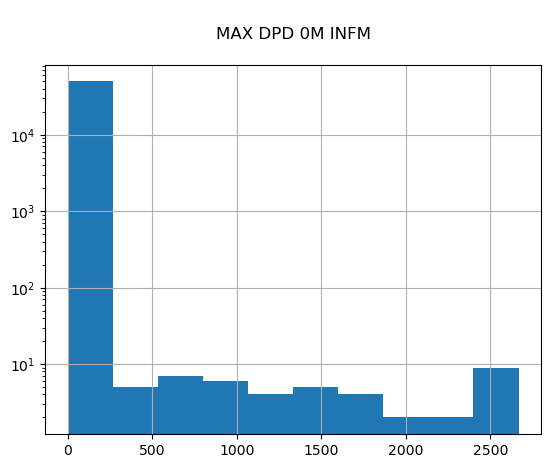

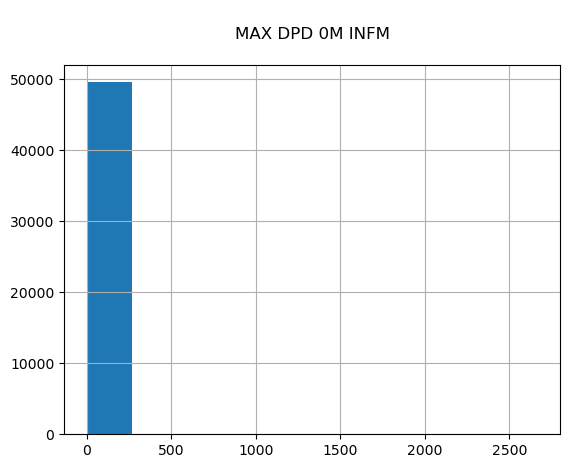

--------------------------------------------------
MEAN_DPD_0M_INFM
--------------------------------------------------

0.31% above 0
37.94% is missing


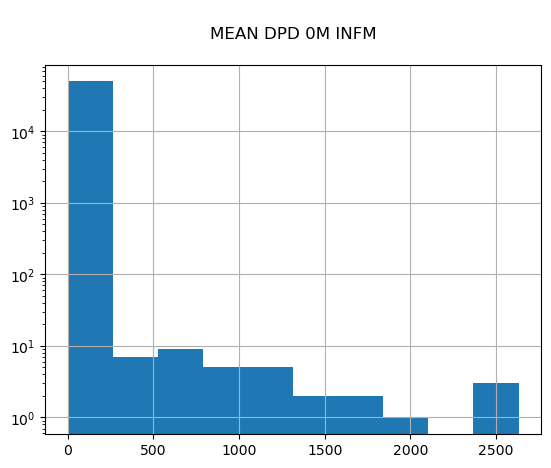

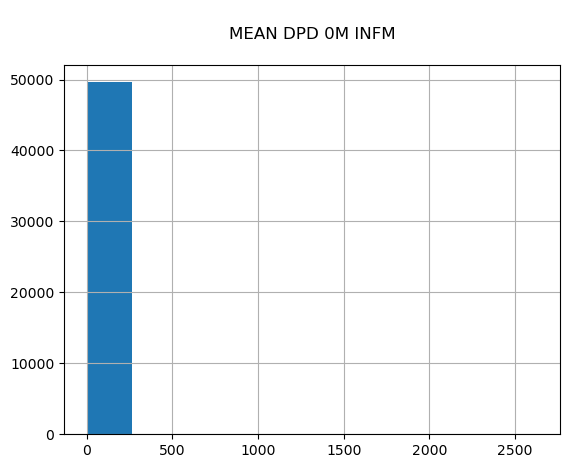

--------------------------------------------------
MEDIAN_DPD_0M_INFM
--------------------------------------------------

0.18% above 0
37.94% is missing


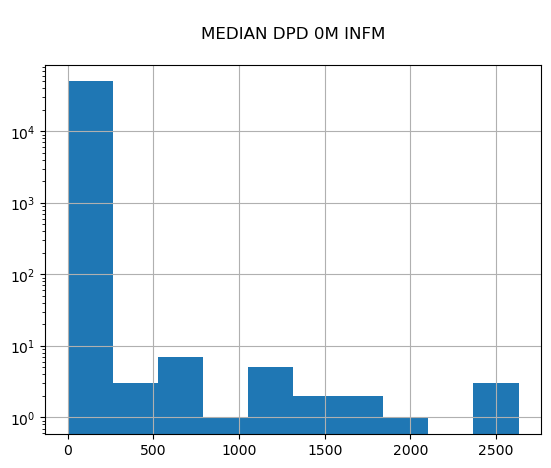

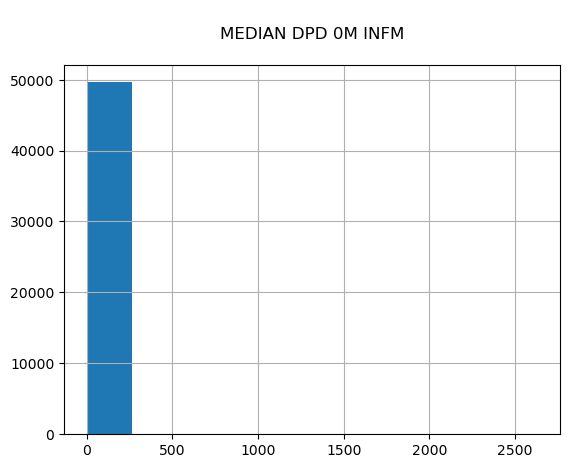

--------------------------------------------------
STD_DPD_0M_INFM
--------------------------------------------------

0.24% above 0
64.20% is missing


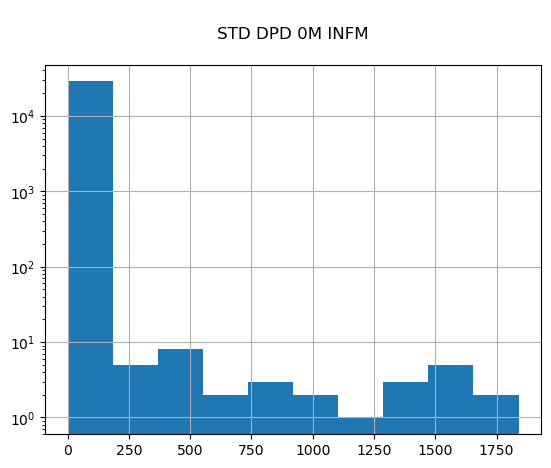

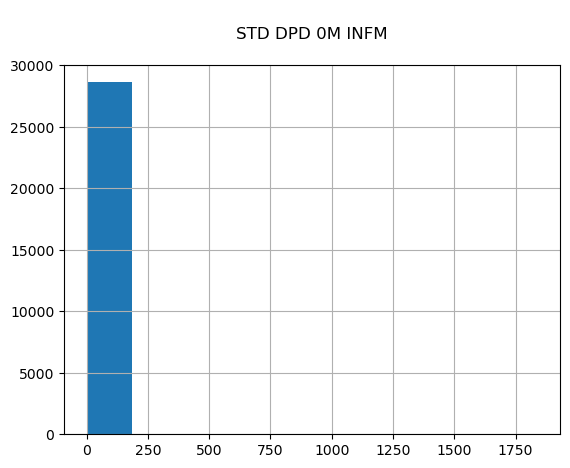

--------------------------------------------------
MIN_DPD_0M_6M
--------------------------------------------------

0.04% above 0
89.59% is missing


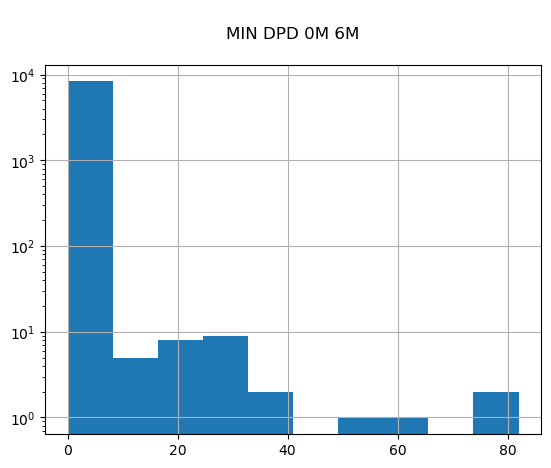

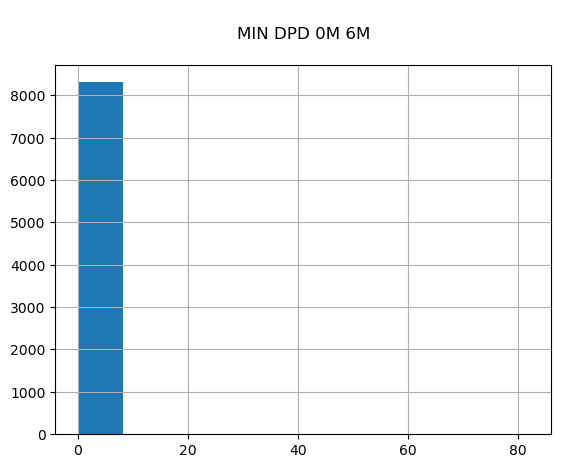

--------------------------------------------------
MAX_DPD_0M_6M
--------------------------------------------------

0.04% above 0
89.59% is missing


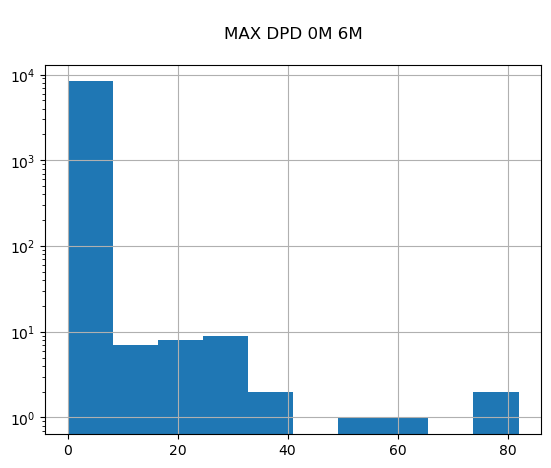

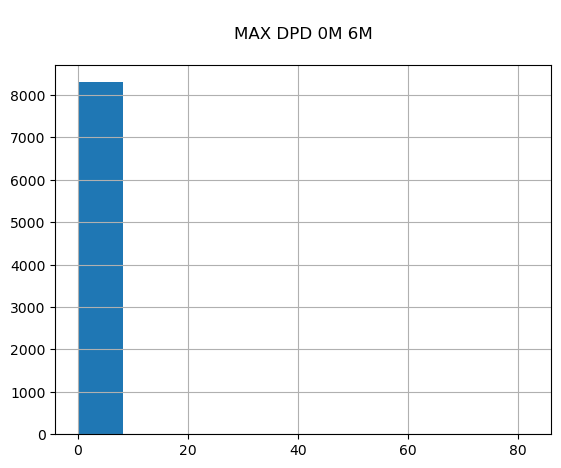

--------------------------------------------------
MEAN_DPD_0M_6M
--------------------------------------------------

0.04% above 0
89.59% is missing


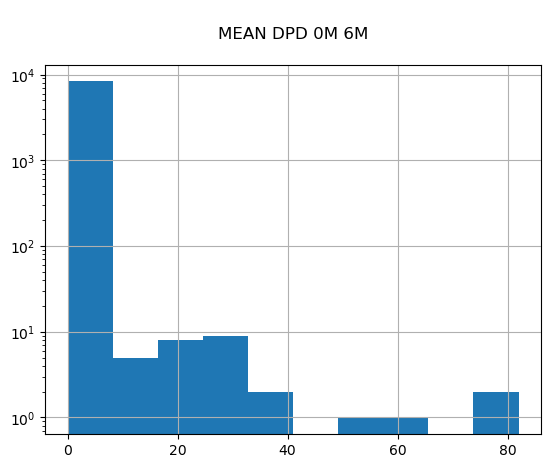

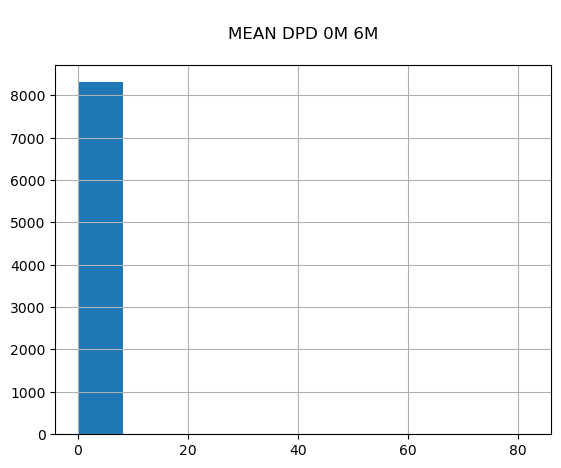

--------------------------------------------------
MEDIAN_DPD_0M_6M
--------------------------------------------------

0.04% above 0
89.59% is missing


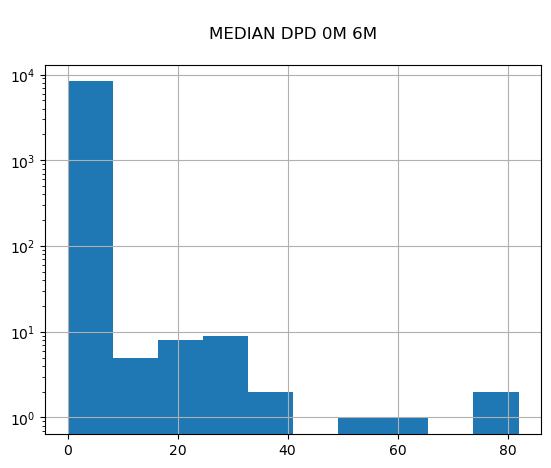

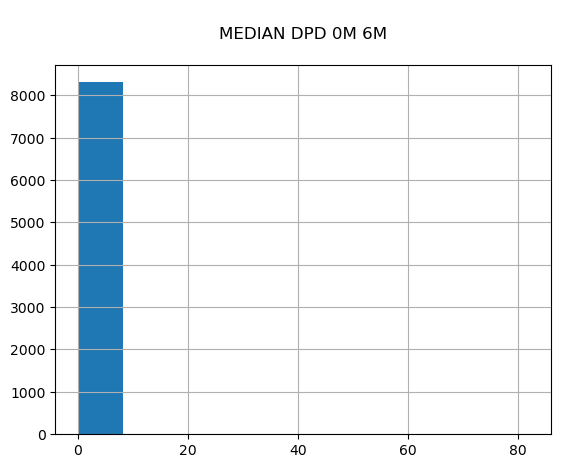

--------------------------------------------------
STD_DPD_0M_6M
--------------------------------------------------

98.76% is missing


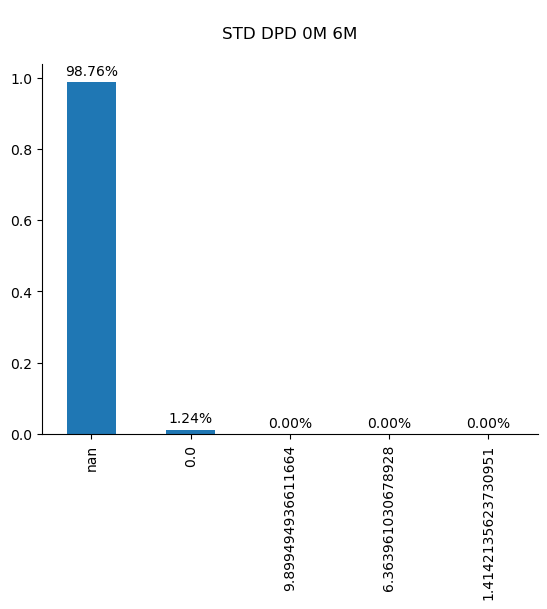

--------------------------------------------------
MIN_DPD_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

0.16% above 0
63.18% is missing


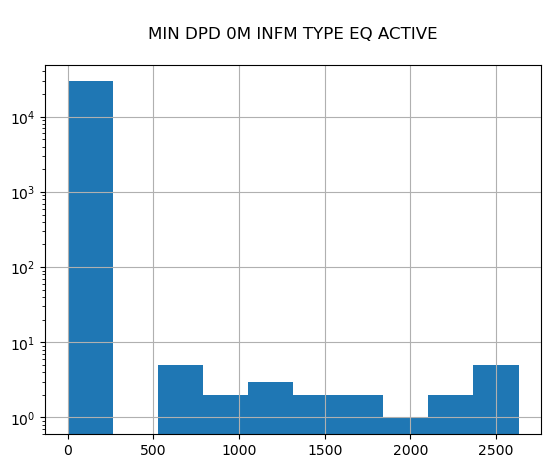

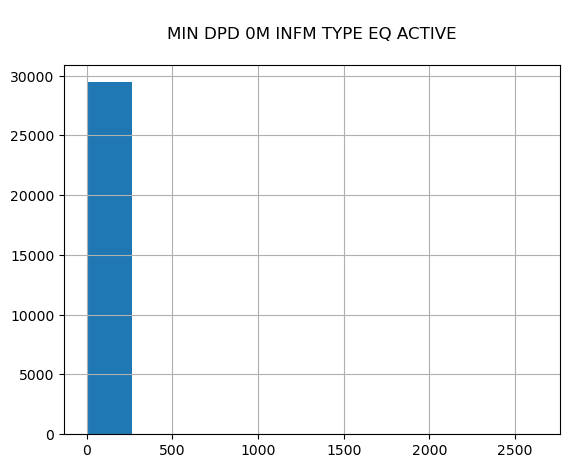

--------------------------------------------------
MAX_DPD_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

0.31% above 0
63.18% is missing


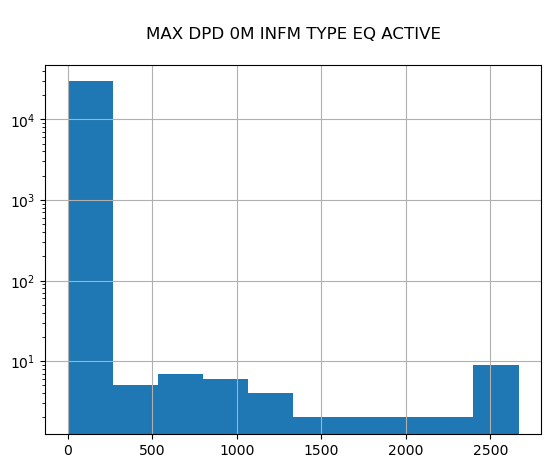

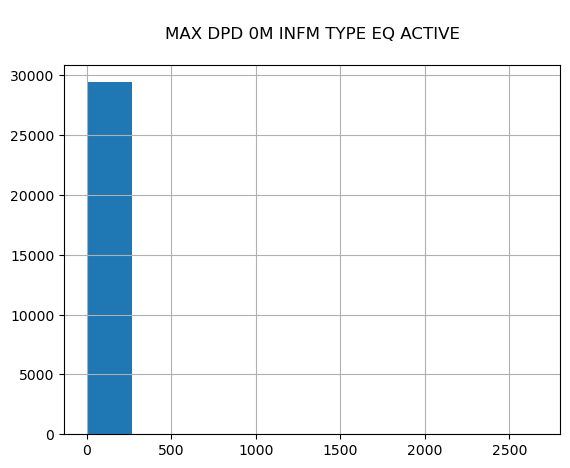

--------------------------------------------------
MEAN_DPD_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

0.31% above 0
63.18% is missing


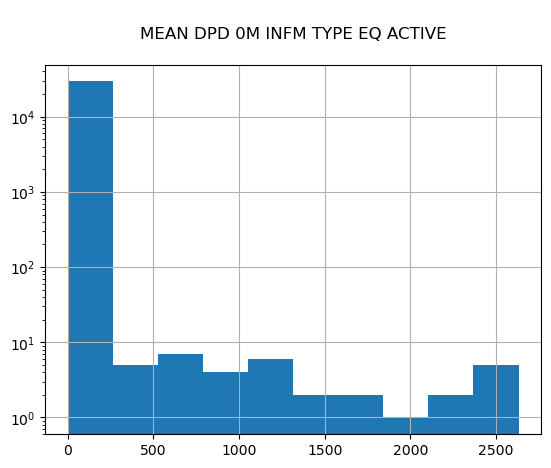

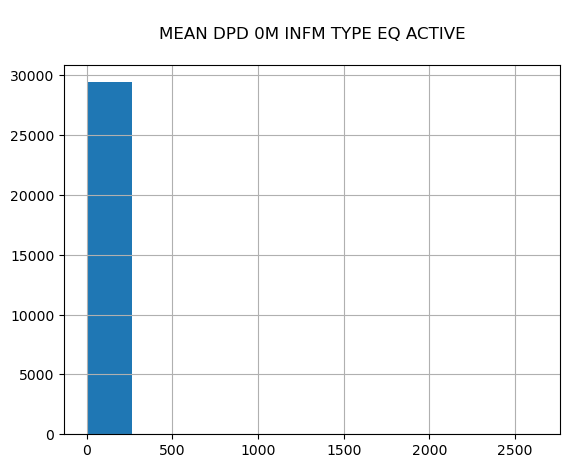

--------------------------------------------------
MEDIAN_DPD_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

0.26% above 0
63.18% is missing


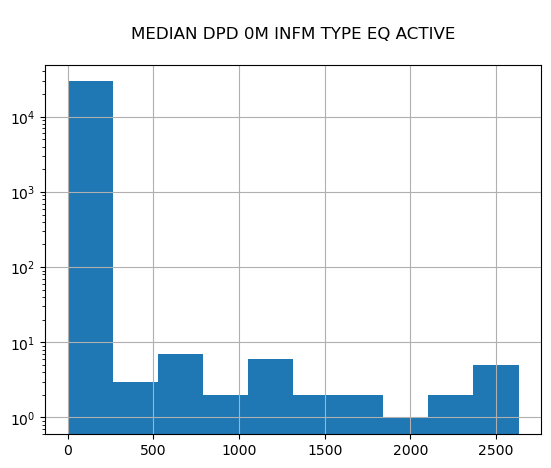

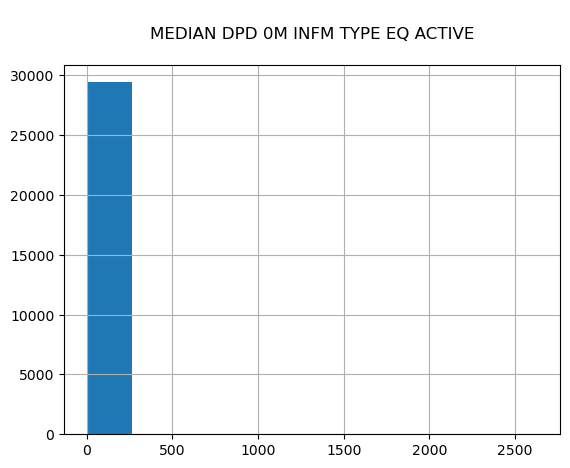

--------------------------------------------------
STD_DPD_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

0.15% above 0
89.13% is missing


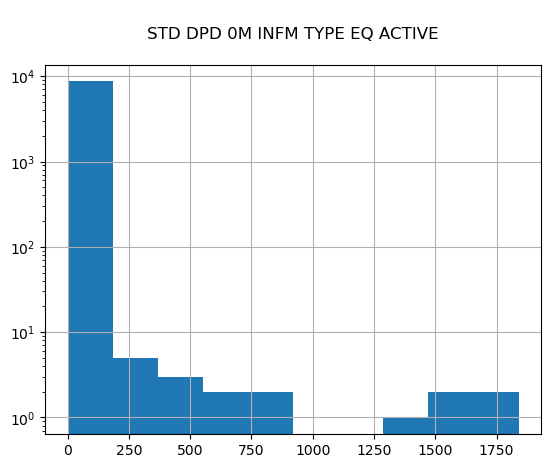

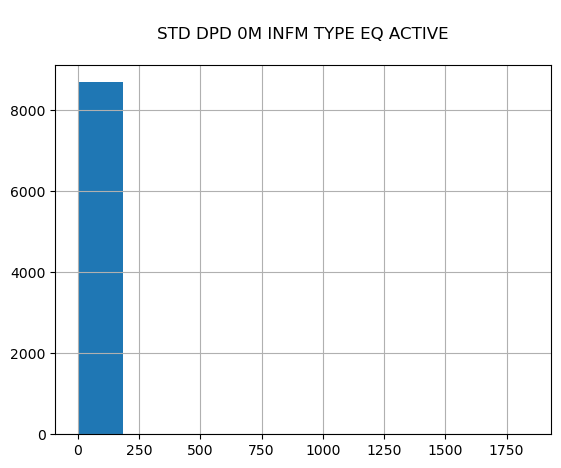

--------------------------------------------------
MIN_DPD_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

0.04% above 0
90.62% is missing


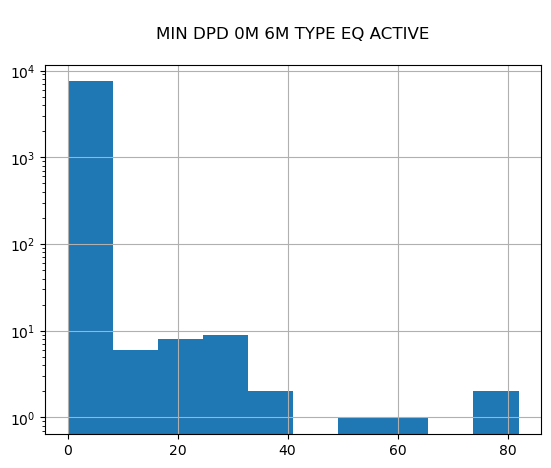

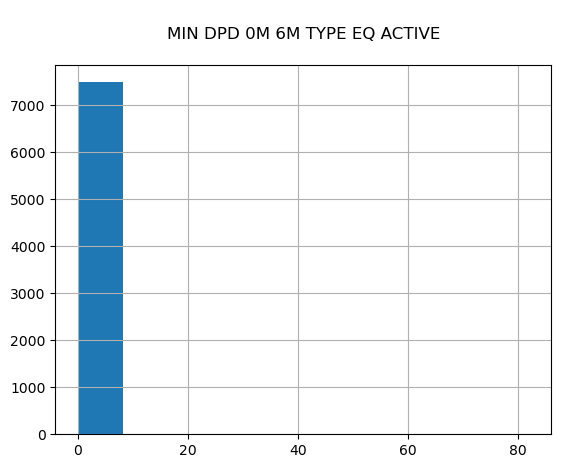

--------------------------------------------------
MAX_DPD_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

0.04% above 0
90.62% is missing


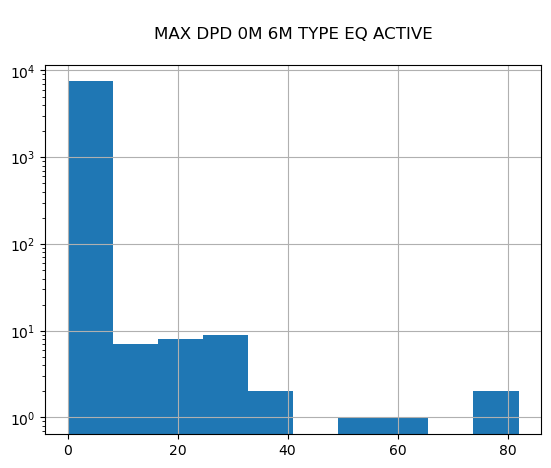

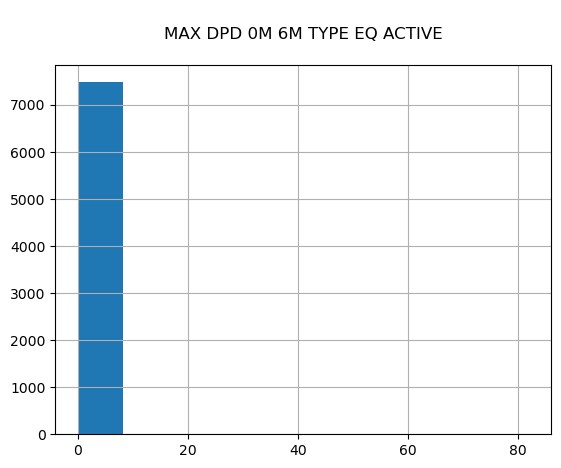

--------------------------------------------------
MEAN_DPD_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

0.04% above 0
90.62% is missing


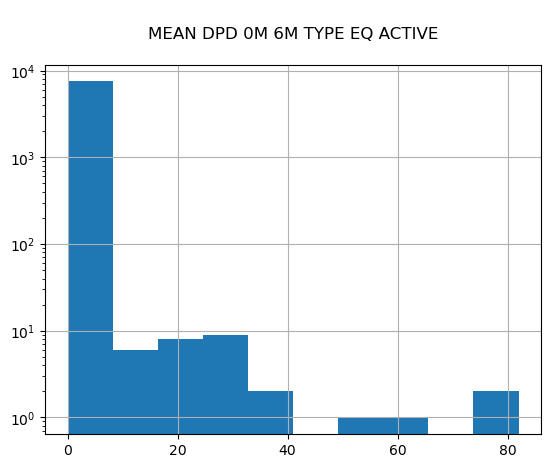

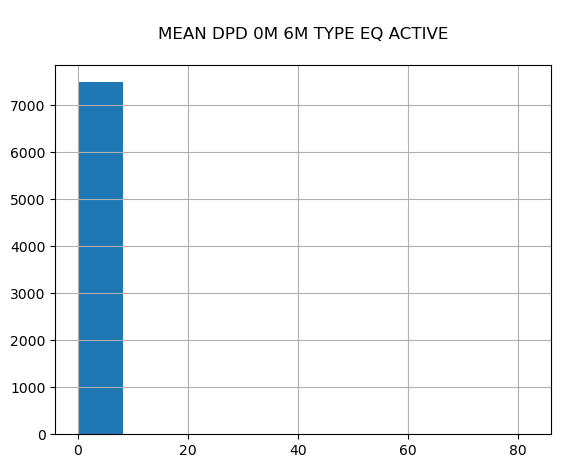

--------------------------------------------------
MEDIAN_DPD_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

0.04% above 0
90.62% is missing


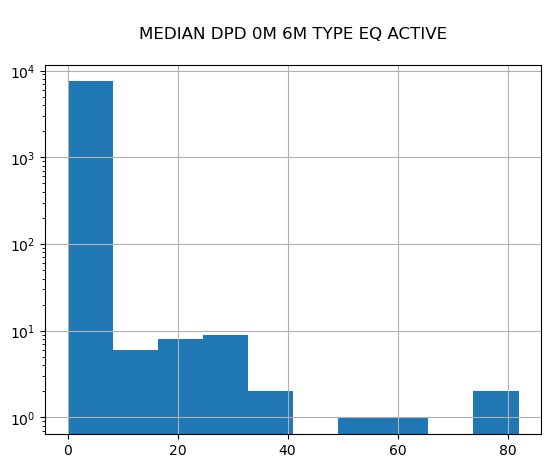

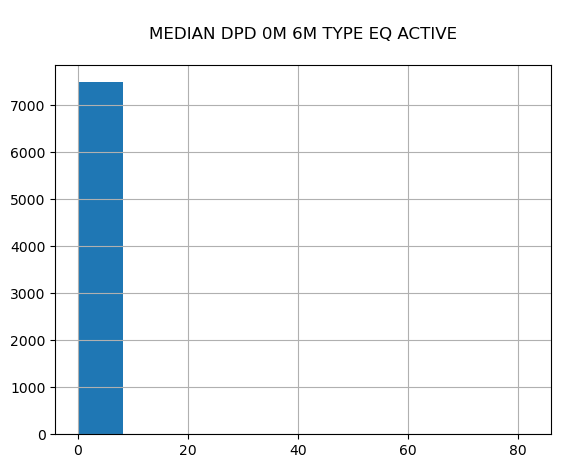

--------------------------------------------------
STD_DPD_0M_6M_TYPE_EQ_ACTIVE
--------------------------------------------------

99.21% is missing


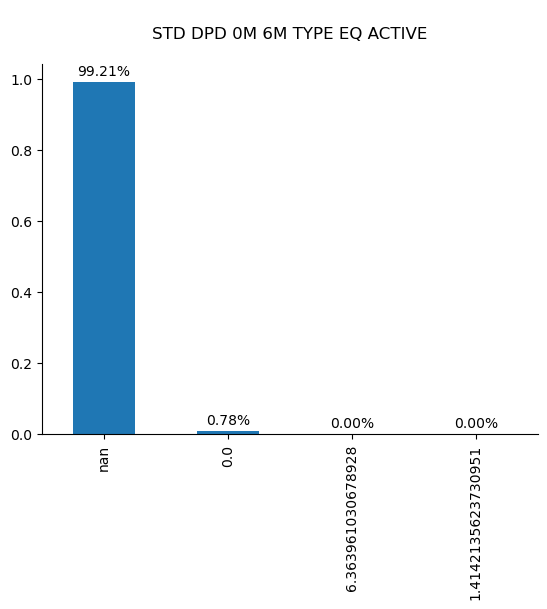

--------------------------------------------------
MIN_DPD_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

52.82% is missing


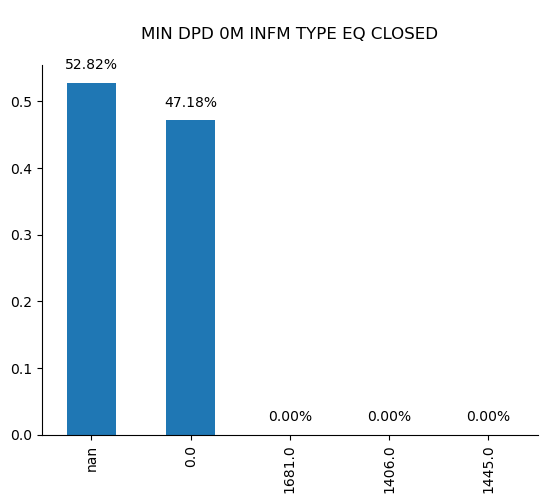

--------------------------------------------------
MAX_DPD_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

52.82% is missing


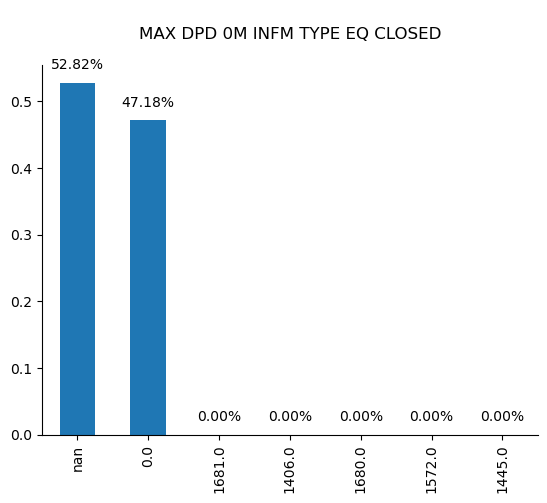

--------------------------------------------------
MEAN_DPD_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

52.82% is missing


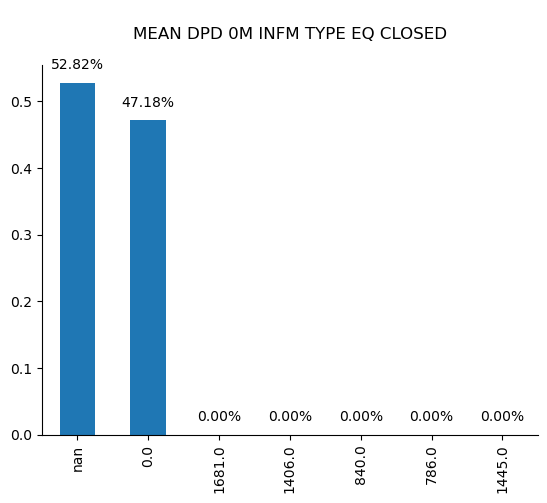

--------------------------------------------------
MEDIAN_DPD_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

52.82% is missing


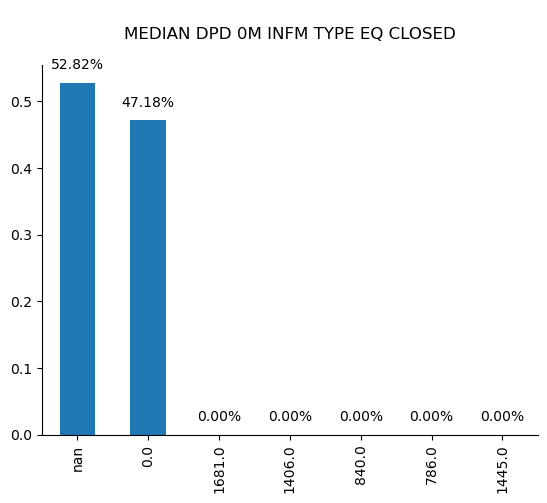

--------------------------------------------------
STD_DPD_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

78.07% is missing


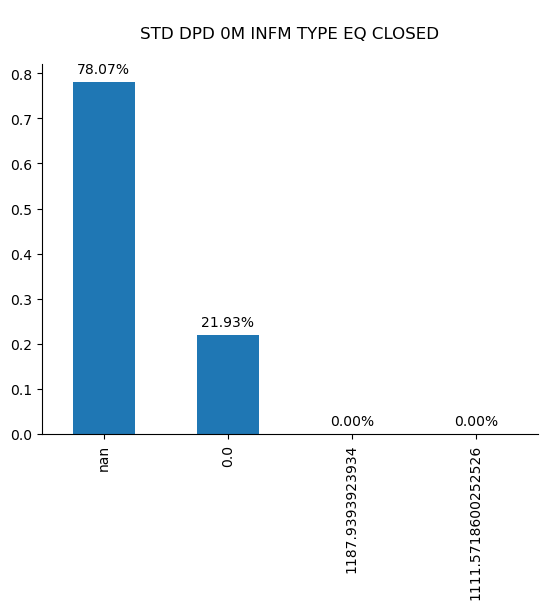

--------------------------------------------------
MIN_DPD_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

MIN_DPD_0M_6M_TYPE_EQ_CLOSED - only constant with value [nan  0.]
--------------------------------------------------
MAX_DPD_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

MAX_DPD_0M_6M_TYPE_EQ_CLOSED - only constant with value [nan  0.]
--------------------------------------------------
MEAN_DPD_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

MEAN_DPD_0M_6M_TYPE_EQ_CLOSED - only constant with value [nan  0.]
--------------------------------------------------
MEDIAN_DPD_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

MEDIAN_DPD_0M_6M_TYPE_EQ_CLOSED - only constant with value [nan  0.]
--------------------------------------------------
STD_DPD_0M_6M_TYPE_EQ_CLOSED
--------------------------------------------------

STD_DPD_0M_6M_TYPE_EQ_CLOSED - only constant with value [nan  0.]
--

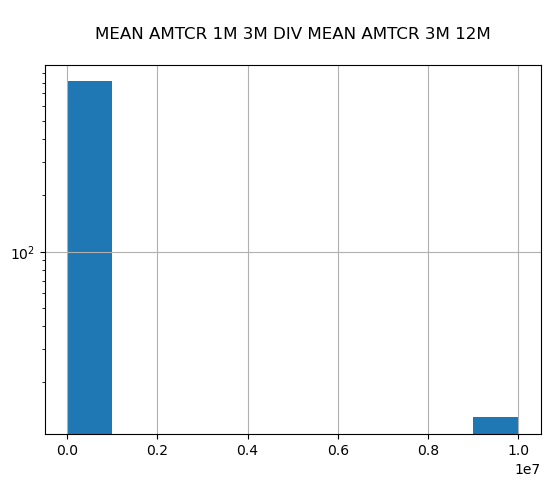

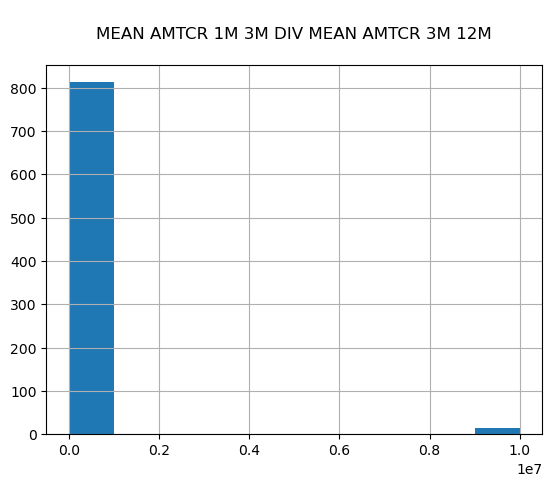

--------------------------------------------------
MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE
--------------------------------------------------

0.59% above 0
99.40% is missing


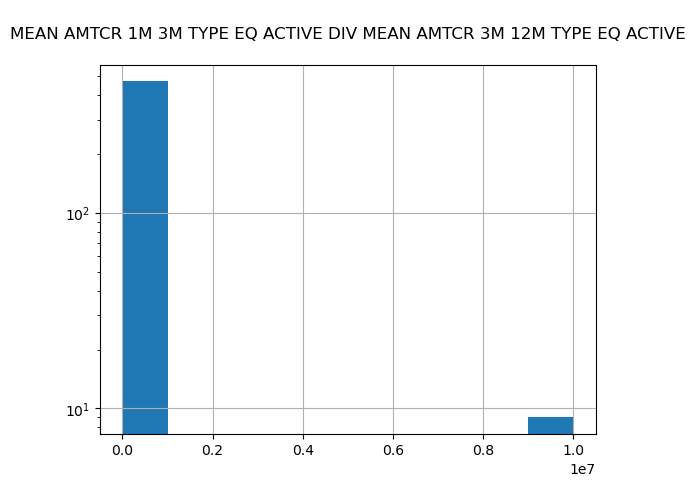

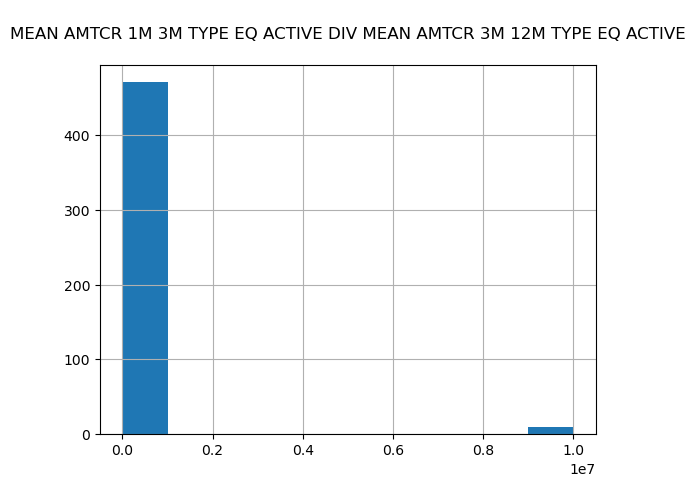

--------------------------------------------------
MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED
--------------------------------------------------

0.17% above 0
99.83% is missing


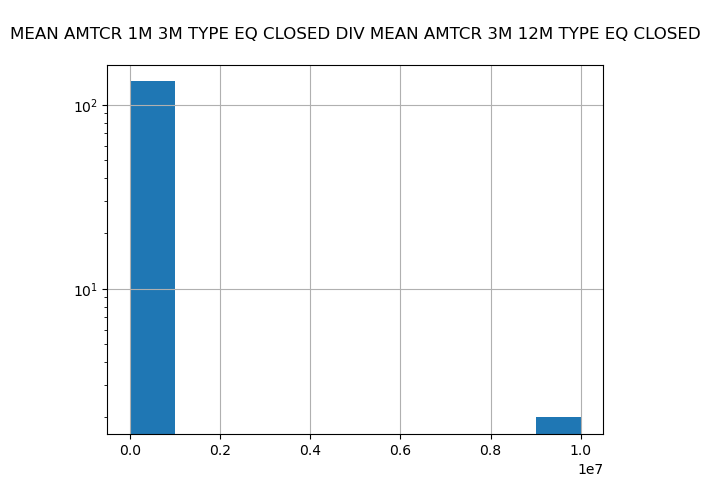

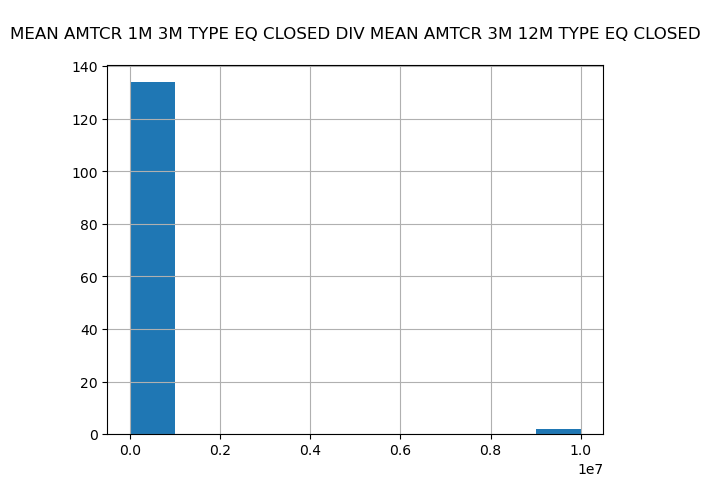

--------------------------------------------------
MEAN_AMTCR_OVERDUE_0M_INFM_DIV_MEAN_AMTCR_0M_INFM
--------------------------------------------------

0.31% above 0
38.86% is missing


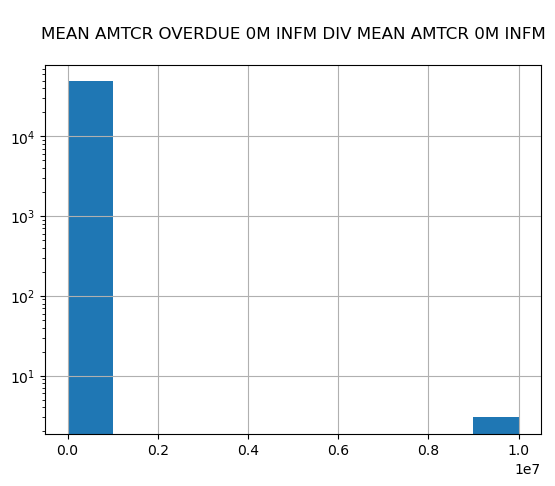

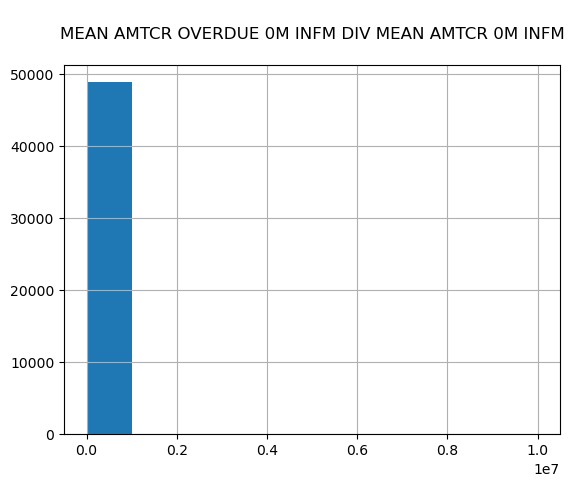

--------------------------------------------------
MEAN_AMTCR_OVERDUE_0M_12M_DIV_MEAN_AMTCR_0M_12M
--------------------------------------------------

0.10% above 0
78.86% is missing


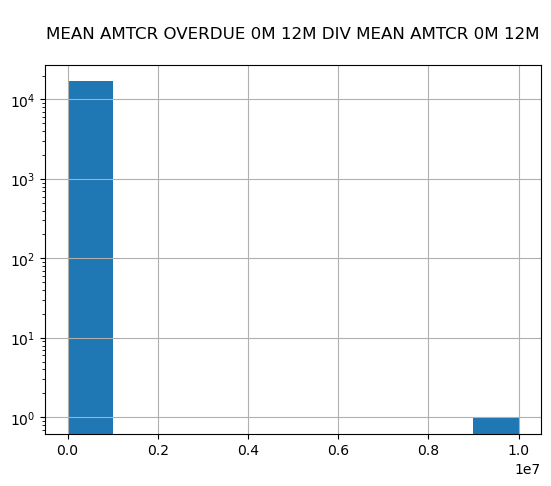

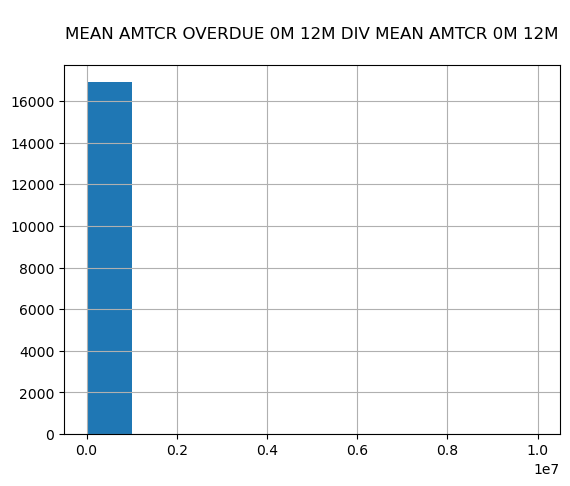

--------------------------------------------------
MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE
--------------------------------------------------

0.30% above 0
64.49% is missing


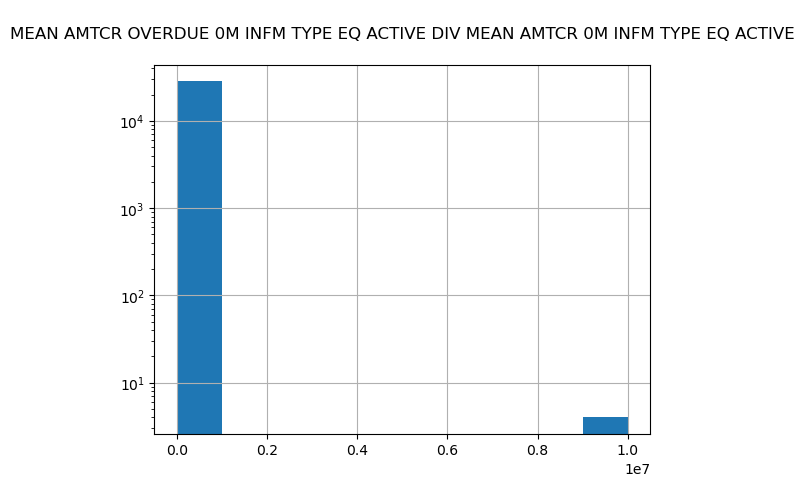

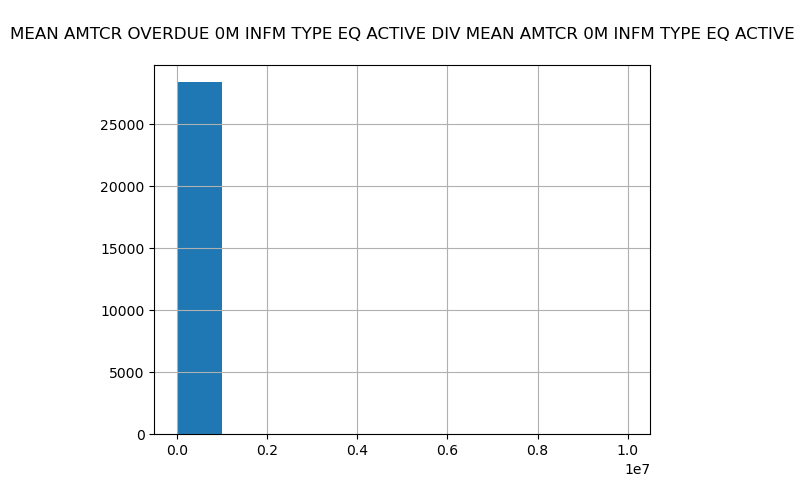

--------------------------------------------------
MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_ACTIVE
--------------------------------------------------

0.10% above 0
82.20% is missing


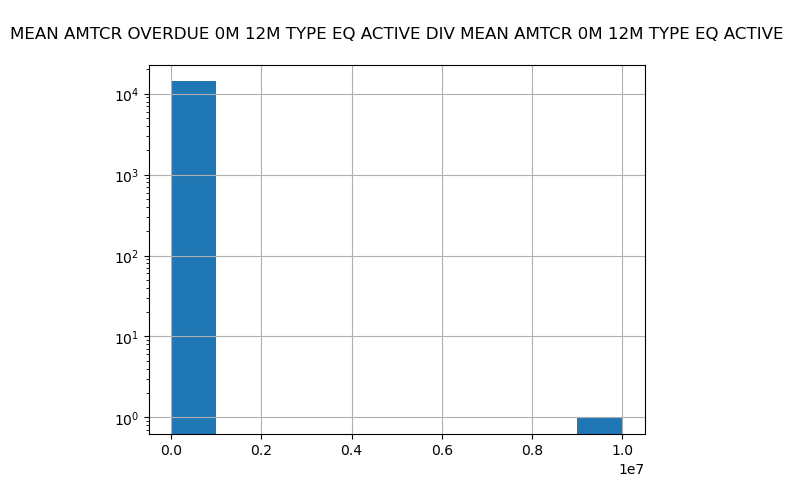

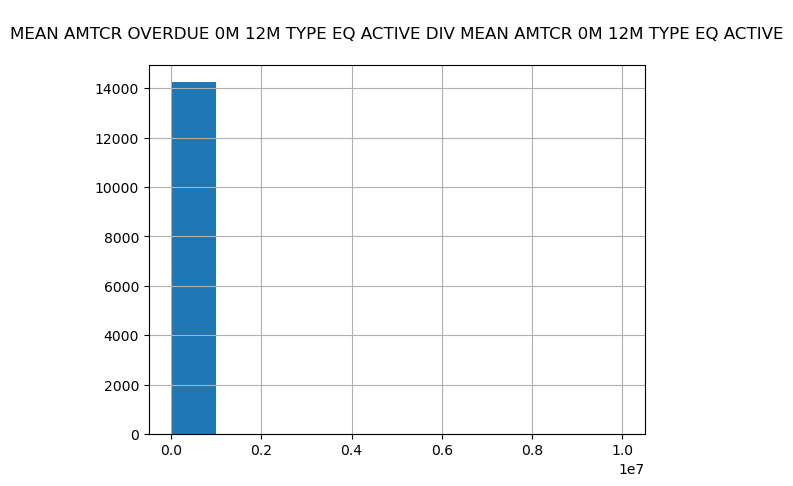

--------------------------------------------------
MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED
--------------------------------------------------

53.55% is missing


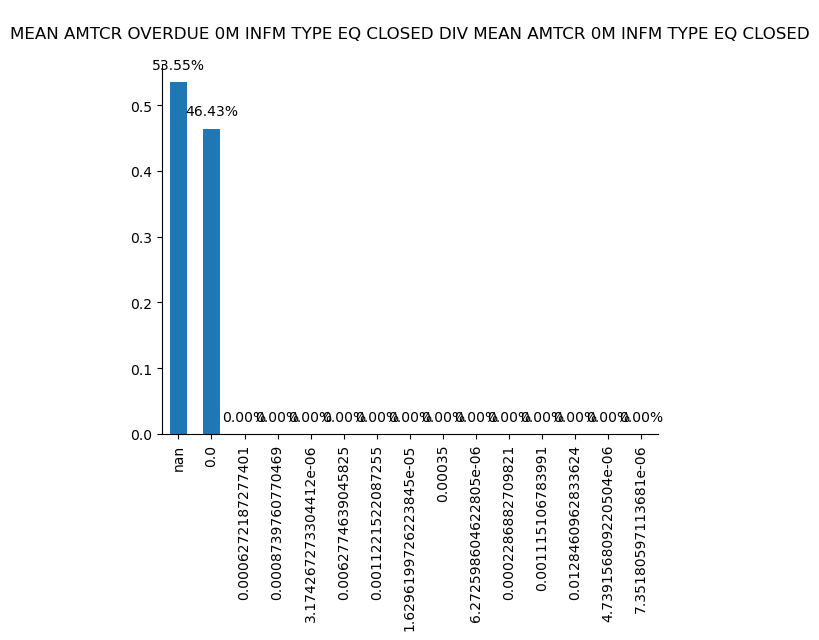

--------------------------------------------------
MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_CLOSED
--------------------------------------------------

MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_CLOSED - only constant with value [nan  0.]
--------------------------------------------------
FIRST_TRANSACTION_TIME_MONTHS
--------------------------------------------------

62.06% above 0
37.94% is missing


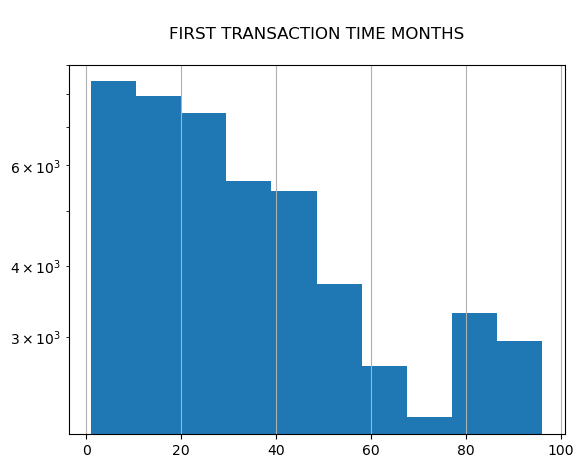

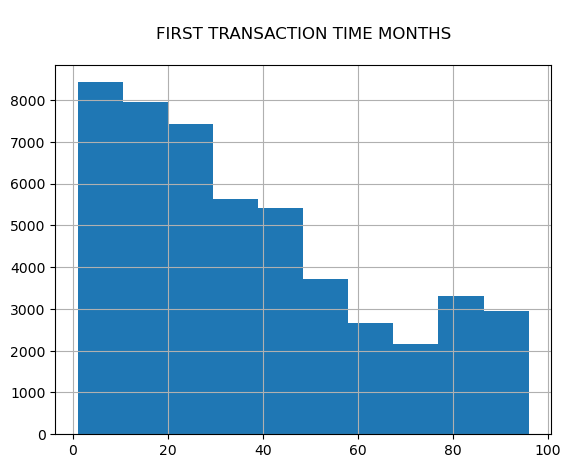

--------------------------------------------------
LAST_TRANSACTION_TIME_MONTHS
--------------------------------------------------

62.06% above 0
37.94% is missing


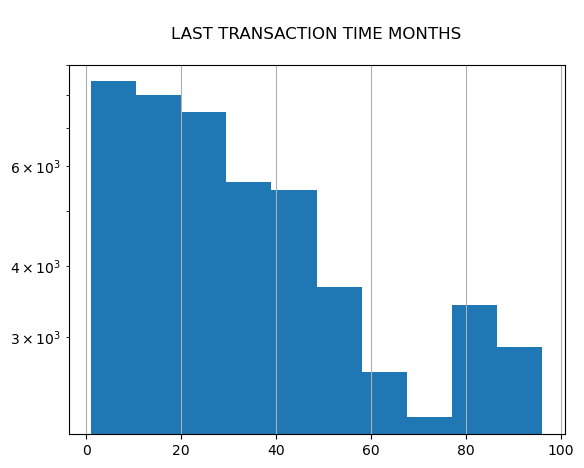

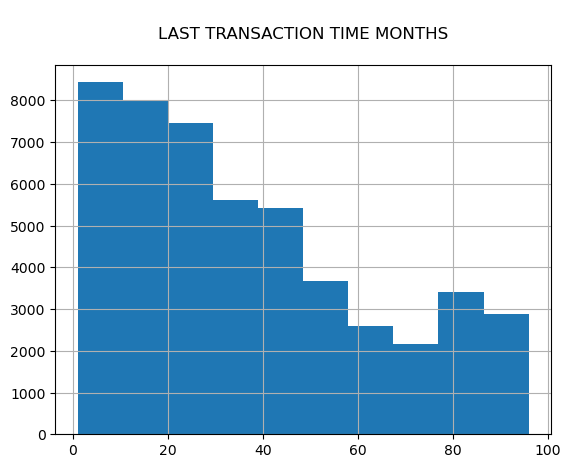

--------------------------------------------------
TIME
--------------------------------------------------

0.00% is missing


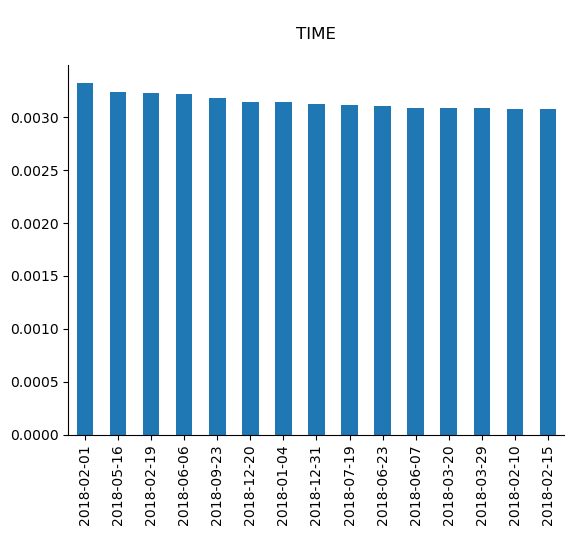

--------------------------------------------------
BASE
--------------------------------------------------

BASE - only constant with value [1]
--------------------------------------------------
DAY
--------------------------------------------------

100.00% above 0
0.00% is missing


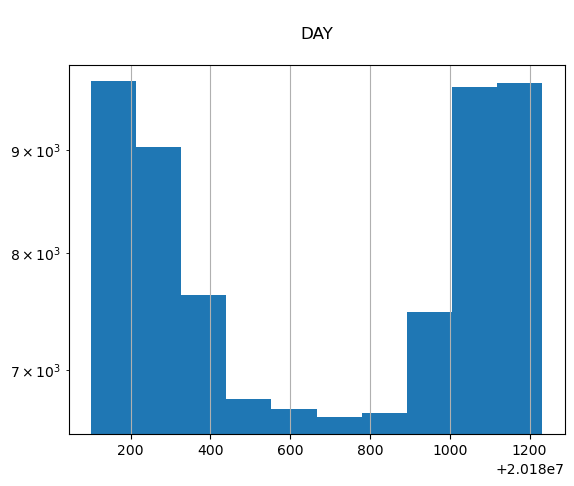

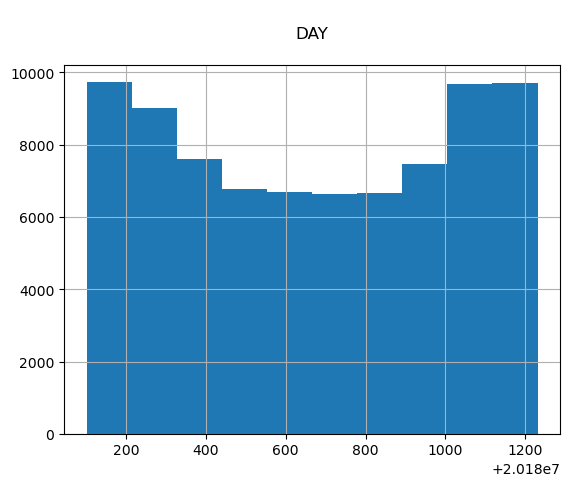

--------------------------------------------------
MONTH
--------------------------------------------------

0.00% is missing


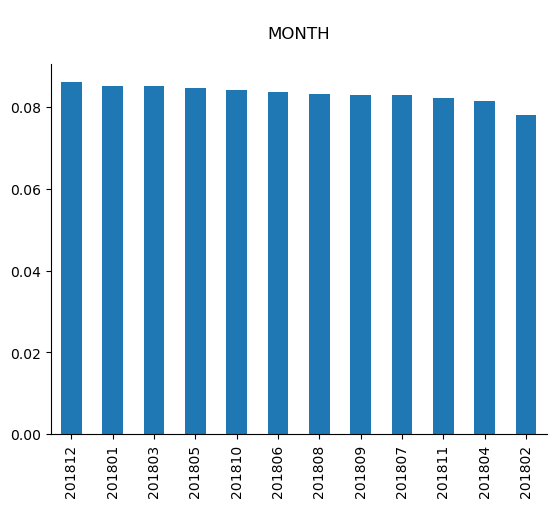

--------------------------------------------------
SAMPLE
--------------------------------------------------

0.00% is missing


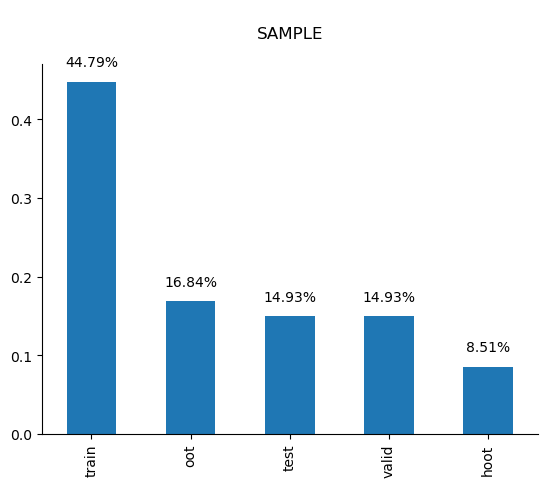

In [25]:
plot_columns(data.columns, data)

In [26]:
data['CODE_GENDER'].value_counts()

F      52488
M      27510
XNA        2
Name: CODE_GENDER, dtype: int64

### Check suspicious variable

In [27]:
data[['FIRST_TRANSACTION_TIME_MONTHS', 'LAST_TRANSACTION_TIME_MONTHS']]

FIRST_TRANSACTION_TIME_MONTHS  LAST_TRANSACTION_TIME_MONTHS
SK_ID_CURR                                                             
215138                               37.0                          28.0
325963                                3.0                          18.0
206923                               73.0                          61.0
265855                               36.0                           4.0
359795                               12.0                          12.0
...                                   ...                           ...
203263                               19.0                          36.0
304373                               40.0                          40.0
348873                                1.0                          38.0
296666                                3.0                           3.0
259380                               32.0                          32.0

[80000 rows x 2 columns]

In [28]:
(data['FIRST_TRANSACTION_TIME_MONTHS']>= data['LAST_TRANSACTION_TIME_MONTHS']).sum()

36158

<span style="color:red">**TO DO:** Explore more, find more suspicious variables, try to understand the data! </span>

In [ ]:
#skuska

## Missing data

In [ ]:
# define function that plots share of null values in time for given predictor
def share_of_nulls(dt, col_month, predictor):
    if dt[predictor].isnull().sum() == 0:
        return
    dt2 = dt[[col_month, predictor]]
    
    dt2 = dt2.assign(is_null=dt2[predictor].isnull().astype(int).values)
    dt_grp = dt2.groupby(col_month).agg(
        share_of_nulls = ('is_null', np.mean)
    )
    
    plt.plot(range(len(dt_grp)), dt_grp['share_of_nulls'], marker = 'o')
    plt.xticks(range(len(dt_grp)), dt_grp.index, rotation = 90)
    plt.title(predictor)
    plt.xlabel('month', loc='right')
    plt.ylabel('null share', loc='top')
    plt.ylim([0,1])
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')    
    
    plt.show()

In [ ]:
for pred in data.columns:
    share_of_nulls(data, col_month, pred)

## Related to target

In [ ]:
# define function that plots default rate in time
def default_rate_across_group(data, col_group, col_target, yright_lim = None):
    dt = data.copy()
    k = int(dt[col_group].nunique())
    
    if (k > 10) and dt[col_group].dtype != 'O':
        dt[col_group] = pd.qcut(dt[col_group], q=10, duplicates='drop')
    
    dt_grp = dt.groupby(col_group).agg(
        tot_cnt = (col_target, len),
        default_rate = (col_target, np.mean)
    )
    
    ax1 = plt.subplot(111)
    ax1.bar(range(len(dt_grp)), dt_grp['tot_cnt'])
    ax1.set_xticks(range(len(dt_grp)))
    ax1.set_xticklabels(dt_grp.index, rotation = 90)
    ax1.set_xlabel(col_group)
    ax1.set_ylabel('count', loc='top')
    ax1.spines['right'].set_color('gray')
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.tick_params(axis='y', colors='gray')
    ax1.tick_params(axis='x', colors='gray')    
    
    ax2 = ax1.twinx()
    ax2.plot(range(len(dt_grp)), dt_grp['default_rate'], marker ='o', color = 'red')
    ax2.set_ylabel('default rate', loc='top', color='red')
    if yright_lim is not None:
        ax2.set_ylim(yright_lim)
    ax2.spines['right'].set_color('gray')
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_color('gray')
    ax2.spines['bottom'].set_color('gray')
    ax2.tick_params(axis='y', colors='gray')
    ax2.tick_params(axis='x', colors='gray')
    
    plt.show()

In [ ]:
default_rate_across_group(data, col_month, col_target, yright_lim = [0, None])

In [ ]:
for col in cols_cat:
    default_rate_across_group(data, col, col_target, yright_lim = [0, None])

In [ ]:
for col in cols_num:
    if col=='TARGET':
        continue
    default_rate_across_group(data, col, col_target, yright_lim = [0, None])

## Select variables

<span style="color:red">**TO DO:** add more variables to the list in the next cell </span>

In [ ]:
dont_use_variables_as_predictors = [
    'TARGET'
    , 'MONTH'
    , 'TIME'
    , 'BASE'
    , 'DAY'
    , 'sample'
    , 'FIRST_TRANSACTION_TIME_MONTHS'
    , 'LAST_TRANSACTION_TIME_MONTHS'
    , 'CNT_CHILDREN'
]

cols_pred = cols.copy()
for variable in dont_use_variables_as_predictors:
    if variable in cols_pred:
        cols_pred.remove(variable)

In [ ]:
# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

# Feature engineering

## Automatic Grouping

### Create bins
- Remember, now we must take into account only training set

In [ ]:
# define bins for grouping numerical predictors
def get_grouping(dt, predictor, n_bins = 7):
    return np.unique([round(b, 4) for b in dt[predictor].quantile([i / n_bins for i in range(n_bins+1)])])

In [ ]:
predictor_grouping = {}
for col in tqdm(cols_pred_num):
    predictor_grouping[col] = get_grouping(data[train_mask], col)

In [ ]:
predictor_grouping

### Apply grouping

In [ ]:
for col in tqdm(cols_pred_num):
    data[col] = pd.cut(data[col], bins=predictor_grouping[col])
    
    # add 'missing' as a new category
    data[col] = data[col].values.add_categories('missing')
    
    # replace nans with 'missing', so it is easier to handle
    data[col].fillna('missing', inplace=True)
    
for col in tqdm(cols_pred_cat):
    data[col].fillna('missing', inplace=True)
    

In [ ]:
data

## Encode Categorical Predictors
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot DR_{category} + \alpha \cdot DR}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $DR_{category}$ default rate in this category and $DR$ is total default rate.

<span style="color:red">**TO DO:** Write mean_target_encoding function </span>

The function computes category encoding, you can just fill in this template to have an easier start:


    def mean_target_encoding(dt, predictor, target, alpha = 0.01):
        
        # compute total count and total default rate
        # groupby the category
        # compute category encoding
        
        # in the grouped dataframe, if there are some nan, just replace it with total default rate
        dt_grp['categ_encoding'].fillna(total_dr, inplace=True)
        
        return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [ ]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    pass

In [ ]:
total_dr = np.mean(data[train_mask][col_target])

for pred in tqdm(cols_pred.copy()):
    k = int(data[pred].nunique())
    
    if k <= 1:
        if pred in cols_pred:
            cols_pred.remove(pred)
            continue
            
    new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

    dt_grp = data.groupby(pred, dropna=False).agg(
            categ_dr = (col_target, np.mean),
            categ_cnt = (col_target, len)
        )

    additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
    for p in additional_values:
        new_vals[p] = total_dr

    data['MTE_' + pred] = data[pred].replace(new_vals)

    if 'MTE_' + pred not in cols_pred:
        cols_pred.append('MTE_' + pred)

    if pred in cols_pred:
        cols_pred.remove(pred)

In [ ]:
data

In [ ]:
cols_pred

## Check_grouping_stability

In [ ]:
def predictor_stability(dt, predictor, col_target, col_month):
    try:
        dt_grp = dt.groupby([col_month, predictor]).agg(
            obs_cnt = (col_target, len),
            default_rate = (col_target, np.mean)
        )
        dt_grp.reset_index(inplace = True)

        dt_grp_pivot = dt_grp.pivot(index = col_month, columns = predictor, values = 'default_rate')

        fig, axs = plt.subplots(1, 2, figsize = (12,4))
        fig.suptitle(predictor)
        for col in dt_grp_pivot.columns:
            axs[0].plot(range(len(dt_grp_pivot)), dt_grp_pivot[col], label = f'{col:.4f}')

        axs[0].set_xticks(range(len(dt_grp_pivot)))
        axs[0].set_xticklabels(dt_grp_pivot.index, rotation = 90)
        axs[0].set_xlabel('month', loc='right')
        axs[0].set_ylabel('default_rate', loc='top')
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['left'].set_color('gray')
        axs[0].spines['bottom'].set_color('gray')
        axs[0].tick_params(axis='y', colors='gray')
        axs[0].tick_params(axis='x', colors='gray') 
        axs[0].legend(loc = 'best')

        dt_grp_pivot = dt_grp.pivot(index = col_month, columns = predictor, values = 'obs_cnt')
        dt_grp_pivot['tot_cnt'] = dt_grp_pivot.sum(axis = 1)

        for col in dt_grp_pivot.columns:
            dt_grp_pivot[col] /= dt_grp_pivot['tot_cnt']
        del dt_grp_pivot['tot_cnt']

        for col in dt_grp_pivot.columns:
            axs[1].plot(range(len(dt_grp_pivot)), dt_grp_pivot[col], label = f'{col:.4f}')

        axs[1].set_xticks(range(len(dt_grp_pivot)))
        axs[1].set_xticklabels(dt_grp_pivot.index, rotation = 90)
        axs[1].set_xlabel('month', loc='right')
        axs[1].set_ylabel('frequency', loc='top')
        axs[1].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_color('gray')
        axs[1].spines['bottom'].set_color('gray')
        axs[1].tick_params(axis='y', colors='gray')
        axs[1].tick_params(axis='x', colors='gray') 
        axs[1].legend(loc = 'best')

        plt.show()
    except:
        print(f'Predictor {predictor} failed')

In [ ]:
for pred in cols_pred:
    predictor_stability(data, pred, col_target, col_month)

# Logistic Regression

## No penalty

In [ ]:
# fit logistig regression with all predictors
logreg = LogisticRegression(
    penalty = 'none',
    max_iter = 5000
)

logreg.fit(data[train_mask][cols_pred], data[train_mask][col_target])

In [ ]:
# print predictor coefficients (sorted by magnitude)
preds_coef = []
for pred, coef in zip(cols_pred, logreg.coef_[0]):
    preds_coef += [(pred, coef)]
    
sorted(preds_coef, key = lambda x: abs(x[1]), reverse = True)[0:15]

In [ ]:
# predict probability
data = data.assign(prediction = logreg.predict_proba(data[cols_pred])[:,1])

In [ ]:
# calculate gini for different samples
col_score = 'prediction'

gini_hoot  = 2 * roc_auc_score(data[hoot_mask][col_target],  data[hoot_mask] [col_score]) - 1
gini_train = 2 * roc_auc_score(data[train_mask][col_target], data[train_mask][col_score]) - 1
gini_valid = 2 * roc_auc_score(data[valid_mask][col_target], data[valid_mask][col_score]) - 1
gini_test  = 2 * roc_auc_score(data[test_mask][col_target],  data[test_mask] [col_score]) - 1
gini_oot   = 2 * roc_auc_score(data[oot_mask][col_target],   data[oot_mask]  [col_score]) - 1

print(f'hoot:    {gini_hoot:.4f}')
print(f'train:   {gini_train:.4f}')
print(f'valid:   {gini_valid:.4f}')
print(f'test:    {gini_test:.4f}')
print(f'oot:     {gini_oot:.4f}')

## Penalty

In [ ]:
coefs = []
consts = [0.001, 0.01, 0.1, 1.0, 10.0]
models = []
for c in consts:
    # fit logistig regression with all predictors and penalty
    logreg = LogisticRegression(
        penalty = 'l1'
        , C = c
        , solver = 'liblinear'
        , max_iter = 2000
    )

    logreg.fit(data[train_mask][cols_pred], data[train_mask][col_target])
    models.append(logreg)
    coefs.append(logreg.coef_[0])

In [ ]:
coefs

In [ ]:
fig = plt.figure(figsize = (10,6))

ax = plt.gca()

ax.plot(consts, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Regularization constant')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of regularization constant');

In [ ]:
# select the model you like (or better, the best performing model)
logreg = models[3]

In [ ]:
# predict probability
data = data.assign(prediction = logreg.predict_proba(data[cols_pred])[:,1])

In [ ]:
# calculate gini for different samples
col_score = 'prediction'

gini_hoot  = 2 * roc_auc_score(data[hoot_mask][col_target],  data[hoot_mask] [col_score]) - 1
gini_train = 2 * roc_auc_score(data[train_mask][col_target], data[train_mask][col_score]) - 1
gini_valid = 2 * roc_auc_score(data[valid_mask][col_target], data[valid_mask][col_score]) - 1
gini_test  = 2 * roc_auc_score(data[test_mask][col_target],  data[test_mask] [col_score]) - 1
gini_oot   = 2 * roc_auc_score(data[oot_mask][col_target],   data[oot_mask]  [col_score]) - 1

print(f'hoot:    {gini_hoot:.4f}')
print(f'train:   {gini_train:.4f}')
print(f'valid:   {gini_valid:.4f}')
print(f'test:    {gini_test:.4f}')
print(f'oot:     {gini_oot:.4f}')

<span style="color:red">**TO DO:** Try using 'l2' and 'elasticnet' regularization with different setups, investigate the performace, which one would you select?</span>

In [ ]:
# select one of the model's prediction 
data['prediction_final'] = data['prediction']

# Performance Characteristics

## ROC curve

In [ ]:
data = data.assign(prediction_score = np.log(data['prediction_final'] / (1 - data['prediction_final'])))

In [ ]:
fpr_train, tpr_train, treshold_train = roc_curve(data[train_mask][col_target], data[train_mask]['prediction_score'])
fpr_valid, tpr_valid, treshold_valid = roc_curve(data[valid_mask][col_target], data[valid_mask]['prediction_score'])
fpr_test, tpr_test, treshold_test    = roc_curve(data[test_mask][col_target], data[test_mask]['prediction_score'])
fpr_oot, tpr_oot, treshold_oot       = roc_curve(data[oot_mask][col_target], data[oot_mask]['prediction_score'])
fpr_hoot, tpr_hoot, treshold_hoot    = roc_curve(data[hoot_mask][col_target], data[hoot_mask]['prediction_score'])

In [ ]:
fig = plt.figure(figsize = (6,6))
plt.plot(fpr_train, tpr_train, label = 'train')
plt.plot(fpr_valid, tpr_valid, label = 'valid')
plt.plot(fpr_test, tpr_test, label = 'test')
plt.plot(fpr_oot, tpr_oot, label = 'oot')
plt.plot(fpr_hoot, tpr_hoot, label = 'hoot')
plt.plot([0, 1], [0, 1], ls = '--', color = 'black')
plt.xlim([0,1])
plt.ylim([0,1])

ax = plt.gca()
ax.spines['right'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray') 
ax.legend(loc = 'best')

plt.xlabel('False positive rate', loc='right')
plt.ylabel('True positive rate', loc='top')
plt.title('Roceiver operating characteristic curve')

plt.legend(loc = 'lower right')
plt.show()

## Performance per Sample

In [ ]:
samples = data['sample'].unique()
gini_sample = []
for sample in samples:
    mask = data['sample'] == sample
    gini = 2 * roc_auc_score(data[mask][col_target], data[mask]['prediction_score']) - 1
    gini_sample += [(sample, gini)]
    
pd.DataFrame(gini_sample, columns = ['sample', 'gini']).set_index('sample')

## Gini in Time

In [ ]:
months = sorted(data[col_month].unique())
gini_in_time = pd.DataFrame(index = months)
for sample in data['sample'].unique():
    dt = data[data['sample'] == sample]
    months_sample = dt[col_month].unique()
    gini_sample_month = []
    for m in months_sample:
        mask = dt[col_month] == m
        gini = 2 * roc_auc_score(dt[mask][col_target], dt[mask]['prediction_score']) - 1
        gini_sample_month += [(m, gini)]
    gini_sample_month = pd.DataFrame(gini_sample_month, columns = [col_month, sample]).set_index(col_month)
    gini_in_time = gini_in_time.join(gini_sample_month, how = 'left')
gini_in_time

In [ ]:
fig = plt.figure(figsize=(7,5))

for sample in samples:
    plt.plot(range(len(gini_in_time)), gini_in_time[sample], label = sample, marker = 'o')

plt.legend(loc = 'best')
plt.xticks(range(len(gini_in_time)), gini_in_time.index, rotation = 45)
plt.ylim([0,0.6])
plt.ylabel('Gini', loc='top')
plt.xlabel('month', loc='right')
plt.title('Gini in time')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray') 
ax.legend(loc = 'best')

plt.show()

# Score Distribution

In [ ]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt['score_bin'] = pd.cut(dt[col_score], bins = bins, include_lowest = True)
    
    dt_grp = dt.groupby('score_bin').agg(
        bad_cnt = (col_target, sum),
        tot_cnt = (col_target, len),
        def_rt = (col_target, np.mean),
        avg_score = (col_score, np.mean)
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count', loc='top')
    axs[0].set_xlabel('score', loc='right')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray') 
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red', loc='top')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray') 
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'].fillna(0), color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency',loc='top')
    axs[1].set_xlabel('score', loc='right')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')
    
    return dt_grp

In [ ]:
dt_grp = plot_score_calibration(data, 'prediction_score', col_target)

In [ ]:
# mean target encoding function

# def mean_target_encoding(dt, predictor, target, alpha = 0.01):
#     total_cnt = len(dt)
#     total_dr = np.mean(dt[target])
#     dt_grp = dt.groupby(predictor, dropna=False).agg(
#         categ_dr = (target, np.mean),
#         categ_cnt = (target, len)
#     )
    
#     dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
#     dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
#     dt_grp['categ_encoding'].fillna(total_dr, inplace=True)
    
#     return dt_grp[['categ_encoding']].to_dict()['categ_encoding']